<a href="https://colab.research.google.com/github/uc2045/genai-projects/blob/master/030925_Build_Simple_Tool_Use_AI_Agents_March2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Simple Tool-Use AI Agents in LangGraph

Here we will extend the capability of the previously built Augmented LLM with feedback from the tool execution back to the LLM node to process it and generate human-like answers to user queries.

### Tool-based Agentic AI System

- Dynamic Decision-Making: LLM determines whether to directly respond or invoke a tool based on the query context.
- Seamless Tool Integration: External tools are integrated to handle specific tasks, such as real-time web queries or computations.
- Workflow Flexibility: Conditional routing ensures efficient task delegation:
  - Tool Required: Routes to tool execution.
  - No Tool Required: Ends the workflow with an LLM response.
- Feedback Loop: Incorporates a feedback loop to improve responses by combining LLM insights and tool outputs to further improve responses or call more tools if needed

![](https://i.imgur.com/DHxiOLl.png)


In [ ]:
!pip install langchain==0.3.19
!pip install langchain-openai==0.3.8
!pip install langchain-community==0.3.18
!pip install langgraph==0.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00


## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [ ]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI API Key

Get a free API key from [here](https://www.weatherapi.com/signup.aspx)

In [ ]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API Key: ')

Enter WeatherAPI API Key: ··········


## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import requests


tavily_search = TavilySearchAPIWrapper()
@tool
def search_web_extract_info(query: str) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=8,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True) # it will also scrape the web pages
    docs = results['results']
    docs = [doc for doc in docs if doc.get("raw_content") is not None]
    docs = ['## Title'+'\n\n'+doc['title']+'\n\n'+'## Content'+'\n\n'+doc['raw_content'] for doc in docs]
    return docs


@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


tools = [search_web_extract_info, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
llm_with_tools.invoke('summarize the key points from Nvidia\'s Q4 2024 earnings call')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HYaubdw6fcF1Ac0lgFFgeWvX', 'function': {'arguments': '{"query":"Nvidia Q4 2024 earnings call summary"}', 'name': 'search_web_extract_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 94, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-68d2737e-357b-4e7d-a4f7-3b999efc0c46-0', tool_calls=[{'name': 'search_web_extract_info', 'args': {'query': 'Nvidia Q4 2024 earnings call summary'}, 'id': 'call_HYaubdw6fcF1Ac0lgFFgeWvX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 26, 'total_tokens': 120, 'input_token_details':

In [ ]:
llm_with_tools.invoke('how is the weather in berlin')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fATFqdFv8znWPisjm9nRquMk', 'function': {'arguments': '{"query":"Berlin"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 84, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f2897534-a79d-482d-8d0d-b18afe77dcc6-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Berlin'}, 'id': 'call_fATFqdFv8znWPisjm9nRquMk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 15, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Create the Graph with the Tool-Use Agentic System

![](https://i.imgur.com/DHxiOLl.png)

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop in the agentic system
builder.add_edge("tools", END)
agent = builder.compile()

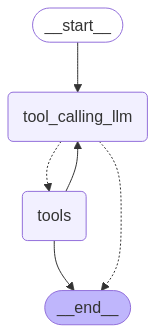

In [ ]:
agent

In [ ]:
user_input = "Explain AI in 2 bullets"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 2 bullets
================================== Ai Message ==================================

- **Machine Learning and Algorithms**: AI involves the use of machine learning algorithms and models that enable computers to learn from data, identify patterns, and make decisions with minimal human intervention. These algorithms can be trained to perform specific tasks by analyzing large amounts of data and improving their performance over time.

- **Automation and Intelligence**: AI systems are designed to automate tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation. By simulating human cognitive processes, AI can enhance efficiency and accuracy in various applications, from autonomous vehicles to virtual assistants.


In [ ]:
user_input = "summarize the key points from Nvidia's Q4 2024 earnings call"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

summarize the key points from Nvidia's Q4 2024 earnings call
================================== Ai Message ==================================
Tool Calls:
  search_web_extract_info (call_lriReFOAKX84bW0QG7uBj9Ir)
 Call ID: call_lriReFOAKX84bW0QG7uBj9Ir
  Args:
    query: Nvidia Q4 2024 earnings call summary
================================= Tool Message =================================
Name: search_web_extract_info

["## Title\n\nNVIDIA Corporation (NASDAQ:NVDA) Q4 2024 Earnings Call ...\n\n## Content\n\nNVIDIA Corporation (NASDAQ:NVDA) Q4 2024 Earnings Call Transcript\n\nNews\n\nToday's news\nUS\nPolitics\nWorld\n\nTech\n\nReviews and deals\nAudio\nComputing\nGaming\nHealth\nHome\nPhones\nScience\nTVs\nClimate change\nHealth\nScience\n\nOriginals\n\n\nThe 360\n\nNewsletters\n\n\n\n\nLife\n\n\nHealth\n\nCOVID-19\nFall allergies\nHealth news\nMental health\nRelax\nSexual health\nStudies\nThe Unwind\n\nPare

In [ ]:
event['messages'][-1]

AIMessage(content="Nvidia's Q4 2024 earnings call highlighted several key points:\n\n1. **Financial Performance**: Nvidia reported a record quarterly revenue of $22.1 billion, marking a 22% increase from the previous quarter and a 265% rise from the same period a year ago. The earnings per share (EPS) also saw significant growth, with GAAP EPS at $4.93 and Non-GAAP EPS at $5.16.\n\n2. **Data Center Growth**: The data center segment was a major contributor to revenue, with a record $18.4 billion in Q4, up 27% sequentially and 409% year-over-year. This growth was driven by the demand for AI inference, which contributed to about 40% of the data center's revenue.\n\n3. **AI and Accelerated Computing**: Nvidia's strategic focus on AI and accelerated computing has positioned it well for sustained growth. The company highlighted the transition of data center infrastructure from general-purpose to accelerated computing, driven by the slowing of Moore's Law and the increasing demand for computi

In [ ]:
from IPython.display import display, Markdown
content = event['messages'][-1].content
content = content.replace('$', '\\$')

In [ ]:
display(Markdown(content))

Nvidia's Q4 2024 earnings call highlighted several key points:

1. **Financial Performance**: Nvidia reported a record quarterly revenue of \$22.1 billion, marking a 22% increase from the previous quarter and a 265% rise from the same period a year ago. The earnings per share (EPS) also saw significant growth, with GAAP EPS at \$4.93 and Non-GAAP EPS at \$5.16.

2. **Data Center Growth**: The data center segment was a major contributor to revenue, with a record \$18.4 billion in Q4, up 27% sequentially and 409% year-over-year. This growth was driven by the demand for AI inference, which contributed to about 40% of the data center's revenue.

3. **AI and Accelerated Computing**: Nvidia's strategic focus on AI and accelerated computing has positioned it well for sustained growth. The company highlighted the transition of data center infrastructure from general-purpose to accelerated computing, driven by the slowing of Moore's Law and the increasing demand for computing power.

4. **Product and Technology Developments**: Nvidia announced several new products and collaborations, including the GeForce RTX 40 Super Series GPUs and partnerships with major cloud providers like AWS, Microsoft Azure, and Google Cloud. The company also emphasized its advancements in AI and generative AI capabilities.

5. **Market Sentiment and Stock Performance**: Following the earnings announcement, Nvidia's stock saw a notable surge, reflecting positive market sentiment and investor confidence in the company's growth trajectory.

6. **Future Outlook**: Nvidia provided strong guidance for the next quarter, expecting continued growth driven by its strategic initiatives in AI and accelerated computing. The company is also focused on expanding its ecosystem and leveraging AI across various sectors.

Overall, Nvidia's Q4 2024 earnings call underscored its strong financial performance, strategic focus on AI and accelerated computing, and positive market sentiment, positioning the company for continued growth and innovation.

In [ ]:
user_input = "analyze the key insights from both Nvidia and Intel's Q4 2024 earnings call, summarize them and tell me which company is doing better"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

    print("Response:")
    content = event['messages'][-1].content
    content = content.replace('$', '\\$')
    display(Markdown(content))

================================ Human Message =================================

analyze the key insights from both Nvidia and Intel's Q4 2024 earnings call, summarize them and tell me which company is doing better
Response:


analyze the key insights from both Nvidia and Intel's Q4 2024 earnings call, summarize them and tell me which company is doing better

================================== Ai Message ==================================
Tool Calls:
  search_web_extract_info (call_iUL0TXcyEpGSm9RYHOZN3RKs)
 Call ID: call_iUL0TXcyEpGSm9RYHOZN3RKs
  Args:
    query: Nvidia Q4 2024 earnings call key insights
  search_web_extract_info (call_48XaQXlQivPrlFxngBzfO4RM)
 Call ID: call_48XaQXlQivPrlFxngBzfO4RM
  Args:
    query: Intel Q4 2024 earnings call key insights
Response:


================================= Tool Message =================================
Name: search_web_extract_info

["## Title\n\nIntel Corporation (INTC) Q4 2024 Earnings Call & Full Presentation\n\n## Content\n\nIntel Corporation (INTC) Q4 2024 Earnings Call & Full Presentation\nFyfull\n2900 subscribers\n\n25 views\n2 Feb 2025\n📢 Intel Corporation (INTC) Q4 2024 Earnings Call & Presentation\nJoin us as Intel's leadership discusses the fourth quarter and full-year 2024 financial performance. This session includes the full official presentation, providing a comprehensive overview of the company's results and strategic initiatives.\n\n🔑 Key Highlights Include:\n\n- **Financial Performance:**\n  - **Revenue:** Reported **$14.3 billion** for Q4 2024, exceeding the estimate of **$13.81 billion**.\n  - **Earnings Per Share (EPS):** Adjusted EPS of **$0.13**, slightly above the estimate of **$0.12**.\n  - **Gross Margin:** Delivered gross margin above guidance, supported by key grant-related mil

["## Title\n\nIntel Corporation (INTC) Q4 2024 Earnings Call & Full Presentation\n\n## Content\n\nIntel Corporation (INTC) Q4 2024 Earnings Call & Full Presentation\nFyfull\n2900 subscribers\n\n25 views\n2 Feb 2025\n📢 Intel Corporation (INTC) Q4 2024 Earnings Call & Presentation\nJoin us as Intel's leadership discusses the fourth quarter and full-year 2024 financial performance. This session includes the full official presentation, providing a comprehensive overview of the company's results and strategic initiatives.\n\n🔑 Key Highlights Include:\n\n- **Financial Performance:**\n  - **Revenue:** Reported **\$14.3 billion** for Q4 2024, exceeding the estimate of **\$13.81 billion**.\n  - **Earnings Per Share (EPS):** Adjusted EPS of **\$0.13**, slightly above the estimate of **\$0.12**.\n  - **Gross Margin:** Delivered gross margin above guidance, supported by key grant-related milestones.\n\n- **Operational Highlights:**\n  - **AI PC Market:** Maintained leadership in AI PC CPUs, with plans to ship over **100 million systems** by the end of 2025.\n  - **Product Roadmap:** On track to launch **Panther Lake** on Intel 18A in the second half of 2025, showcasing advancements in performance and yield.\n  - **Intel Foundry Services:** Demonstrated progress with Intel 18A, offering competitive solutions and building a robust pipeline of potential customers.\n\n- **Strategic Initiatives:**\n  - **Capital Allocation:** Focused on disciplined capital management to support strategic priorities and shareholder returns.\n  - **Market Expansion:** Aimed to enhance participation in the cloud-based AI data center market.\n  - **Sustainability Efforts:** Continued commitment to reducing environmental impact through sustainable practices.\n\nWhether you're an investor, industry analyst, or interested in the semiconductor industry, this presentation offers valuable insights into Intel's performance and strategic direction.\n\n📊 Subscribe for more earnings calls and presentations from leading companies each quarter! Don't forget to like, comment, and share your thoughts below.\n\n\nthank you for standing by and welcome to Intel corporation's fourth quarter 2024 earnings conference call at this time all participants are in listen only mode after the speaker's presentation there will be a question and answer session to ask a question during this session you'll need to press star11 on your telephone if your question has been answered and you'd like to remove yourself from the queue simply press star11 again as a reminder today's program is being recorded and now at i' like to introduce your host for today's program Mr John Pitzer corporate vice president vest relations please go ahead thank you Jonathan and good afternoon to everyone joining us today by now you should have received a copy of the Q4 earnings release and earnings presentation both of which are available on our investor relations website inc.com for those joining us online today the earnings presentation is also available in our webcast window I'm joined today by our inm Co CEO Michelle Johnson Holt house and Dave zinner as you know Michelle is also CEO of Intel products and Dave continues to serve as Intel CFO in a few moments Michelle will open up with some summary comments before providing more detail on Intel products Dave will then discuss Intel Foundry and the overall financials including our q1 guidance before we begin please note that today's discussion contains forward-looking statements based on the environment as we currently see it and as such are subject to various risks and uncertainties it also contains references to non-gaap financial measures that we believe provide useful information to our investors our earnings release most recent annual report on form 10K and other filings with the SEC provide more information on specific risk factors that could cause actual results to differ materially from our expectations they also provide additional information on our non-gaap fincial measures including reconciliations were appropriate to our corresponding Gap Financial measures with that let me turn things over to Michelle thank you John and let me add my welcome it's been roughly two months since Dave and I stepped into our roles as interim co-ceos from day one we had been working closely together alongside the board to drive better execution of our strategy there are no quick fixes and we are committed to improving our performance and rebuilding our credibility through persistent hard work that delivers tangible results as part of this we are driving more focused Investments across the business we cannot be all things to all people and we are prioritizing areas where we can drive differentiated value we are also continuing to simplify our business and become a leaner more efficient company and most of all we are doing a better job of listening to our customers to ensure we meet their needs Q4 was a step in the right direction we delivered Revenue gross margin and EPS above our guide Intel products executed to drive Revenue in the quarter even as PC inventory continued to normalize and Intel Foundry drove incremental operating efficiencies while achieving key Grant related Milestones which supported solid upside to gross margins as co-ceos you can expect us to be very straightforward and direct we only make commitments we are confident we can deliver we firmly believe that what we say is not nearly as important as what we do and everything we do must be in service of our customers innovating to solve their most pressing challenges is the shest path to creating shareholder value this is the mindset I have brought to my position as the CEO of Intel products this is a great business with great people partners and IP to design worldclass products from Edge to Cloud I take nothing for granted but I firmly believe that the core x86 architecture and the ecosystems we have built and invested in over the decades create a solid foundation for Success our customers share this view but they need us to improve our execution and hit our commitments I am setting clear priorities and directions in each business to drive better outcomes I think about Intel products in three buckets first client Edge second traditional Data Center and third the AI data center let me spend a few moments on each in client Intel CPUs power roughly seven out of every 10 PCS this is a strong position that gives us advantages in the market that said the market is becoming more competitive especially as we see new entrance trying to participate in the AIP category personally I thrive on competition it drives a healthy paranoia across everything we do and we're using it as motivation to up our game even more the success of core Ultra across meteor Lake AOL Lake and lunar lake has established Intel as the market leader in aipc CPUs and we remain on track to ship more than a 100 million cumulative systems by the end of 2025 we are inov in at scale unlike any of our competitors this was on display earlier this month at CES where we launched the Enterprise versions of our AIC CPUs with compelling new features to Intel vpro this is a testament to the strong ecosystem we have built with it departments around manageability security trust and brand and we expect these Investments to possession us well as corporations begin their migration to Windows 11 along onside our investments in Enterprise our ecosystem reach also positions us well in the aipc consumer markets we are working with more than 200 isvs across more than 400 features to optimize their software on our silicon I'm excited about the new applications I'm seeing in the pipeline that will begin to proliferate over the coming months our goal is to innovate partner and fortify our position as the preferred CPU of choice looking ahead to the rest of the year we will strengthen our client road mapap with the launch of Panther Lake our lead product on Intel 18a in the second half of 2025 as the first volume customer of Intel 18a I see the progress that Intel foundary is making on performance and yields and I look forward to being in production in the second half as we demonstrate the benefits of our world-class design and process technology capabilities 2026 is even more more exciting from a client perspective as Panther Lake achieves meaningful volumes and we introduce our next Generation client Family Code named Nova Lake both will provide strong performance across the entire PC stack with significantly better costs and margins for us enhancing our competitive position and reinforcing our value proposition to our partners and customers let me now turn to our traditional Data Center business the team has made good progress toward toward strengthening our offerings and driving better more predictable execution this year is all about improving zeon's competitive position as we fight harder to close the gap to competition the ramp of granite Rapids has been a good first step we are also making good progress on Clearwater Forest our first Intel 18a server product that we plan to launch in the first half of next year all of this provides a strong foundation on which to build as we execute the world's data center workloads still primarily run on Intel silicon and we have a strong ecosystem especially within Enterprise we are going to leverage these strengths as we work to stabilize our market share in 2025 one of the ways we'll do this is by re-engaging the x86 ecosystem we have seen a positive response from the x86 ecosystem Advisory Group we formed last fall and we are encouraged by the enthusiasm for building both semi-custom and custom products this is a big area of opportunity for the business and we look forward to talking more about this as we have news to share turning to the AI data center I will start by saying that this is an attractive market for us over time but I am not happy with where we are today on the one hand we have a leading position as the host CPU for AI servers and we continue to see a significant opportunity for CPU based inference on Prem and at the end Edge as AI infused applications proliferate on the other hand we're not yet participating in the cloud-based AI Data Center Market in a meaningful way we have learned a lot as we have ramped gouty and we are applying those learnings going forward one of the immediate actions I have taken is to simplify our road map and concentrate our resources many of you heard me temper expectations on Falcon Shores last month based on industry feedback we plan to leverage Falcon Shores as an internal test chip only without bringing it to Market this will support our efforts to develop a system level solution at Rack scale with Jaguar Shores to address the AI data center more broadly as I think about our AI opportunity my focus is on the problems our customers are trying to solve most notably the need to lower the cost and increase the efficiency of compute AI is not a market in the traditional sense it's an enabling application that needs to span across the compute continuum from data center to the edge as such a one siiz fits-all approach will not work and I can see clear opportunities to leverage our core Assets in new ways to drive the most compelling total cost of ownership across the Continuum before I turn the call over to Dave let me close by speaking as Intel foundry's largest wafer customer I have a pretty simple approach when we are able to combine worldclass products with worldclass process technology we win as as CEO of Intel products I will always make processed technology decisions based on what is best for my customers an Intel foundary will need to earn my business every day just as I need to earn the business of my customers having said that I'm confident in Intel foundaries team ability to support my current and future product roadmap and I'm excited to do more business with them as their process technology continues to advance a stronger Intel products combined with a more competitive Intel family is a recipe for success for Intel overall Dave over to you thanks Michelle let me add my welcome I'm going to address three topics today update on Intel Foundry second Q4 and full year financials and third our q1 guidance starting with Intel Foundry I've had an opportunity to meet with a number of our partners and potential customers for Intel Foundry over the last couple months I come away from those meetings encouraged by the opportunity we have in front of us and I've received clear feedback on what our customers need from us to succeed this starts with our execution on Intel ATA this has been an area of good progress like any new process there have been puts and takes along the way but overall we're confident that we are delivering a competitive process we're excited by the launch of Panther Lake this year and the internal ramp of Intel 18a in the second half that will support increased volumes and improved profitability in 2026 from the perspective of external customers Intel 18a is a very competitive offering that gives each of them a reason to engage with us however Foundry winds are about more than just technology trust is also a significant factor customers must believe you can execute consistently and be willing to invest in IP to Port a design to a new Foundry that's why past transitions in the industry have generally started with customers giving new Foundry Partners smaller volumes then gradually increasing as trust grows we've made good progress but to accelerate this I'm asking the team to redouble their efforts on ease of porting IP availability and best known Foundry methods I'm particularly pleased by the willingness of our suppliers and partners to engage with us augmenting our expertise and hard work with theirs job number one is earning the customer trust the Intel 18a design wins to date provide good validation of the strategy and we continue to have a healthy RFQ pipeline of potential customers but we won't win every deal out of the gates we'll be selective and focused on areas where we are confident that we can be a meaningful contributor to the success of our customer and we look forward to updating you as rfqs become wins in addition we continue to have good momentum in advanced packaging and in our collaboration with Tower semiconductor and UMC all three are critical to utilize our assets longer for higher rates of return this is a good segue into my other key areas of focus for Intel Foundry improving our financials and making sure that we're deploying your Capital appropriately at roughly 181 billion in Revenue Intel Foundry today is larger than all but one external Foundry that's clearly not reflected on our p&l with negative gross margins and a greater than \$1 13 billion operating loss in 2024 we're going to systematically attack our costs and remain highly focused on our goal of delivering Break Even operating income for Intel Foundry by the end of 2027 and we expect to demonstrate improvements this year the financial benefits of Shifting our wafer volume from Intel 7 to Intel 18a along with learning to run our Fabs more efficiently and our process nodes longer will be important drivers of improving our financials Beyond 2027 we need to drive to cash flow from operations that supports our Capital spending needs and ultimately generate a great return on your capital I remain very optimistic on our opportunity in at Intel Foundry the pervasive growth of AI is driving accelerating and unprecedented demand for silicon and there continues to be an unmet need for greater choice and overall manufacturing capacity in the industry today tsmc is a valued supplier to Intel products and important partner to IMS and they've established a very high standard for what it takes to be a worldclass foundary but the market overall needs multiple players and as we execute Intel Foundry has a very important role to play globally and especially here in the us where we continue to invest in Leading Edge R&D and Manufacturing capacity we're also pleased to sign with the US Department of Commerce a definitive agreement awarding us up to \$ 7.86 billion in Grants as you know these grants are Milestone based and we have already received \$1.1 billion in Q4 and have received an additional \$1.1 billion in January of q1 in addition we continue to make good progress building out our secure Enclave in partnership with the Department of Defense we look forward to continued engagement with the Trump Administration as we advance this work and support their efforts to strengthen us Technology and Manufacturing leadership finally as you will recall we announced Our intention to establish an independent subsidiary structure for Intel Foundry to provide clear governance and operational separation this structure also enables us to seek additional funding options from both strategic and Financial Partners which we are now actively beginning to explore let me now turn to our Consolidated Financial results and q1 guidance 14.3 billion up 7% sequentially and at the high end of the range we provided in October as a result of solid growth in ccg equipment sales at Ms and the edge business of NX non-gaap gross margin came in at 42.1% 260 basis points ahead of guidance on higher Revenue better costs and the receipt of our first chips Grant offset partially by inventory reserves related to gouty we delivered fourth quarter earnings per share of 13 cents versus our guidance of 12 cents higher Revenue stronger gross margin and improved operating leverage was offset by lower interest and income which includes an acral related to our second skip agreement of roughly \$750 million reflecting an an adjustment in our planned capacity ramp in Ireland in Q2 we began the process of resizing our expense structure to support more modest long-term growth including adjusting our capacity plans to more conservative levels driving impairments in Q3 and this acral in Q4 Q4 operating cash flow was positive \$3.2 billion down approximately \$900 million sequentially due to the cash outlays associated with our Q3 restructuring charges we had gross capb backs of \$6.3 billion with offsets of \$1.6 billion in the quarter resulting in an adjusted free cash flow of negative \$1.5 billion as I mentioned earlier we also received a portion of the chips grants this quarter for the full year revenue is \$ 53.1 billion down 2.1% year-over-year modest year-over-year growth in Intel products was more than offset by lower Revenue at Mobil ey and Altera as well as the forecasted decline in Foundry Services due to the end of life on traditional packaging Revenue full year gross margin was 36% and down 760 basis points due to Q3 impairments lower revenue and inventory impacts full year EPS was minus33 and down \$118 on Lower Revenue lower gross margin and higher period charges we generated \$8.3 billion in cash from operations made \$24 billion of gross Capital Investments and generated capital offsets of approximately 13.4 billion from skip partner contributions and government grants and incentives as a result adjusted free cash flow was minus \$2.2 billion and we ended the year with \$22.1 billion of cash and short-term Investments moving to segment results for Q4 Intel products Revenue was \$13 billion up 7% sequentially ccg Revenue was up 9% quarter over quarter as the rate at which our customers digested inventory slowed meaningfully from Q3 while difficult to quantify we suspect a portion of Q4 Revenue upside was due to customers hedging against potential tariffs DCI Revenue was up slightly sequentially off a better than expected Q3 as demand for traditional servers remained stable revenue for nexx was up 7.5% sequentially and is now up more than 20% from Q2 lows as customers are returning to more normal buying patterns especially in our Edge business operating profit for Intel products was \$3.6 billion 28% of Revenue Vue and up \$300 million quarter over quarter on higher revenue and reduced operating expenses Intel Foundry delivered revenue of \$4.5 billion up 3% sequentially on increased euv wafer mix and higher equipment sales by IMS euv wafer Revenue Grew From 1% of total revenue in 2023 to greater than 5% in 2024 Intel Foundry operating loss in Q4 of \$2.3 billion improved meaningfully sequentially as Q3 was impacted by \$3.1 billion of impairments excluding impairments operating loss would have been roughly flat quarter on quarter turning to all other mobile ey reported revenue of \$490 million up 1% sequentially with operating profit of \$103 million and earlier today guided for full year 2025 increases to both revenue and operating income Altera delivered revenue of \$429 million up 4% sequentially operating margin was 21% versus 2% in Q3 on better gross margins and operating leverage for q1 we expect Altera Revenue to be down sequentially less than overall Intel Consolidated we continue to make good progress on the stake sale of Altera and see a path for an IPO in the coming years now turning to guidance q1 has historically been our seasonally weakest quarter of the Year down high single to low double digits percentage sequentially on average in addition we see added pressure coming from macro uncertainty especially around tariffs balancing of PC inventory and increasing competition these mitigating factors support a more tempered Revenue Outlook as we come into the new year as a result we're forecasting a revenue range of 11.7 to 12.7 billion in the first quarter of 2025 down between 11 to 18% sequentially within Intel product we expect Revenue to decline across all three of our segments at roughly similar rates we expect Intel Foundry Revenue roughly flat to down modestly quarter over quarter helped by continued mix shift to euv Wafers Intel 18a samples and advanced packaging at the midpoint of 12.2 billion we expect gross margin of approximately 36% with a tax rate of 12% and break even EPS all on a non-gaap basis let me take a few moments to provide some commentary that may be helpful for your full year 2025 modeling at the Consolidated level we expect gross margin to improve from q1 Intel products gross margin was 51% in 2024 and is expected to decline this year due to product mix in both ccg and DCI Intel founder gross margin will improve on euv mix shift and growth in advanced packaging despite expected depreciation growth in 2025 of roughly 10% we continue to Target 2025 opcs of\$ 17.5 billion with further reductions in 2026 we expect non-controlled income or NCI to net to roughly zero in q1 and be in the range of 500 to 700 million impact this year on a gap basis NCI is expected to grow in fiscal year 2026 to a range of 1.2 to \$1.4 billion on a gap basis and increase further in future years as we increase we for routs at our Fabs where we have agreements with skip Partners we anticipate that our 2025 gross Capital investments will be approximately 20 billion at the low end of our previous guide of 20 to2 23 billion reflecting further capacity adjustments to Ohio and Ireland as well as better utilization of what we call our Construction in progress specifically we invested ahead of demand over the past few years and these capital investments will enable us to meet expected demand at a lower level of spending as we drive to more efficiently deploy our Capital we expect 2025 net capex of 8 to 11 billion with roughly half of the offsets expected to come from government incentives and tax credits and half from partner contributions delivering in 2025 remains a top priority for us on Lower capex increased cash from operations and value unlock across our non-core assets finally I'll will remind you that we will provide new segment reporting in conjunction with our q1 earnings we expect to make further changes to our segments including moving the edge portion of NX into ccg and our auto business from all other into ccg in addition we expect to move the networking portion of anex which includes Zeon sales into DCI and the IMs equipment business out of Intel Foundry into all other I'll wrap up by saying that Q4 was a solid quarter to close out a challenging year with that said our profitability is below where it needs to be and we must enhance our competitive position in the market Michelle and I will continue taking actions to improve the operational and financial trajectory of the business we'll remain focused on building a stronger Intel products business and becoming a more efficient Intel Foundry and by driving continued progress in these areas we're confident in our ability to unlock value for our stakeholders before you the line to questions it's worth mentioning that the board remains intensely focused on the search for a permanent CEO the search is progressing but we have nothing new to report and won't be able to add additional information on this topic today with that I'll turn it over to John to start the Q&A thank you Dave we will now transition to the Q&A portion of our call as a reminder we would ask each of you to ask one question and a brief follow-up question where applicable with Jonathan can we take the first question please certainly and our first question for today comes from the line of Ross Seymour from Deutsche Bank your question please hi guys thanks for me ask a question I guess the first one would be for MJ you talked about no quick fixes uh but a lot of things to improve the road map specifically on the DCI side of things can you talk about how much you think Granite is closing the Gap it sounds like clear waterer Forest has not mentioned nearly as much as far as a 2025 event neither from launch or from a revenue perspective so if there's any updates on that and then just overall what it's going to take uh and when do you think we will be able to externally see that Gap close versus competitors sure thanks for the question Ross um I look at it this way so when I talk about no quick fixes I think it's going to be one to two years of consistent execution and continuing to see better products each year really to bring our customers back to the table and be excited about Intel road map Granite Rapids is a good first step in doing that it does close the gap our customers are excited about it and we are starting to see the competitiveness of that product materialize in volume but I'm also very cleare eyed about where we stand and so we've just got to see that continued throughout 26 when we get to Diamond Rapids Etc so you also asked me about Clearwater Forest so I really look at the data center Market in kind of two buckets we have our PE Corp products which you know is granite Rapids and then we have our EC cor products which equates to Clear Water forest and what we've seen is that's more of a niche market and we haven't seen volume materialized there as fast as we expected but as we look at Clear Water Forest we expect that to come to Market in the first half of 2026 18a is doing just fine on its performance and yields for granite Rapids but it does have some complicated pack packaging um expectations that move it to 2026 um but we expect that to be a good product and continue to close the gap as well but this is going to be a journey it's not a destination Ross do you have a follow-up question yeah switching over to Dave on the profitability side uh can you just walk us through some of the puts in takes on the gross margin sequentially in the first quarter obviously revenues are down but anything else and then you mentioned that it would be the low point of the year the gross margin in the first quarter but uh what would be the headwinds and Tailwinds as you think through 2025 as a whole on that metric thank you yeah thanks Ross um okay so for the first quarter the biggest obvious contributor to gross margins uh sequentially is the revenue decline um you know at the midpoint we're declining a little over \$2 billion doar and So that obviously you know on a mostly fixed cost business that does affect it we also did have a couple of bluebirds uh in Q4 one was the revenue beat and so that actually elevated the revenue a bit but the other was when we signed the chips uh agreement uh we were able to take some of the Grant and acre it as uh you know kind of a benefit to cost of sales because it it offset period expenses we had spent uh before so uh I we weren't sure we were going to sign it in the fourth quarter which is why I didn't guide that in the uh in the guidance from last quarter but you know obviously materialized and that pushed the gross margins up for the fourth quarter um in the first quarter I think you know what and we've kind of tell graph this now for several quarters you know Intel products gross margins are going to be under pressure this year uh some of the parts have a higher cost in particular lunar lake has a higher cost uh as you know because it's got the memory in package and so you know we're basically buying that memory and turning around and selling it at the same price that's really weighing the margins down on lunar lake so margins for products is going to be under pressure pretty much throughout this year then his Panther Lake comes you know in volume next year uh more materially and you know the in addition the products beyond that uh we'll start to see some improvement in margins on Intel products uh now that was always to off be offset in a lot of ways by the margins of Intel Foundry uh you know we see more of a mix of euv Wafers they have better pricing with a better cost and so we'll see a mix Improvement throughout the year we're also reducing our spending there in Period expenses with as part of our you know kind of overall \$10 billion plus cost spending reduction but it doesn't really show up in the first quarter it's not until we get into the second and third quarter that we start to see uh that Improvement uh show up so those are really the bigger drivers of margins on the on the first quarter um it is a low Point as as we talked about you know the benefits are going to be really around you know margins improving on Intel Foundry uh as the mix of EU wavers uh increases throughout the year in particular as we get Panther Lake in there in the back half of the and we're selling uh 18a Wafers at a higher margin uh and um you know then next year we have Panther Lake in more volume and all those Wafers start to come back and that becomes a really big benefit uh to Intel overall thank you Ross Jonathan can we have the next question please certainly and our next question comes from the line of Stacy Rasin from birnen research your question please hi guys thanks for taking my question um first question just on the segment guide for next quarter why are all three product segments down equally when it sounds like you've got more headwinds just on the surface of PCS inventory digestion and maybe the roll off of some of that tariff pull forward what's going on in the in the data center and the NX businesses that makes them as bad as a client in into q1 well broadly uh across all markets and we you know we didn't necessarily Telegraph every market in terms of where we think but i' say broadly you know we're we're a little bit cautious on the macro and that affects all markets uh in addition you know seasonality does play in most of the markets and that that does impact uh the first quarter as well so I would say you know combination of just macro uncertainty combined with uh you know kind of typical seasonality across all the businesses Jon do you have a follow-up question um yeah I do thank you um so you also talked about increased competitiveness Weighing on on margins at least into q1 so again I presume that's a question on pricing I guess is that right do you expect that to persist through the year and how do you think about that competitiveness potentially waiting on pricing across client and especially in in the in the data center yes okay so the co- CEOs are trying to figure out who should answer okay go ahead whoever want take it yeah um the way I look at that is we do have increased competition as we see New Market entrance particularly come in to ccg um we've got a very good product in lunar Lake there but as Dave talked about you know the margins on that product are more pressured based on the cost of the product but we are going to stem the market segment share decline in client and we're going to go after winning every socket that mirrors itself when you think about the data center Market as well as I said Granite Rapids is a very positive step in a competitive Direction but we have to stem the tide of share loss in Data Center and so we will be fighting for every socket in that business and the way I look at it is we need to be aggressive we need to win share and we need to show our customers that they can win with us thank you Stacy Jonathan can we have the next question please certainly and our next question comes from the line PJ muse from caner fitgerald your question please yeah good afternoon thank you for taking the question um I guess first question uh under your new co-leadership uh we'd be curious to hear um how your strategy um has potentially evolved specifically for IFS I mean I think uh and we've talked about this over the last couple quarters I mean for one we are not looking to spend ahead of success and so you know you saw our Capa guide come down from the 20 to 23 range down to 20 that's in in um you know in support of that uh that strategy uh you know we want to absolutely wow the customers but to do that we've got to be very careful around what we're promising them as well so I think what you'll see see a lot of is a little bit more conservatism around how we deploy Capital how we engage with customers we want to be doing more than what we promise uh to every turn to every stakeholder including investors including customers including suppliers so what have you that's pretty much the the the strategy the main goal of building a worldclass boundary that's still in place uh you know we we feel that there absolutely is a need for another player in the Leading Edge semiconductor manufact uring space in particular in the US it aligns with the government the US government's interests as well so we're we're absolutely committed to that it's now about being very cautious and careful around generating the best roic for the shareholders CJ do you have a follow-up question I do thanks um I guess Dave another question for you um I believe that you know three three months ago the the stated goal for 2025 was to be free cash flow positive I guess given kind of the weakness we're seeing in q1 and uncertainty can you kind of walk through how how you're thinking about um the path to Turning free cash flow positive yeah so we're we're not obviously guiding uh you know beyond the first quarter but I would just say we you know we we did a very good job in a challenging uh situation in 24 around c s from operations by driving strong working Capital Improvements and we adjusted capex accordingly and uh and that helped you know stem the tide so while we were negative in before uh you know we were closer to zero than we should have been based on the Topline results I'd say it's more about the same uh in 25 we're going to be cutely focused on cash flow from operations really managing working capital effectively uh we adjusted the capex down as I talked about uh in relationship to a different Outlook uh we do expect some pretty significant um uh offsets as well more than \$10 billion of offsets which will also help uh you know I won't throw out a number yet for for adjusted free cash flow for the year but I would just say that it's a focus that we that we're where we want to improve I would say in addition to that you know we have these non-core businesses and we see opportunity to monetize there that will help us delever because that's a focus of us focus of ours in 2025 uh we are you know far along on the process of Altera uh I suspect that by the time we get earnings next next quarter we'll have something to say there that will help generate some cash that we can use to to delever thanks DJ Jonathan can we have the next question please certainly and our next question comes from the line of Joe Moore from Morgan Stanley your question please great thank you um in the prepared remarks you made reference to the sort of tempering of expectations of Falcon Shores can you talk about you know the you know what was find that and kind of what does it take for you to get uh competitive in that space uh yeah of course I can Joe I think it really comes down to taking the time over the last six weeks to actively engage with the teams look at our road maps look at where we are from a competitive perspective and from an execution P perspective and that really resulted in that decision a lot of conversations with my customers as well in regards to what do they see is needed to be com competitive and to deliver the right product and so when I looked at that obviously we have our gouty product we're learning a lot from that but one of the things that we've learned from gouty is it's not enough to just deliver the Silicon we need to be able to deliver a complete rack scale solution and that's what we're going to be able to do with Falcon excuse me with Jaguar Shores Falcon Shores will help us in that process of working on the system networking memory all the component functions of that but what customers really want is that full scale rack solution and so we're able to get to that with Jaguar Shores I think we've ALS seen a lot this week with deep seek and a lot of the excitement around not one size fits all and so I'm also trying to look at the road map to say there's a lot of Ip and assets that we have as Intel product Co that we can leverage to address this market we've got great CPUs gpus as6 fpgas and we need to figure out how we harness those because if we've seen anything this week when there are constraints put on customers they figure out different ways to deploy technology and so that's also a great opportunity and something that I'm looking at and looking at if there's ways that we can be disruptive there Joe do you have a follow-up question I do and and thank you for your cander about all of that I think I separately you mentioned in the prepared remarks about you know potentially seeing tffs driving some some pull forward can you just talk about you know how pervasive that might be is that conservatism that that might be happening are you seeing evidence that that's happening just some color on on where that's coming from yeah I mean we you know we obviously have a fairly good sense of uh you know what customers uh you know need from quarter to quarter and in a couple of instances customers uh ordered more than we think they were digesting uh and so you know it was really you know just the analytics that gave us insight into they're doing that for a reason and we know tariffs are a big um you know subject uh of a lot of our customers uh it was in the region you might expect in the Asian region that we saw this uh you know I it's hard for me to extrapolate this Beyond this quarter um you know A lot's not known yet around what might be the plans on tariffs I just thought it was a little bit of hedging going on by customers that you know pulled Revenue into the fourth quarter and away from the first quarter thank you Joe Jonathan can we have the next question please certainly and our next question comes in line of Timothy urry from UBS your question please thanks a lot um Dave I also wanted to ask about gross margin um I think the message you were saying is that it's kind of 60% um incremental and that was kind of off of the 395 that you guided for uh you know Q four but obviously you came in you had these one-timers and now we're down in March so can you just sort of like level set us for kind of how to think of the incrementals from here incrementals from q1 in other words into Q2 three and four is that what you're saying yeah just yeah just kind of like is it off a 39 yeah yeah the the rule of thumb has generally been 60% in this period of what what I call catchup obviously we think we can do better fall through as we get more stabilized um the one dynamic in 25 is this uh you know kind of margin pressure around product like lunar Lake that that probably you know pulls the range down to probably something more like in the 40 to 60% fall through is probably the right way to think about it uh just for for that Dynamic now we get into 26 and you start to see you know a lot more 18a volume through Panther Lake you know I think we're in the 60% plus range at that level Tim do you have a follow on question I do um yeah Dave also so um you took the capex to the low end but there's a billion two outflow that's in the financing section of the cash flow statement what what what is that I guess I'm trying to figure out just on an Apples to Apples basis is like capex really coming down this year and is that line item in the financing section is that going to keep getting bigger this year thanks yeah no the fin the you know the let's see let me go back in the capex um if you look at capex for to for 25 the 20 the 20 20 billion dollar forecast what's driving that lower is really a function of you better utilizing assets under construction so you know our philosophy had been to invest kind of ahead of uh what was required and we built up a pretty significant balance in assets under construction I mean to the tune of greater than \$50 billion so we actually have a lot of capital on the balance sheet that really hasn't been deployed and so what we pushed the teams to do in an effort to drive better you know Roa and return on invested capital is to have them digest as much as that as possible and limit the amount of purchases uh that we that we make externally and that all that's going to allow us to get down to the to the2 billion range I would be we're not doing any funky financing around this but I would uh be you know in the spirit of transparency say that you know capex is two things right it's what what you place in terms of orders on equipment and it's when you give them the cash and so for sure we are working the payment terms of suppliers uh to improve our uh you know to improve our cap backs lower our cap backs that that is pushing uh you know spend out even as we're getting the Assets in but quite honestly by the time we've actually deployed it and it's depreciating we've actually in all cases I think spent the money um because it it goes onto assets under construction it probably hangs in there for like nine months before it's ever deployed thank you Tim Jonathan can we have the next question certainly our next question comes from the line of V area from Bank of America Securities your question please uh thanks for taking my question uh first uh kind of related questions are on uh the data center server on CPU Market um M I'm curious when you look at um you know Intel versus your x86 competitor do you think their share gains are because of better design or access to better you know manufacturing um and so what can be fixed and you know what will take uh time to fix so if you were to Outsource more right to external Foundry does does that help you regain a share and I imagine that applies more more to Cloud uh and then on the Enterprise side have you seen any share shifts uh at all uh over the last few years thanks VC um well as we look at Data Center and the competitiveness um as I said or stated earlier um you know Granite Rapids did a good job of making a good first step in closing the Gap versus competition but we still have a gap and so we've got to be laser focused next on delivering Diamond Rapids and the feedback for both of those products early is very is very positive when it comes to external manufacturing I've been pretty transparent about this and the way um I think about it in My Philosophy you know the way I look at it is you have to have the right product the right process and you have to deliver that within the right Market window if you look at Intel as overall today we do about 30% of our manufacturing externally across a variety of Partners that's probably the high for where we are today but it will never be 0% um what I can tell you is 18a is going well they earned my business obviously both for Panther Lake and for Clear waterer Forest but as I think about being more competitive in data center moving forward and I look at Future designs I will ask myself that question every time as we look at the road mapap so I think it would not be unfathomable that I would put a data center product outside if that meant that I hit the right product the right Market window as well as the right performance for my customers do you have a followup question yes thank you John so maybe one for Dave on this non-controlling interest I think Dave you said 5 to 700 million uh for this year so a little bit lower than um you know than I think the 700 you had before but then it starts to grow to 1.2 or 1.4 billion is this always going to you know keep on increasing um right like what is the right way for us to model it because the less you Outsource I I guess the more you insource the more you give to int Foundry the more reversals um right you have to do on this NCI part I I would imagine so is there a reasonable way to model how much of a headwind this is to your reported EPS yeah it's a good question I mean let just to break it all out it's more than just the Skips Skip one and two are obviously in there but but also uh mobilize shows up in non-controlling interest and as we sell down uh stakes in companies like mobile Altera it actually exacerbates that NCI so Altera doesn't have any NCI but as soon as we sell a stake it is going to have NCI so there are a number of things that go into it which makes it a little bit difficult to forecast because you have to kind of know what you have to know two things with certainty one exactly what share of every asset you have and to you know what your production is going to look like in the Fabs that you have um have these skips um so what we felt comfortable was was guiding uh guiding 25 and and giving you an indication for 26 it's likely to go up in 27 uh but I think it's probably too soon to actually identify what the exact number will look look like thanks for that Jonathan can we have the next question please certainly our next question comes from the line Ben rtis from melus your question please hey guys uh thanks lot for the question uh Dave and MJ I wanted to you know I know in your prepared remarks you said you look forward to working with the Trump Administration um I was wondering if you could just give a little more detail about your initial talks with them uh have they reached out and who who's like leading the discussions from your side and you know any any color on what you're what you're exactly talking about and what they're particularly interested in I mean Howard lutnick obviously he sounds like this is very near and dear to him uh during his confirmation hearings and um would love to just kind of get a little bit more color on where you what you have done so far and where you think it's going um and then I'll have a followup thanks so much guys yeah okay thanks Ben uh maybe I'll take that as the co-ceo how's that um the uh you know we have good engagement with them we've we've really been engaged since the election uh with the team uh you know at various levels obviously uh at the CEO level uh but also we have a strong government Affairs team that engages with them every day uh I feel really good about their outlook on bringing semiconductor manufacturing back to the US uh I think this is a very positive sign obviously for us quite honestly we never left the US so we're in a kind of the pole position in that regard uh and I think they understand the value of doing R&D in the US uh for advanced semiconductor manufacturing which also is positive um you know they want to see more jobs coming back to the US uh we pay high wage high-tech jobs uh so that's obviously positive for them but more importantly you know this is about security both in terms of just the supply chain but also in you know kind of secure manufacturing for the Department of Defense uh which you know we're obviously in a in a position to do for them um you know I imagine that you know as we progress uh we'll be more engaged with them uh to make this a reality uh and uh both Michelle and I will be meeting um fairly regularly with with the Trump Administration uh officials to go make their their goals a reality for the US Ben you said you had a followup yeah thanks um I want to double click on a prior question on Gross margins and and ask it a a little bit more in caveman terms rather than incrementals um you know you talked about one Q being the bottom um I'm trying to figure out you know how high you know it goes sequentially as we go throughout the year giving sounds like you're going to be a lot more price aggressive in server CPUs and client CPUs from what I heard so you know in addition to you know I'm trying to balance that with the thought of of Outsourcing more to tsmc for the year Etc so if that's the low point I guess what I'm trying to say can you be more prescriptive in light of that pricing comment I made and and if it's right you know then just give us a little more color on where we go from the one Q that'd be great thanks yeah yeah I mean you intend to be competitive uh in the product space and also you know as I mentioned the cost structure is uh you know under some pressure in particular because of lunar Lake uh so that that absolutely will impact the gross margins on products uh there won't be a lot of lift uh in that business unit uh through the year and it's really not until Panther Lake comes that they I think start to see some better cost structure and you know have a have a part that's very competitive that I think allows us to uh you know perhaps even relax some of that um that pressure in a competitive market that said The Foundry business will see improvements um you know over the course of the year uh more Wafers will will be coming back uh with Panther Lake it becomes even better uh in the following year uh we are improving the cost structure of The Foundry business as part of our overall spending reduction plan so that will also help and then just keep in mind you know these these Wafers that uh we're producing at Intel 3 and ATA uh have much better cost structure uh and margin structure uh relative I should say Rel relative to the price structure uh than their predecessors and that will be beneficial on The Foundry side so in the caveman uh macro sense I think the best thing to do is probably take this like somewhere in the 40 to 60% fall through and that's probably the right rough order math uh to get you to where the margins will go in any quarter based on you know what you're projecting the revenue to be in that quarter thanks Ben Jonathan can we have the next question please certainly our next question comes from the line of Aaron rers from Fargo your question please yeah thanks for taking a question I want to build off of that that that last question a little bit you know during the prepared remarks you you had mentioned 1% in 2023 was euv uh wafer mix and that that progressed to north of 5% uh this year can c can you give us a a framework of how how you would define success uh looking through 2025 maybe exiting the year as far as euv wafer mix and remind us again what the what the the Delta is and terms of cost structure the the margin dynamics of an EU euv wafer yeah well I'll say um on the second part maybe I'll I'll answer that one first I would say the price on those Wafers goes up at 3x the cost of those of those W or sorry maybe said it the Blended ASP and cost goes up three uh 3x as you go to 18a versus the the cost so it's a pretty dramatic Improvement in Gross margins uh as you move into 18a versus you know pre waivers um you know I I probably be tough for me to Hazard a guess on exactly how we'll exit the year in terms of our percentage of euv it's definitely going to go up um you know granted is on Intel 3 uh Panther Lake is is on uh metor lake is on Intel 3 or four called 4 three weight node uh Panther Lake is on 18a this year so we'll we'll see a pretty meaningful jump in the percentage of Wafers that will be euv uh as we exit 25 y do you have a followup question I I do and it's probably a dumb question but I'm just going to ask it because I'm just a little confused that you know the skip impact this this five to 700 million going to 1.2 billion just just remind us again so we're all clear that when you report EPS on a on a on a non-gaap basis that's that's in that EPS number just so we I'm modeling it correctly I'm sure my my peers are already but I I want to make sure I've got that all clear in my head yeah I just want to make be clear it's not just skip I mean that includes the mobile eye income uh and will include the Altera income to some extent but yeah all of that in the NCI we do take it against our non-gaap uh number to to get our fully deluded non-gaap PPS number Aaron thank you Jonathan we have time for one more question certainly and our final question for today comes from the line of sery paseri from Raymond James your question please thank you thanks for squeezing me in um Dave on the um Foundry break even I guess Target for 2027 maybe can you um talk about what are the assumptions behind that I mean do you think you can get there with u you know mostly internal Wafers or do you need external customers as well if so you know what sort of Revenue do we need from external customers to I guess achieve that break even yeah so you know we're still aiming to get uh to break even in 27 as you pointed out it's really on the back of internal Wafers or you know Wafers from Intel products I should say um and uh you know it's it's you know obviously a lot based on uh euv Wafers which carry a better margin and as that mix improves that significantly improves uh the margins but more importantly I I think you know the original premise by creating this different p&l structure was to drive the boundary business really at that point was just a function manufacturing to be more focused on efficiency to squeeze out more from the existing footprint to be more sensitive to Capital and ultimately just think about roic and everything they do and I think that has worked actually I mean I hear it all the time it's amazing the transformation we've seen in staff meetings and Michelle and I uh that attend that you know how they're they're they completely pivoted to how to make money uh in that business and so I think it's working uh I think we'll see significantly more efficiency as we go into uh you know work through 25 and into 26 so I feel good about our ability to get to break even obviously we we want to have uh external customers and so you know we have a some some very small amount that we've assumed for 27 uh but if 18a looks like it's it's something that hunts based on feedback from customers and I feel like we will probably outperform in that regard uh in terms of the mix of external customers versus internal customers so you know those are all the factors that I think will drive uh 27 to profitability and ultimately obviously want to get to or PR the break even and ultimately want to get the business to a to a profitable level that's you know consistent with what The Foundry industry gets Trina do you have a quick follow one yeah quick one so on the 18a Panther Lake U I think in the past I think Dave the comment was that you know you you expect to bring roughly 70% of the die inhouse is that still the plan and then is that pretty set in stone that you know you're bringing it back for sure or do you have any flexibility uh whether to bring back more of the D or less of the D you know if you need to so just trying to understand you know yeah I'm gonna let Michelle answer that because it really is her decision on how she builds her products yeah so we did move Panther Lake um inside it's an 18a design one but as I stated before you know we look at each generation of product based on what's the right product what's the right process what's the right Market window and what allows our customers to win so for Panther Lake that was 18a and as I said we're very happy with where we are from a performance and yield perspective at this point in the process so that will stay on 188 then as you look forward to you know our next Generation product for client after that Nova Lake we'll actually have die both inside and outside for that process so you'll actually see compute tiles inside and outside again it's about optimizing to what allows us to win in the market what allows us to win with our customers and optimizing the overall product portfolio because at the end of the day if our customers are successful we win that drives more you know wafers in Intel Foundry and that allows us to win but I'll continue to have a balance and as I said we'll be doing the same look across our data center portfolio as well all right thanks Michelle so with that let me wrap up by saying thank you uh as always for joining the call uh MJ and I appreciate the opportunity to discuss our progress and the actions we've taken Q4 was a good step forward obviously but we have have a lot of hard work ahead of us and we're looking forward to updating you as we go along we hope to see many of you in person at the investors conferences will be attending in q1 and I'd also like to highlight that the Intel boundary team will be hosting their second annual Direct Connect user event on April 29th in San Jose and we hope many of you will join that in person so thank you and good night thank you thank you ladies and gentlemen for your participation in today's conference this does conclude the program you may now disconnect good day", "## Title\n\nIntel Corp (INTC) Q4 2024 Earnings Call Highlights - Yahoo Finance\n\n## Content\n\nPublished Time: 2025-01-31T07:42:04.000Z\nIntel Corp (INTC) Q4 2024 Earnings Call Highlights: Surpassing Guidance Amidst Market Challenges\n\nNews\n\nToday's news\nUS\nPolitics\nWorld\n\nTech\n\nReviews and deals\nAudio\nComputing\nGaming\nHealth\nHome\nPhones\nScience\nTVs\nClimate change\nHealth\nScience\n\nOriginals\n\n\nThe 360\n\nNewsletters\n\n\n\n\nLife\n\n\nHealth\n\nCOVID-19\nFall allergies\nHealth news\nMental health\nRelax\nSexual health\nStudies\nThe Unwind\n\nParenting\n\n\nFamily health\n\nSo mini ways\n\nStyle and beauty\n\n\nIt Figures\n\nUnapologetically\nHoroscopes\n\nShopping\n\n\nBuying guides\n\nFood\nTravel\nAutos\nGift ideas\nBuying guides\n\n\n\n\nEntertainment\n\nCelebrity\nTV\nMovies\nMusic\nHow to Watch\nInterviews\nVideos\n\n\nFinance\n\nMy Portfolio\n\nNews\n\nLatest\nStock Market\nOriginals\nThe Morning Brief\nEconomies\nTariff Updates\nPremium News\nEarnings\nTech\nHousing\nCrypto\n\nMarkets\n\n\nStocks: Most Actives\n\nStocks: Gainers\nStocks: Losers\nTrending Tickers\nFutures\nWorld Indices\nUS Treasury Bonds Rates\nCurrencies\nCrypto\nTop ETFs\nTop Mutual Funds\nOptions: Highest Open Interest\nOptions: Highest Implied Volatility\nSectors\nBasic Materials\nCommunication Services\nConsumer Cyclical\nConsumer Defensive\nEnergy\nFinancial Services\nHealthcare\nIndustrials\nReal Estate\nTechnology\nUtilities\n\nResearch\n\n\nScreeners\n\nCalendar\nStock Comparison\nAdvanced Chart\nCurrency Converter\nInvestment Ideas\nResearch Reports\n\nPersonal Finance\n\n\nCredit Cards\n\nBanking\nBest HYSA\nStudent Loans\nPersonal Loans\nInsurance\nMortgages\nMortgage Calculator\nTaxes\nH&R Block Tax Insights\n\nVideos\n\n\nLatest\n\nEditor's Picks\nInvesting Insights\nTrending Stocks\nAll Shows\nMorning Brief\nOpening Bid\nWealth\nETF Report\nTrade This Way\nOptions 101\nDavos 2025\nStreaming Now\n\n\n\n\nSports\n\n\nFantasy\n\nNews\nFantasy football\nBest Ball\nPro Pick 'Em\nCollege Pick 'Em\nFantasy baseball\nFantasy hockey\nFantasy basketball\nDownload the app\nDaily fantasy\n\nNFL\n\n\nNews\n\nScores and schedules\nStandings\nStats\nTeams\nPlayers\nDrafts\nInjuries\nOdds\nSuper Bowl\nGameChannel\nVideos\n\nMLB\n\n\nNews\n\nScores and schedules\nStandings\nStats\nTeams\nPlayers\nOdds\nVideos\nWorld Baseball Classic\n\nNBA\n\n\nNews\n\nDraft\nScores and schedules\nStandings\nStats\nTeams\nPlayers\nInjuries\nVideos\nOdds\nPlayoffs\n\nNHL\n\n\nNews\n\nScores and schedules\nStandings\nStats\nTeams\nPlayers\nOdds\nPlayoffs\n\nSoccer\n\n\nNews\n\nScores and schedules\nPremier League\nMLS\nNWSL\nLiga MX\nCONCACAF League\nChampions League\nLa Liga\nSerie A\nBundesliga\nLigue 1\nWorld Cup\n\nCollege football\n\n\nNews\n\nScores and schedules\nStandings\nRankings\nStats\nTeams\n\nShow all\n\n\nMMA\n\nWNBA\nSportsbook\nNCAAF\nTennis\nGolf\nNASCAR\nNCAAB\nNCAAW\nBoxing\nUSFL\nCycling\nMotorsports\nOlympics\nHorse racing\nGameChannel\nRivals\nNewsletters\nPodcasts\nVideos\nRSS\nJobs\nHelp\nWorld Cup\nMore news\n\n\n\n\nNew on Yahoo\n\nCreators\nGames\nTech\n\nLocal Services\n\n\nTerms\n\nPrivacy\nPrivacy Dashboard\nFeedback\n\n© 2025 All rights reserved.\nAbout our ads Advertising Careers\nYahoo Finance\nYahoo Finance\nSearch query \nSelect edition\n\nUSEnglish\nUS y LATAMEspañol\nAustraliaEnglish\nCanadaEnglish\nCanadaFrançais\nDeutschlandDeutsch\nFranceFrançais\n香港繁中\nMalaysiaEnglish\nNew ZealandEnglish\nSingaporeEnglish\n台灣繁中\n\nUKEnglish\n\n\nNews\n\nFinance\nSports\n\nMore\n\nNews\nToday's news\nUS\nPolitics\nWorld\nWeather\nClimate change\nHealth\nScience\nOriginals\nNewsletters\n\n\nLife\nHealth\nParenting\nStyle and beauty\nHoroscopes\nShopping\nFood\nTravel\nAutos\nGift ideas\nBuying guides\n\n\nEntertainment\nCelebrity\nTV\nMovies\nMusic\nHow to watch\nInterviews\nVideos\n\n\nFinance\nMy portfolio\nWatchlists\nMarkets\nNews\nVideos\nScreeners\nPersonal finance\nCrypto\nIndustries\n\n\nSports\nFantasy\nNFL\nNBA\nMLB\nNHL\nCollege football\nCollege basketball\nSoccer\nMMA\nYahoo Sports AM\n\n\n\n\n\nNew on Yahoo\n\nCreators\nGames\nTech\nLocal Services\n        *   Selected editionUSEnglish\n\n\n\n\n\n\n\nMail\nSign in\n\nMy Portfolio\n\nNews\n\nLatest\nStock Market\nOriginals\nThe Morning Brief\nEconomies\nTariff Updates\nPremium News\nEarnings\nTech\nHousing\nCrypto\n\n\n\nMarkets\n\nStocks: Most Actives\nStocks: Gainers\nStocks: Losers\nTrending Tickers\nFutures\nWorld Indices\nUS Treasury Bonds Rates\nCurrencies\nCrypto\nTop ETFs\nTop Mutual Funds\nOptions: Highest Open Interest\nOptions: Highest Implied Volatility\nSectors\nBasic Materials\nCommunication Services\nConsumer Cyclical\nConsumer Defensive\nEnergy\nFinancial Services\nHealthcare\nIndustrials\nReal Estate\nTechnology\nUtilities\n\n\n\nResearch\n\nScreeners\nCalendar\nStock Comparison\nAdvanced Chart\nCurrency Converter\nInvestment Ideas\nResearch Reports\n\n\n\nPersonal Finance\n\nCredit Cards\nBanking\nBest HYSA\nStudent Loans\nPersonal Loans\nInsurance\nMortgages\nMortgage Calculator\nTaxes\nH&R Block Tax Insights\n\n\n\nVideos\n\nLatest\nEditor's Picks\nInvesting Insights\nTrending Stocks\nAll Shows\nMorning Brief\nOpening Bid\nWealth\nETF Report\nTrade This Way\nOptions 101\nDavos 2025\n\n\n\nStreaming Now\n\n\n…\nUpgrade to Premium\nUnlock stock picks and a broker-level newsfeed that powers Wall Street. Upgrade Now\n\nIntel Corp (INTC) Q4 2024 Earnings Call Highlights: Surpassing Guidance Amidst Market Challenges\n\nGuruFocus News\nFri, Jan 31, 2025, 2:42 AM 4 min read\nIn This Article:\nINTC -0.53%\n\n\nQ4 Revenue: \$14.3 billion, up 7% sequentially.\n\n\nQ4 Non-GAAP Gross Margin: 42.1%, 260 basis points ahead of guidance.\n\n\nQ4 Earnings Per Share (EPS): \$0.13, versus guidance of \$0.12.\n\n\nQ4 Operating Cash Flow: \$3.2 billion.\n\n\nQ4 Adjusted Free Cash Flow: Negative \$1.5 billion.\n\n\nFull Year 2024 Revenue: \$53.1 billion, down 2.1% year over year.\n\n\nFull Year 2024 Gross Margin: 36%, down 760 basis points.\n\n\nFull Year 2024 EPS: Minus \$0.13.\n\n\nFull Year 2024 Cash from Operations: \$8.3 billion.\n\n\nFull Year 2024 Adjusted Free Cash Flow: Minus \$2.2 billion.\n\n\nQ1 2025 Revenue Guidance: \$11.7 billion to \$12.7 billion.\n\n\nQ1 2025 Gross Margin Guidance: Approximately 36%.\n\n\nQ1 2025 EPS Guidance: Breakeven on a non-GAAP basis.\n\n\nIntel Foundry Q4 Revenue: \$4.5 billion, up 3% sequentially.\n\n\nIntel Foundry Q4 Operating Loss: \$2.3 billion.\n\n\nMobileye Q4 Revenue: \$490 million, up 1% sequentially.\n\n\nAltera Q4 Revenue: \$429 million, up 4% sequentially.\n\n\nWarning! GuruFocus has detected 8 Warning Signs with INTC.\n\n\nRelease Date: January 30, 2025\nFor the complete transcript of the earnings call, please refer to the full earnings call transcript.\nPositive Points\n\n\nIntel Corp (NASDAQ:INTC) delivered revenue, gross margin, and EPS above guidance for Q4 2024.\n\n\nThe company achieved key grant-related milestones, supporting solid upside to gross margins.\n\n\nIntel Corp (NASDAQ:INTC) remains a market leader in AI PC CPUs, with plans to ship over 100 million systems by the end of 2025.\n\n\nThe launch of Panther Lake on Intel 18A is on track for the second half of 2025, showcasing progress in performance and yield.\n\n\nIntel Foundry has made good progress with Intel 18A, showing competitive offerings and a healthy RFQ pipeline of potential customers.\n\n\nNegative Points\n\n\nIntel Corp (NASDAQ:INTC) faces increased competition in the AI PC category, impacting market dynamics.\n\n\nThe company is not yet participating meaningfully in the cloud-based AI data center market.\n\n\nIntel Foundry reported a significant operating loss of over \$13 billion in 2024, with negative gross margins.\n\n\nQ1 2025 guidance indicates a sequential revenue decline of 11% to 18%, reflecting macro uncertainty and seasonality.\n\n\nIntel Products' gross margins are expected to be under pressure throughout 2025 due to product mix and cost structure.\n\n\nQ & A Highlights\nQ: Can you talk about how much you think Granite Rapids is closing the gap in the DCAI side of things and any updates on Clearwater Forest? A: Michelle Johnston Holthaus, Interim Co-CEO, explained that Granite Rapids is a good first step in closing the gap with competitors, and customers are excited about it. Clearwater Forest is seen as a niche market product, expected to come to market in the first half of 2026. The focus is on consistent execution over the next 1 to 2 years to improve competitiveness.\nStory Continues\nQ: Can you walk us through the gross margin sequentially in the first quarter and the headwinds and tailwinds for 2025? A: David Zinsner, Interim Co-CEO and CFO, noted that the revenue decline is the biggest contributor to lower gross margins in Q1. Intel Products' margins will be under pressure due to higher costs, particularly with Lunar Lake. Improvements are expected later in the year with Panther Lake and increased EUV wafer mix in Intel Foundry.\nQ: Why are all three product segments down equally in the next quarter? A: David Zinsner explained that macro uncertainty and typical seasonality are affecting all markets, leading to a cautious outlook across all segments.\nQ: How has your strategy evolved for Intel Foundry Services (IFS) under new co-leadership? A: David Zinsner emphasized a more conservative approach, focusing on not spending ahead of success and being cautious with capital deployment. The goal remains to build a world-class foundry, aligning with US government interests.\nQ: What was behind the tempering of expectations for Falcon Shores, and what does it take to get competitive in that space? A: Michelle Johnston Holthaus stated that the decision was based on competitive and execution perspectives. The focus is on delivering a complete rack-scale solution with Jaguar Shores, leveraging learnings from Gaudi, and addressing customer needs for a full-scale solution.\nFor the complete transcript of the earnings call, please refer to the full earnings call transcript.\nThis article first appeared on GuruFocus.\nView Comments\nTerms and Privacy Policy\nPrivacy Dashboard\nMore Info\n\nRecommended Stories\n\nCopyright © 2025 Yahoo. All rights reserved.\n\nPOPULAR QUOTES\nDow Jones S&P 500 DAX Index Nvidia Tesla DJT Tariffs\nEXPLORE MORE\nMortgages Credit Cards Sectors Crypto Heatmap Financial News\nABOUT\nData Disclaimer Help Feedback Sitemap Licensing What's New About Our Ads Premium Plans\nTerms and Privacy Policy\nPrivacy Dashboard\nMore Info\n\n\nU.S. markets closed\nUS Europe Asia Rates Commodities Currencies Cryptocurrencies\n\n\nS&P 500 5,770.20 +31.68 (+0.55%)\n\n\nDow 30 42,801.72 +222.64 (+0.52%)\n\n\nNasdaq 18,196.22 +126.96 (+0.70%)\n\n\nRussell 2000 2,075.48 +8.93 (+0.43%)\n\n\nCrude Oil 67.05 +0.69 (+1.04%)\n\n\nGold 2,917.70 -8.90 (-0.30%)\n\n\n\n\nMy Portfolios\nMy Portfolios\nSign in to access your portfolio\nSign in\n\n\nTop Gainers\n\n\nGAP The Gap, Inc. 23.15 +3.67 (+18.84%)\n\n\nLB LandBridge Company LLC 67.72 +6.21 (+10.10%)\n\n\nRGTI Rigetti Computing, Inc. 9.35 +0.84 (+9.87%)\n\n\nELF e.l.f. Beauty, Inc. 70.68 +6.26 (+9.72%)\n\n\nTGTX TG Therapeutics, Inc. 38.44 +3.25 (+9.24%)\n\n\n\n\nTop Losers\n\n\nIOT Samsara Inc. 35.36 -6.52 (-15.57%)\n\n\nHPE Hewlett Packard Enterprise Company 15.81 -2.15 (-11.97%)\n\n\nRDDT Reddit, Inc. 133.98 -16.74 (-11.11%)\n\n\nTNXP Tonix Pharmaceuticals Holding Corp. 13.02 -1.61 (-11.00%)\n\n\nKVYO Klaviyo, Inc. 34.08 -3.58 (-9.51%)\n\n\n\n\nMost Active\n\n\nNVDA NVIDIA Corporation 112.69 +2.12 (+1.92%)\n\n\nF Ford Motor Company 9.90 +0.29 (+3.02%)\n\n\nPLTR Palantir Technologies Inc. 84.91 +4.45 (+5.53%)\n\n\nTSLA Tesla, Inc. 262.67 -0.78 (-0.30%)\n\n\nWBA Walgreens Boots Alliance, Inc. 11.39 +0.79 (+7.45%)\n\n\n\n\nTrending Tickers\n\n\n^GSPC S&P 500 5,770.20 +31.68 (+0.55%)\n\n\nIBM International Business Machines Corporation 261.54 +12.85 (+5.17%)\n\n\n^IXIC NASDAQ Composite 18,196.22 +126.96 (+0.70%)\n\n\n^DJI Dow Jones Industrial Average 42,801.72 +222.64 (+0.52%)\n\n\nBTC-USD Bitcoin USD 86,171.06 -2,979.63 (-3.34%)\n\n\n\n\nTop Economic Events\n\n\nTerms and Privacy Policy\nPrivacy Dashboard\nAd Terms Feedback More Info", "## Title\n\nCompany Earnings Intel Q4 2024 Client Computing - TechInsights\n\n## Content\n\nCompany Earnings Intel Q4 2024 Client Computing | TechInsights\nSkip to main content\nUser account menu\nSign In Free Sign Up\n TechInsights\n×\n\n\nInsights\nBy Industry\nAutomotive\nCapital Equipment\nFabless Semiconductor\nFoundry\nIntegrated Device Manufacturer\nProduct Manufacturer\nView All Industries\nBy Technology\nCompute\nLogic\nTeardown\nConnectivity\nIoT Connectivity SoC\nMobile RF\nTeardown\nManufacturing\nManufacturing Analysis\nSemiconductor Manufacturing Economics\nPackaging\nSemiconductor Packaging\nPower & Battery\nBattery\nPower Semiconductor\nTeardown\nSensors\nImage Sensor\nTeardown\nStorage\nMemory - Embedded & Emerging\nMemory - NAND & DRAM\nTeardown\nBy Theme\nArtificial Intelligence\nChinese Developments\nChiplets\nSustainability\neBook\nGenerative AI in the Telecom Industry\n\nSubscriber\nNVIDIA's Blackwell Platform: Powering AI with Advanced Electronics\n\n\nNews, Blogs & Events\nNews, Blogs & Events\nBlogs\nPodcast\nFeatured Reports\nWebinars & Events\nWebinar\nGlobal Smartphone Market Outlook in 2025 and Beyond\nSubscriber\nA Tale of Two Foundries (TSMC and HLMC) and One Design House (HiSilicon)\nDiscover why TechInsights is the semiconductor industry’s most trusted source for in-depth, actionable intelligence\nNewsletter Sign Up\n\n\nAbout Us\nOverview\nInvestments\nCustomer Case Studies\nOur Experts\nCommunity Involvement\nContact Us\n\n\nCareers\n\n\nExplore TechInsights\nUser account menu\nSign In Free Sign Up\n\nHome\n\nCompany Earnings Intel Q4 2024 Client Computing\n\nDiscover Intel's Q4 2024 earnings report, covering revenue, margins, segment performance, and device sales. Get key insights into the company's financial health and market trends.\nIntel announced Q4 2024 revenue of \$14.3 billion, down 7% year-over-year but up 7% quarter-over-quarter during its earnings call on January 30, 2025. This report is a timely summary of their earnings announcement, focused on the client computing segment. Measures analyzed include revenue, margins, profit, segments, and device sales with the goal of providing readers with a quick snapshot of market performance and trends to inform competitive strategies.\nView the Analysis\nThis summary outlines the analysis found on the TechInsights' Platform.\nEnter your email to register to the TechInsights Platform and access the full analysis summary, as well as the report.\nEmail\nContinue with Email  \nYour login attempt has failed.\nEnsure valid email or contact support.\nAlready a TechInsights Platform User?\nView the Analysis\nWebinar\n\nGlobal Smartphone Market Outlook in 2025 and Beyond\nJoin industry experts as we uncover the key forces shaping the smartphone market in 2025.\nRegister in 1-Click!\nLearn More\n\nMarch 05, 2025\nApple iPhone 16e Teardown\nDiscover the iPhone 16e teardown! Explore Apple's cost-saving design, the new Apple C1 5G modem, and key differences from the iPhone 16.\nLearn More\n\nFebruary 21, 2025\niPhone 16e Debuts with Apple’s First In-House 5G Modem and Enhanced AI Capabilities\nApple’s new iPhone 16e introduces the C1 modem, marking a major step toward modem independence from Qualcomm while delivering improved 5G performance and power efficiency.\nLearn More\n\nFebruary 04, 2025\n2025 Semiconductor Industry Forecast: Key Trends & Insights\nDiscover the top semiconductor trends for 2025, including AI-driven chip innovations, memory market shifts, and custom silicon advancements. View this free TechInsights report to stay ahead.\nLearn More\nThe authoritative information platform to the semiconductor industry.\nDiscover why TechInsights stands as the semiconductor industry's most trusted source for actionable, in-depth intelligence.\nCreate AccountNewsletter Sign Up\n×\nSign up for latest analysis, news and insights from TechInsights!\nStay informed about TechInsights’ products, services, and events. Email collection adheres to TechInsights’ Privacy Policy.\nHome\nReverse Engineering\nMarket Analysis\nSustainability Solutions\nTechInsights on China\nIndustries\nBlogs & News\nWebinars\nAbout TechInsights\nOur Experts\nCareers\nContact\n\n\n\n\n1-877-826-4447\n1891 Robertson Rd #500, Nepean, ON K2H 5B7\nCopyright © 2025 TechInsights Inc. All rights reserved.\nAccessibility | Privacy Policy | Terms and Conditions | Conflict of Interest and Confidential Information | Ethics and Compliance\n\n", "## Title\n\nWhat to Expect From Intel's Q4 2024 Earnings Report - Nasdaq\n\n## Content\n\nWhat to Expect From Intel's Q4 2024 Earnings Report | Nasdaq\nSkip to main content\n\n\nNasdaq+\nWeekly Macro+\nScorecard\n\nMarket Activity\n\nU.S. Market Activity ->\nStocks\nOptions\nETFs\nMutual Funds\nIndexes\nCryptocurrency\nCurrencies\nFixed Income\n\n\n\nEuropean Markets ->\n\nShares\nIndexes\nFixed Income\nOptions & Futures\nETPs\nWarrants & Certificates\nFunds\nNews\nEuropean Commodities\n\nMarket Regulation ->\n*   U.S. Regulation\n*   European Regulation\n    *   U.S. Market Quick Links\n*   Real-Time Quotes\n*   After-Hours Quotes\n*   Pre-Market Quotes\n*   Nasdaq-100\n*   Symbol Screener\n*   Glossary\n*   Sustainable Bond Network\n*   Symbol Change History\n*   IPO Performance\n*   Ownership Search\n*   Dividend History\n*   Investing Lists\n    *   U.S. Market Events\n\nEconomic Calendar\nEarnings\nIPO Calendar\nDividend Calendar\nSPO Calendar\nHoliday Schedule\n\nU.S. Markets Analyst Activity\n\nDaily Earnings Surprise\nForecast Changes\n\nNasdaq U.S. Data\n*   Statistical Milestones\n*   Total Returns\n*   Daily Market Statistics\n*   Most Active\n\n\nExplore All U.S. Market Activity ->\n\n\nInsights\n\nInsights + News\nNasdaq Newsroom\nNasdaq Newsletters\nFinTech News\nDriving Excellence\nComplexity Report\nGlobal Financial Crime Report\nETF Retail Investor Survey\n\n\nNasdaq Originals\nThe Winning Formula\nQuestion Today\nTradeTalks\nJourney Across the Financial System\nMeet Me @ MarketSite\n\n\nPerspectives\nMarket Makers with Phil Mackintosh\nOptions with Kevin Davitt\nRegulatory Roundup with Tony Sio\nESG Trendsetters\nGlobal Indexes: Research Insights\nNasdaq ETF Issuer Hub\nTradeTalks Newsletter\nJust for Funds\n\n\nEducation\nC02 Removals\nDerivatives Academy\nFinTech Education & Learning Services\nNasdaq Center for Board Excellence\nNasdaq ETF Education\nNasdaq IPO Academy\n\n\n\nExplore Our Newsroom ->\n\n\nSolutions\n\n\nAccess Global Markets ->\n\nPublic Markets (Listings)\nNorth American Markets\nEuropean Markets\nPrivate Markets\nNasdaq Fund Secondaries\n\nFeatured Solutions\n*   Nasdaq's IPO Process\n*   ETF Listings\n*   Nasdaq-100 Index Options\n*   Derivatives Academy\n    *   Drive Growth with Insights\n\nInvestment Intelligence\nMarket & Alternative Datasets\nNasdaq Index Solutions\n\nFeatured Solutions\n*   Nasdaq Data Link\n*   Nasdaq-100 Index\n*   Nasdaq Dorsey Wright\n*   Nasdaq eVestment™\n*   Nasdaq Solovis\n    *   Advance with Technology\n\nFinancial Technology\nFinancial Crime Management Technology\nGlobal Connectivity Services\n\nFeatured Solutions\n*   Nasdaq AxiomSL\n*   Nasdaq Calypso\n*   Nasdaq Market Infrastructure Technology\n*   Nasdaq Trade Surveillance\n    *   Accelerate Your Strategy\n\nGovernance Solutions\nCorporate ESG Solutions\nInvestor Relations Intelligence\n\nFeatured Solutions\n*   Nasdaq Boardvantage®\n*   Board Evaluations\n*   Nasdaq IR Insight®\n*   Nasdaq Metrio\n\n\nExplore All Solutions ->\n\n\nAbout\n\n\n\nOur People ->\nBoard of Directors ->\nCareers ->\nContact ->\n\n\nQuick Links\nQuestion Today\nNasdaq MarketSite\nInvestor Relations\nESG Reporting Guide\nEuropean Markets\nNasdaq Nordic Foundation\nNasdaq Thought Leadership\n\n\nNasdaq Initiatives\nPurpose\nMarket Structure Policy Advocacy\nPublic Policy Advocacy\nESG at Nasdaq\nNasdaq Entrepreneurial Center\nNasdaq Ventures\nNasdaq and the Cloud\n\n\n\nExplore All About ->\n\n\nLog in\n\n\nSign In \n\nAAPL\nTSLA\nAMZN\nMETA\nAMD\nNVDA\nPEP\nCOST\nADBE\nGOOG\nAMGN\nHON\nINTC\nINTU\nNFLX\nADP\nSBUX\nMRNA\nAAPL\nTSLA\nAMZN\nMETA\nAMD\nNVDA\nPEP\nCOST\nADBE\nGOOG\nAMGN\nHON\nINTC\nINTU\nNFLX\nADP\nSBUX\nMRNA\nAAPL\nTSLA\nAMZN\nMETA\nAMD\nNVDA\nPEP\nCOST\nADBE\nGOOG\nAMGN\nHON\nINTC\nINTU\nNFLX\nADP\nSBUX\nMRNA\nNews & Insights\n\n\n\n\n\n\n\nSmart Investing\n\nMarkets\nCompanies\nCryptocurrencies\nTechnology\n\nPersonal Finance\n\n\nMore\n\nSmart Investing\nMarkets\nCompanies\nCryptocurrencies\nTechnology\nPersonal Finance\n\n\n\nStocks\n\nWhat to Expect From Intel's Q4 2024 Earnings Report\n\nJanuary 06, 2025 — 01:37 pm EST\nWritten by Rashmi Kumari for Barchart->\n\n\n\n\n\n\n\nIntel Corporation (INTC), headquartered in Santa Clara, California, is a global leader in semiconductor innovation and computing technology. With a market cap of \$88.7 billion, Intel drives technological advancements by delivering cutting-edge processors and solutions that power data centers, personal computing, and artificial intelligence. The company is set to release its Q4 earnings on Thursday, Jan. 23.\nAhead of the event, analysts expect Intel to report a loss of \$0.04 per share, down 110.5% from \$0.38 in the year-ago quarter. The company missed the consensus estimates in three of the last four quarters while beating on another occasion.\nIts adjusted loss of \$0.63 per share for the last quarter missed the consensus estimate by 215%. Intel’s Q3 miss was driven by a \$3.1 billion impairment charge, weaker PC and server demand, and ongoing operational challenges.\nFor fiscal 2024, analysts expect Intel to report a loss per share of \$0.87, down 329% from a profit of \$0.38 per share in fiscal 2023. However, in fiscal 2025, EPS is expected to rebound, growing by 124.1% year-over-year to \$0.21.\n\nwww.barchart.com\nIntel's shares have declined 56.3% over the past 52 weeks, significantly underperforming the S&P 500 Index's (\$SPX) 26.3% gain and the Technology Select Sector SPDR Fund's (XLK) 27.1% gain during the same period.\n\nwww.barchart.com\nINTC stock dropped over 5% on Dec. 18, contributing to a broader sell-off in chip stocks that erased early market gains. Despite ongoing challenges, INTC jumped 7.8% following its Q3 earnings results on Oct. 31. The company reported revenue of \$13.28 billion, beating analyst expectations by 1.8%, though sales fell 6.2% year over year.\nFor Q4 2024, Intel projects revenue of \$13.8 billion, slightly ahead of forecasts. However, steep declines in key metrics, such as a 15% gross margin and negative free cash flow of \$2.7 billion, continue to raise concerns about its profitability and operations.\nWall Street maintains a cautious stance on Intel, with a consensus rating of \"Hold.\" Among the 37 analysts covering the stock, one rates it a \"Strong Buy,\" 30 recommend \"Hold,\" one suggests a \"Moderate Sell,\" and five rate it as a \"Strong Sell.\"\nThe average price target of \$26.10 indicates a potential upside of 26.9% from current levels.\nOn the date of publication, Rashmi Kumari did not have (either directly or indirectly) positions in any of the securities mentioned in this article. All information and data in this article is solely for informational purposes. For more information please view the Barchart Disclosure Policy here. More news from Barchart\n\nUnusual Options Alert: Abercrombie & Fitch (ANF) Is Quietly Setting Up a Bullish Pennant\nThis Quantum Computing Stock Is About to Set New Record Highs. Is It a Buy for 2025?\nRobinhood Gold Users Get Crypto Payout: Is HOOD Stock a Smart Buy in 2025?\nIs This Little-Known Chip Stock an Even Better AI Buy Than Nvidia?\n\nThe views and opinions expressed herein are the views and opinions of the author and do not necessarily reflect those of Nasdaq, Inc.\nTags\nStocks\n\nBarchart\nWith headquarters in the heart of Chicago's financial district, Barchart has been an industry-leader since 1995 when we launched Barchart.com as one of the first websites for commodities and futures market data. Since then, we have evolved into a global financial technology leader providing market data and services to the global financial, media, and commodity industries.\nMore articles by this source->\n\nStocks mentioned\nINTC\nXLK\nMore Related Articles\nThis data feed is not available at this time.\n|  |\n| --- |\n|  |\n|  |\n|  |\n|  |\n|  |\n|  |\n|  |\n|  |\n|  |\n|  |\nData is currently not available\n\n•\n\nSign up for the TradeTalks newsletter to receive your weekly dose of trading news, trends and education. Delivered Wednesdays.\n\nInvestor Relations\nContact\nCareers\nAdvertise\nMobile Apps\nNasdaq MarketSIte\nTrust Center\nNewsletters\nAccessibility\n\nChrome Extension\n\n\nPrivacy Policy\n\nCookies\nLegal\n\nCookies Settings\n\n\n\n\n\n\n\n\n\n© 2025, Nasdaq, Inc. All Rights Reserved.\nMy Quotes\n\nMy Quotes\nMy European Quotes\nWatchlist\nPortfolio\n\nAdd/Edit Symbols View as Table\nAdd symbols now or see the quotes that matter to you, anywhere on Nasdaq.com. Start browsing Stocks, Funds, ETFs and more asset classes.\n/\n\n\n\nAdd/Edit Instruments View as Table\nAdd instruments now or see the quotes that matter to you, anywhere on Nasdaq.com. Start browsing Shares, Indexes, ETP and more asset classes.\n/\n\n\n\nAdd/Edit Symbols Edit Watchlist\nYour Watchlist is empty. Add/Edit Symbols\nCreate your Watchlist to save your favorite quotes on Nasdaq.com. Log in or create a free account to get started.\n1/2\n\n\n\nOutsmart the market with Smart Portfolio analytical tools powered by TipRanks. Go to Smart Portfolio\nBack\nAdd a symbol to your watchlist\nMost Active\nBy clicking “Accept All Cookies”, you agree to the storing of cookies on your device to enhance site navigation, analyze site usage, and assist in our marketing efforts. Cookie Policy\nCookies Settings Accept All Cookies\nData is currently not available\nSearch Nasdaq.com  Clear\nSearch\nWe couldn’t find any results matching your search.\nPlease try using other words for your search or explore other sections of the website for relevant information.\nWe’re sorry, we are currently experiencing some issues, please try again later.\nOur team is working diligently to resolve the issue. Thank you for your patience and understanding.\nShow more results ->\nData is currently not available\nEdit My Quotes\nAdd up to 25 symbols\nTo add symbols:\n\nType a symbol or company name. When the symbol you want to add appears, add it to My Quotes by selecting it and pressing Enter/Return.\nCopy and paste multiple symbols separated by spaces.\n\nThese symbols will be available throughout the site during your session.\nSave data\nData is currently not available\nEdit My European Quotes\nAdd up to 25 instruments\nTo add instruments:\n\nType a instrument or company name. When the instrument you want to add appears, add it to My European Quotes by selecting it and pressing Enter/Return.\nCopy and paste multiple instruments separated by spaces.\n\nThese instruments will be available throughout the site during your session.\nSave data\nData is currently not available\nYour symbols have been updated\nYou'll now be able to see real-time price and activity for your symbols on the My Quotes of Nasdaq.com.\nContinue\nData is currently not available\nEdit Watchlist\nAdd up to 20 symbols\nTo add symbols:\n\nType a symbol or company name. When the symbol you want to add appears, add it to Watchlist by selecting it and pressing Enter/Return.\nCopy and paste multiple symbols separated by spaces.\n\nThese symbols will be available throughout the site during your session.\nSave data\nData is currently not available\nOpt in to Smart Portfolio\nWe are currently experiencing technical difficulties, please try again.\nSmart Portfolio is supported by our partner TipRanks. By connecting my portfolio to TipRanks Smart Portfolio I agree to their Terms of Use.\nSubmit Cancel\nprerender,Googlebot,Bingbot,Yandex", "## Title\n\nIntel Corp Earnings - Analysis & Highlights for Q4 2024 - AlphaSense\n\n## Content\n\nPublished Time: 2025-02-11T17:05:57-05:00\nIntel Corp Earnings - Analysis & Highlights for Q4 2024\nSkip to content\nSearch for: \nopen\n\nSupport\nLog in\n\nFree trial\n\nMenu\n\n\nPlatform\n\nCONTENT\nBroker & Independent Research – Real-time and aftermarket research from more than 1,500 providers\nExpert Transcript Library – Proprietary database of more than 175,000 expert interviews across industries\nCompany Documents – Presentations, earnings, filings, and more for 68,000+ companies worldwide\nNews – Top-tier newspapers, trade journals, and other media sources\nRegulatory – Regulatory updates from leading global health and energy organizations\nInternal Content – Secure and compliant search across your own emails, notes, and internal research\n\n\nFEATURES\nSearch – AI-fueled smart chat Assistant and Smart Synonyms™ surface relevant insights faster\nDiscover – GenAI-powered Smart Summaries that surface instant insights from premium content\nMonitor – Customizable dashboards and alerts to easily track market trends and competitors\nCollaborate – Annotation, highlighting, and note-taking tools to capture and share key insights\nAnalyze – Table tools that let you model, export, and effortlessly browse historical findings\nIntegrate – 3rd party connectors and APIs to securely upload and search your proprietary content\n\n\nENTERPRISE INTELLIGENCENEW – Generative AI-powered market intelligence platform that unlocks value from your proprietary internal content, delivering an unmatched, tailored picture of any market\nEXPERT INSIGHTS – Exclusive access to primary research, delivering on-demand and cost-effective insights through high-quality expert interviews and personalized 1:1 calls with premium experts\n\n\n\nSolutions\n\n\nENTERPRISE INTELLIGENCE – End-to-end generative AI platform for unlocking insights in your internal intelligence\nEXPERT INSIGHTS – On-demand and cost-effective access to high-quality expert interviews and 1:1 calls\nWALL STREET INSIGHTS – A leading collection of equity research from 1,500+ sell side and independent firms\n\n\nBY USE CASE\n\nBenchmarking\nBusiness Development\nCompetitive Intelligence\nDue Diligence\nEarnings Analysis\nFundamental Research\nMarket Landscaping\nPrivate Market Intelligence\n\n\nBY INDUSTRY\nAsset Management\nConsulting\nConsumer/CPG\nEnergy\nFinancial Services\nHedge Funds\nHealthcare & Life Sciences\n\n\n\n\nIndustrials\nInsurance\nInvestment & Corporate Banking\nPrivate Markets\nSell-Side Research\nTech, Media, Telecom\n\n\nCustomers\nCUSTOMER EDUCATION\nGetting Started\nHelp Center\nTraining Sessions\n\n\nSUCCESS STORIES\nCase Studies\n\n\n\n\nDow Overcomes Digital Overload With AlphaSense\nRead story\n\n\n\n\nResources\n\n\n\nBlog\nCase Studies\nEvents\nPartners\nPodcasts\nReports\nWebinars\nWhitepapers\n\n\n\n\nInteractive product tours\nExplore AlphaSense by product, feature, industry, or use case.\nInteractive tour \n\n\n\n\nAbout Us\n\n\n\nLeadership\nCareers\nMedia & Press\nContact\n\n\n\nOUR STORY\nSince 2011, our AI-based technology has helped professionals make smarter business decisions by delivering insights from an extensive universe of public and private content—including company filings, event transcripts, news, trade journals, and equity research.\n\n\n\n\nPricing\n\n\nSupport\n\nLog in\n\nStart my free trial\nStart my free trial\nopen\n\nIntel CorpFollowintel.comSentiment Score: -8\nSentiment Change: -41\nMore Details\nWant to dig deeper on Intel Corp and thousands of companies?Rapidly search an extensive universe of public and private content — earnings transcripts, company filings, equity research, trade journals, and more.\nRequest a Free Trial\nCompanies by industry\nAerospace & DefenseAutomobile ComponentsAutomobilesBanksBeveragesBiotechnologyBroadline RetailCapital MarketsChemicalsCommunications EquipmentConsumer FinanceConsumer Staples Distribution & RetailContainers & PackagingElectric UtilitiesElectronic Equipment, Instruments & ComponentsEnergy Equipment & ServicesEntertainmentFinancial ServicesFood ProductsGround TransportationHealth Care Equipment & SuppliesHealth Care Providers & ServicesHotels, Restaurants & LeisureHousehold DurablesHousehold ProductsIT ServicesIndustrial ConglomeratesIndustrial REITsInsuranceInteractive Media & ServicesLife Sciences Tools & ServicesMachineryMediaMetals & MiningMulti-UtilitiesOil, Gas & Consumable FuelsPersonal Care ProductsPharmaceuticalsSemiconductors & Semiconductor EquipmentSoftwareSpecialized REITsSpecialty RetailTechnology Hardware, Storage & PeripheralsTextiles, Apparel & Luxury GoodsTobaccoWireless Telecommunication Services\nIntel Corp Earnings - Analysis & Highlights for Q4 2024\nOverview\nPositivesNegativesOutlook\n\nIntel Foundry delivered revenue of \$4.5 billion, up 3% sequentially, on increased EUV wafer mix and higher equipment sales by IMS.\nDCAI revenue was up slightly sequentially off a better than expected Q3 as demand for traditional servers remained stable.\nIntel Foundry is making progress on performance and yields as the first volume customer of Intel 18A.\nIntel received \$1.1 billion in Q4 and has received an additional \$1.1 billion in January of Q1.\nIntel is pleased to sign with the US Department of Commerce a definitive agreement awarding up to \$7.86 billion in grants.\n\nSourceQ4 2024 Earnings Call\n\nThe company's profitability is below where it needs to be, and it must enhance its competitive position in the market.\nThe company expects Altera revenue to be down sequentially in Q1.\nThe company expects a decline in Foundry Services due to the end of life on traditional packaging revenue.\nThe company's cost structure is under pressure due to Lunar Lake.\n\nSourceQ4 2024 Earnings Call\n\nIntel is forecasting a revenue range of \$11.7 billion to \$12.7 billion in Q1 2025, down between 11% to 18% sequentially.\nIntel Products revenue is expected to decline across all three of its segments at roughly similar rates.\nIntel expects Clearwater Forest to come to market in the first half of 2026.\n\nSourceQ4 2024 Earnings Call\nQ&A Highlights from Intel Corp Earnings Call Q4 2024\n\n\nAnalyst asked about the reason for the decline in all three product segments, including client, data center, and NEX, despite the company's headwinds from PC inventory digestion and tariff pull forward.\n\nDavid A. Zinsner explained that the decline is due to a combination of macro uncertainty and typical seasonality across all markets. He added that the company is cautious about the macro environment and that seasonality affects all markets.  \n\n\n\nAnalyst asked about the persistence of the decline in client and data center segments through the year and the impact of increased competition on pricing.\n\nMichelle Johnston Holthaus explained that the company faces increased competition from new market entrants, particularly in the CCG market, and that the margins on the Lunar Lake product are more pressured due to the cost of the product. However, the company is committed to stemming the market segment share decline in client and data center and will be aggressive in winning every socket.  \n\n\n\nAnalyst asked about the incremental growth rate from Q4 to Q2, Q3, and Q4.\n\nDavid A. Zinsner explained that the incremental growth rate from Q4 to Q2, Q3, and Q4 is not clear and that the company is still working on it.  \n\n\n\nAnalyst asked about the CapEx budget for 2025 and whether it is coming down this year.\n\nDavid A. Zinsner explained that the CapEx budget for 2025 is \$20 billion, which is lower than the previous budget due to better utilization of assets under construction. The company has a significant balance in assets under construction, which has not been fully deployed, and the team is working to digest as much as possible and limit external purchases to improve ROA and return on invested capital. The company is also working on payment terms with suppliers to improve CapEx and lower costs.  \n\n\n\nAnalyst asked about Intel's approach to outsourcing manufacturing and the impact of external foundries on regaining share, specifically in the cloud and enterprise segments.\n\nMichelle Johnston Holthaus, Intel's Chief Financial Officer, explained that the company's approach to outsourcing manufacturing is to ensure that it has the right product, process, and market window, and that it will never be completely outsourced. She also mentioned that the company's current outsourcing rate is around 30% and that it may consider outsourcing data center products in the future if it means hitting the right product, market window, and performance for customers.  \n\n\n\nAnalyst asked about modeling the impact of NCI (non-controlling interest) on reported EPS, specifically the impact of selling stakes in companies like Mobileye and Altera.\n\nDavid A. Zinsner, Intel's Chief Financial Officer, explained that NCI is affected by more than just SCIPs (stock compensation plans). He mentioned that Mobileye shows up in non-controlling interest, and as Intel sells stakes in companies like Mobileye and Altera, it exacerbates the NCI. He also mentioned that it's difficult to forecast the impact of NCI on reported EPS due to the complexity of the situation, and that it's too soon to identify an exact number.  \n\n\n\nAnalyst asked about the progress of the discussions with the government officials regarding the semiconductor manufacturing in the US.\n\nDavid A. Zinsner, co-CEO of Intel, stated that they have good engagement with the government officials, including the CEO level, and have a strong government affairs team that engages with them every day. He also mentioned that the government officials are interested in bringing semiconductor manufacturing back to the US and that they understand the value of doing R&D in the US. Additionally, they want to see more jobs coming back to the US and are interested in secure manufacturing for the Department of Defense.  \n\n\n\nAnalyst asked about the pricing comment and the impact on gross margins on products.\n\nDavid A. Zinsner explained that the cost structure is under some pressure due to Lunar Lake, which will impact the gross margins on products. However, he mentioned that the Foundry business will see improvements over the course of the year, and more wafers will be coming back with Panther Lake, which will have a better cost structure and margin structure relative to the price structure. He suggested that a rough order of math to get to where the margins will go in any quarter based on the projected revenue would be somewhere in the range of 40% to 60%.  \n\n\n\nAnalyst asked about the assumptions behind Intel's plan to achieve profitability in 2027, specifically whether it can be achieved with internal wafers or if external customers are also needed.\n\nDavid A. Zinsner, CEO of Intel, explained that the company is aiming to achieve profitability in 2027 based on internal wafers, with a focus on EUV wafers that carry a better margin. He noted that the original premise of creating a different P&L structure was to drive the foundry business towards efficiency and to focus on ROIC. He also mentioned that the company has seen a transformation in staff meetings, with a focus on how to make money in the business, and that they will see significantly more efficiency as they work through 2025 and into 2026. He acknowledged that the company wants to have external customers, but that they have assumed a small amount for 2027, and that they will probably outperform in terms of the mix of external customers versus internal customers. He concluded by stating that the company wants to achieve profitability and ultimately wants to get the business to a profitable level that's consistent with what the foundry industry gets.  \n\n\n\nAnalyst asked about the plan to bring back the die inside the chip for the Panther Lake product and whether it's set in stone or if the company has flexibility to bring back more or less of the die.\n\nMichelle Johnston Holthaus, EVP and GM of the Data Platforms Group, explained that the company moved Panther Lake inside of 18A design win, but that it was based on what's the right product, process, market window, and what allows the company's customers to win. She stated that they are very happy with the performance and yield of Panther Lake at this point in the process, and that it will stay on 18A. For the next-generation product, Nova Lake, the company will have compute tiles inside and outside, allowing them to optimize their product portfolio and win in the market. She noted that they will continue to have a balance between internal and external customers, and that they will be doing the same look across their data center portfolio.  \n\n\n\nSourceQ4 2024 Earnings Call\nRelated Companies:\n ASMLASML Holding NV AMDAdvanced Micro Devices Inc AMATApplied Materials Inc AVGOBroadcom Inc NVDANVIDIA Corp NXPINXP Semiconductors N.V. QCOMQualcomm Inc 000660.KRSK hynix Inc STMSTMicroelectronics NV TSMTaiwan Semiconductor Manufacturing Co Ltd\n\n\nPLATFORM\n\nWall Street Insights®\nData Sources\nExpert Insights\nSecurity\nPricing\nHow AlphaSense Compares\n\nSOLUTIONS\n\nAsset Management\nBroker Research\nConsulting\nConsumer/CPG\nCPG Research\nDue Diligence Platform\nEmerging Markets\nEnergy\nEquity Research\nESG Benchmarking\nExpert Calls\nFinancial Research\nFinancial Services\nHealthcare Market Research\nMarket Intelligence Platform\nRetail Market Research\nHealthcare Competitive Intelligence\nHealthcare Research\nHedge Funds\nIndustrials\nInvestment and Corporate Banking\nHealthcare & Life Sciences\nMarket Intelligence Platform\nOil and Gas Market Research\nPharmaceutical Insights\nPrivate Markets\nQualitative Analysis Tool\nRetail Market Research\nSell Side Research\nTech, Media, Telecom\nTechnology Research\n\nCUSTOMERS\n\nCase Studies\nGetting Started\nHelp Center\nTraining Sessions\nTrust Center\n\nRESOURCES\n\nBlog\nDeveloper Portal\nEvents\nPartners\nReports\nWebinars\n\nABOUT\n\nOur Story\nLeadership\nCareers\nMedia & Press\nContact Us\nLegal & Compliance\n\nLog in\nDownload Mobile App\nSOLUTIONS\n\nAftermarket Research\nAlternative Data\nAnalyst Reports\nAsset Management\nBroker Reports\nCompetitive Intelligence\nCompetitor Benchmarking Tool\nCompetitive Intelligence for Leading Corporations\nConsulting\nConsulting Firms Market Research\nConsumer/CPG\nCPG Market Research\nDue Diligence Platform\nEarnings Analysis\nEmerging Markets Research\n\nSolutions Menu 2\n\nEnergy\nEnergy Competitive Intelligence\nEnergy Market Intelligence\nEquity Research Platform\nESG Benchmarking\nESG Data\nESG Due Diligence\nESG Investing\nESG Investing in Oil and Gas\nExpert Calls\nGenerative AI for Investment Research\nFinancial Research Platform\nFinancial Services\nHealthcare Competitive Intelligence\n\nSolutions Menu 3\n\nHealthcare Market Research\nHedge Funds\nIndustrials\nIndustrials Competitive Intelligence\nInsurance\nInvestment and Corporate Banking\nLife Sciences\nM&A Database\nManufacturing Market Research\nMarket Intelligence\nMedical Device Market Research\nMedtech Market Research\n\nSolutions Menu 4\n\nOil and Gas Market Research\nPatent Data\nPharma & Biotech Competitive Intelligence\nPharmaceutical Insights\nPrivate Equity Database\nPrivate Markets\nQualitative Analysis Tool\nRetail Research\nSell Side Research\nTech Competitive Intelligence\nTech, Media, Telecom\nTechnology Research\nWealth Management Firms\nWealth Management Research\n\n\nAlphasense Inc. 2025. All Rights Reserved.\n\nChange Cookie Preferences\nTerms & Conditions\nPrivacy Policy\n\n×\nStart my free trial\nPlease fill out the form below and an AlphaSense team member will be in touch within 20 minutes to help set up your trial.", "## Title\n\nIntel Reports Fourth-Quarter and Full-Year 2024 Financial Results\n\n## Content\n\nIntel Reports Fourth-Quarter and Full-Year 2024 Financial Results :: Intel Corporation (INTC)\nIntel.com\n\n\nInvestors\nOverview\nAbout Intel\nContacts\nCompany Overview\nManagement Team\n\n\nNews & Events\nOverview\nPress Releases\nIR Calendar\nAnnual Stockholders’ Meeting\nInvestor Meeting\nEmail Alerts\nPresentations\n\n\nFinancial Info\nOverview\nFinancial Results\nBalance Sheet\nIncome Statement\nCash Flow\n\n\nStock Info\nQuote\nCharts\nHistorical Data\nStock Splits\nDividends & Buybacks\nMobileye Acquisition\nFAQ\n\n\nFilings & Reports\nOverview\nAll SEC Filings\nAnnual Reports\nQuarterly Reports\nSection 16 Filings\nIRS Forms\nOrder Publications\n\n\nBoard & Governance\nOverview\nBoard of Directors\nBoard Committees\nGovernance Documents\nEngagement & Outreach\nContact the Board\n\n\nESG\n\nPress Releases\nNews & Events\nNews & Events\n\nOverview\nPress Releases\nIR Calendar\nAnnual Stockholders’ Meeting\nInvestor Meeting\nEmail Alerts\nPresentations\n\nIntel Reports Fourth-Quarter and Full-Year 2024 Financial Results\nDownload as PDF Jan 30, 2025 • 4:01 PM EST\nRelated Documents\nAudio\nEarnings Webcast\nEarnings Presentation\nPDF\nPrepared Remarks\nPDF\n10-K Filing\nPDF HTML\nXBRL\nZIP XLS HTML\nNews Summary\n\n\nFourth-quarter revenue was \$14.3 billion, down 7% year-over-year (YoY). Full-year revenue was \$53.1 billion, down 2% YoY.\n\n\nFourth-quarter earnings per share (EPS) attributable to Intel was \$(0.03); non-GAAP EPS attributable to Intel was \$0.13. Full-year EPS attributable to Intel was \$(4.38); non-GAAP EPS attributable to Intel was \$(0.13).\n\n\nForecasting first-quarter 2025 revenue of \$11.7 billion to \$12.7 billion; expecting first-quarter EPS attributable to Intel of \$(0.27) and non-GAAP EPS attributable to Intel of \$0.00.\n\n\nSANTA CLARA, Calif.--(BUSINESS WIRE)-- Intel Corporation today reported fourth-quarter and full-year 2024 financial results.\n“The fourth quarter was a positive step forward as we delivered revenue, gross margin and EPS above our guidance,” said Michelle Johnston Holthaus, interim co-CEO of Intel and CEO of Intel Products. “Our renewed focus on strengthening and simplifying our product portfolio, combined with continued progress on our process roadmap, is positioning us to better serve the needs of our customers. Dave and I are taking actions to enhance our competitive position and create shareholder value.”\n“The cost reduction plan we announced last year to improve the trajectory of the company is having an impact,” said David Zinsner, interim co-CEO and chief financial officer of Intel. “We are fostering a culture of efficiency across the business while driving toward greater returns on our invested capital and improved profitability. Our Q1 outlook reflects seasonal weakness magnified by macro uncertainties, further inventory digestion and competitive dynamics. We will remain highly focused on execution to build on our progress and unlock value.”\nQ4 2024 Financial Results\n GAAP Non-GAAP Q4 2024Q4 2023vs. Q4 2023 Q4 2024Q4 2023vs. Q4 2023Revenue (\$B)\$14.3\$15.4down 7%    Gross margin39.2%45.7%down 6.5 ppts 42.1%48.8%down 6.7 pptsR&D and MG&A (\$B)\$5.1\$5.6down 9% \$4.6\$4.9down 6%Operating margin (loss)2.9%16.8%down 13.9 ppts 9.6%16.7%down 7.1 pptsTax rate125.5%4.6%up 120.9 ppts 13.0%13.0%—Net income (loss) attributable to Intel (\$B)\$(0.1)\$2.7down 105% \$0.6\$2.3down 75%Earnings (loss) per share attributable to Intel—diluted\$(0.03)\$0.63down 105% \$0.13\$0.54down 76%\nIn the fourth quarter, the company generated \$3.2 billion in cash from operations.\nFull reconciliations between GAAP and non-GAAP measures are provided below.\nFull-Year 2024 Financial Results\n GAAP Non-GAAP 20242023vs. 2023 20242023vs. 2023Revenue (\$B)\$53.1\$54.2down 2%    Gross margin32.7%40.0%down 7.3 ppts 36.0%43.6%down 7.6 pptsR&D and MG&A (\$B)\$22.1\$21.7up 2% \$19.4\$19.0up 2%Operating margin (loss)(22.0)%0.2%down 22.2 ppts (0.5)%8.6%down 9.1 pptsTax rate71.6%(119.8)%up 191.4 ppts 13.0%13.0%—Net income (loss) attributable to Intel (\$B)\$(18.8)\$1.7n/m* \$(0.6)\$4.4down 113%Earnings (loss) per share attributable to Intel—diluted\$(4.38)\$0.40n/m* \$(0.13)\$1.05down 112%\nFor the full year, the company generated \$8.3 billion in cash from operations and paid dividends of \$1.6 billion.\n*Not meaningful\nBusiness Unit Summary\nIn October 2022, Intel announced an internal foundry operating model, which took effect in the first quarter of 2024 and created a foundry relationship between its Intel Products business (collectively CCG, DCAI and NEX) and its Intel Foundry business (including Foundry Technology Development, Foundry Manufacturing and Supply Chain, and Foundry Services, formerly IFS). The foundry operating model is designed to reshape operational dynamics and drive greater transparency, accountability, and focus on costs and efficiency. In furtherance of Intel's internal foundry operating model, Intel announced in the third quarter of 2024 its intent to establish Intel Foundry as an independent subsidiary. The company also previously announced its intent to operate Altera® as a standalone business. Altera was previously included in DCAI's segment results and, beginning in the first quarter of 2024, is included in \"all other.\" As a result of these changes, the company modified its segment reporting in the first quarter of 2024 to align to this new operating model. All prior-period segment data has been retrospectively adjusted to reflect the way the company internally receives information and manages and monitors its operating segment performance starting in fiscal year 2024. There are no changes to Intel’s consolidated financial statements for any prior periods.\nBusiness Unit Revenue and Trends Q4 2024 vs. Q4 2023 2024 vs. 2023Intel Products:          Client Computing Group (CCG) \$8.0 billion down9% \$30.3 billion up4%Data Center and AI (DCAI) \$3.4 billion down3% \$12.8 billion up1%Network and Edge (NEX) \$1.6 billion up10% \$5.8 billion up1%Total Intel Products revenue \$13.0 billion down6% \$48.9 billion up3%Intel Foundry \$4.5 billion down13% \$17.5 billion down7%All other \$1.0 billion down20% \$3.8 billion down32%Intersegment eliminations \$(4.3) billion    \$(17.2) billion   Total net revenue \$14.3 billion down7% \$53.1 billion down2%\nIntel Products Highlights\n\n\nCCG: Intel continues to lead the AI PC category. The company is on track to ship more than 100 million AI PCs by the end of 2025, and is working with more than 200 ISVs across more than 400 features to optimize their software on Intel silicon. At CES, Intel introduced the Intel® Core™ Ultra 200V series mobile processors with Intel vPro®, empowering businesses with AI-driven productivity and enhanced IT management. The company also unveiled the Intel® Core™ Ultra 200H and HX series mobile processors, delivering industry-leading performance, efficiency and platform capabilities, alongside a landmark reduction in power usage. Intel expects to further strengthen its client roadmap with the launch of Panther Lake, its lead product on the Intel 18A process technology, in the second half of 2025.\n\n\nDCAI: Intel collaborated with Dell Technologies on the Dell PowerEdge XE7740 server, which uses dual Intel® Xeon® 6 with Performance-cores and up to eight double-wide accelerators, including Intel® Gaudi® 3 AI accelerators. Intel also showcased its MRDIMMs memory technology, the fastest memory system ever created, in Intel® Xeon® 6 data center processors, achieving a significant increase in bandwidth that would normally take multiple generations to reach.\n\n\nNEX: At CES, Intel launched a new line of Intel® Core™ Ultra processors for edge computing, prioritizing scalability and performance across various AI applications.\n\n\nIntel and AMD are seeing strong engagement from the x86 Ecosystem Advisory Group. Following the group’s inaugural meeting this month at Intel's headquarters, Intel and AMD initiated work to drive key architectural features that enable compatibility across platforms, simplify software development and support needs of developers.\n\n\nIntel Foundry Highlights\n\n\nIn December, Intel Foundry achieved full tape-out of an Intel 16-based design for an external customer, with plans for volume manufacturing later this year at Intel Ireland, the company's lead European wafer fabrication center.\n\n\nProcess tool installation is underway in Fab 52 in Arizona in support of ramping Intel 18A production this year.\n\n\nIntel signed a definitive agreement with the U.S. Department of Commerce awarding the company up to \$7.86 billion in direct funding under the U.S. CHIPS and Science Act. Intel achieved initial milestones, receiving \$1.1 billion in the fourth quarter of 2024 and \$1.1 billion in January 2025. The CHIPs agreement supports Intel’s essential role in advancing domestic leading-edge semiconductor R&D and manufacturing that are critical to economic and national security.\n\n\nAt IEDM 2024, Intel Foundry’s Technology Research team demonstrated industry-first advancements in transistor and advanced packaging technologies that help meet future demands for AI.\n\n\nIntel Foundry Direct Connect Event\nOn April 29, 2025, Intel Foundry will host its annual flagship event, Intel Foundry Direct Connect, in San Jose, California. The event will feature talks from Intel leaders, customers, industry technologists and ecosystem partners as they share details of Intel Foundry's strategy, process technology, and advanced packaging and test capabilities. The event will also include an ecosystem exhibition and networking opportunities. For information about the event, please visit https://www.intel.com/content/www/us/en/events/foundry-direct-connect.html.\nBusiness Outlook\nIntel's guidance for the first quarter of 2025 includes both GAAP and non-GAAP estimates as follows:\nQ1 2025 GAAP Non-GAAPRevenue \$11.7-12.7 billion  Gross Margin 33.8% 36.0%Tax Rate (32)% 12%Earnings (Loss) Per Share Attributable to Intel—Diluted \$(0.27) \$0.00\nReconciliations between GAAP and non-GAAP financial measures are included below. Actual results may differ materially from Intel’s business outlook as a result of, among other things, the factors described under “Forward-Looking Statements” below. The gross margin and EPS outlooks are based on the mid-point of the revenue range.\nEarnings Webcast\nIntel will hold a public webcast at 2 p.m. PST today to discuss the results for its fourth quarter of 2024. The live public webcast can be accessed on Intel's Investor Relations website at www.intc.com. The corresponding earnings presentation and webcast replay will also be available on the site.\nForward-Looking Statements\nThis release contains forward-looking statements that involve a number of risks and uncertainties. Words such as \"accelerate\", \"achieve\", \"aim\", \"ambitions\", \"anticipate\", \"believe\", \"committed\", \"continue\", \"could\", \"designed\", \"estimate\", \"expect\", \"forecast\", \"future\", \"goals\", \"grow\", \"guidance\", \"intend\", \"likely\", \"may\", \"might\", \"milestones\", \"next generation\", \"objective\", \"on track\", \"opportunity\", \"outlook\", \"pending\", \"plan\", \"position\", \"possible\", \"potential\", \"predict\", \"progress\", \"ramp\", \"roadmap\", \"seek\", \"should\", \"strive\", \"targets\", \"to be\", \"upcoming\", \"will\", \"would\", and variations of such words and similar expressions are intended to identify such forward-looking statements, which may include statements regarding:\n\n\nour business plans, strategy and leadership and anticipated benefits therefrom, including with respect to our foundry strategy, Smart Capital strategy, partnerships with Apollo and Brookfield, AI strategy, organizational structure, and management, including our search for a new CEO;\n\n\nprojections of our future financial performance, including future revenue, gross margins, capital expenditures, profitability, and cash flows;\n\n\nfuture cash requirements, the availability, uses, sufficiency, and cost of capital resources, and sources of funding, including for future capital and R&D investments and for returns to stockholders, and credit ratings expectations;\n\n\nfuture products, services, and technologies, and the expected goals, timeline, ramps, progress, availability, production, regulation, and benefits of such products, services, and technologies, including future process nodes and packaging technology, product roadmaps, schedules, future product architectures, expectations regarding process performance, per-watt parity, and metrics, and expectations regarding product and process competitiveness;\n\n\nprojected manufacturing capacities, volumes, costs, and yield trends;\n\n\ninternal and external manufacturing plans, including manufacturing expansion projects and the financing therefor;\n\n\nsupply expectations, including regarding constraints, limitations, pricing, and industry shortages;\n\n\nplans and goals related to Intel's foundry business, including with respect to anticipated governance, customers, future manufacturing capacity, and service, technology, and IP offerings;\n\n\nexpected timing and impact of acquisitions, divestitures, and other significant transactions, including the sale of our NAND memory business;\n\n\nexpected timing, completion and impacts of restructuring activities and cost-saving or efficiency initiatives;\n\n\nfuture social and environmental performance goals, measures, strategies, and results;\n\n\nour anticipated growth, future market share, and trends in our businesses and operations;\n\n\nprojected growth and trends in markets relevant to our businesses;\n\n\nexpectations regarding CHIPS Act funding and other governmental awards or potential future governmental incentives;\n\n\nfuture technology trends and developments, such as AI;\n\n\nfuture macro environmental and economic conditions;\n\n\ngeopolitical tensions and conflicts and their potential impact on our business;\n\n\ntax- and accounting-related expectations;\n\n\nexpectations regarding our relationships with certain sanctioned parties; and\n\n\nother characterizations of future events or circumstances.\n\n\nSuch statements involve many risks and uncertainties that could cause our actual results to differ materially from those expressed or implied, including those associated with:\n\n\nthe high level of competition and rapid technological change in our industry;\n\n\nthe significant long-term and inherently risky investments we are making in R&D and manufacturing facilities that may not realize a favorable return;\n\n\nthe complexities and uncertainties in developing and implementing new semiconductor products and manufacturing process technologies;\n\n\nimplementing new business strategies and investing in new businesses and technologies;\n\n\nour ability to time and scale our capital investments appropriately and successfully secure favorable alternative financing arrangements and government grants;\n\n\nchanges in demand for our products and the margins we are able to make on them;\n\n\nmacroeconomic conditions and geopolitical tensions and conflicts, including geopolitical and trade tensions between the US and China, tensions and conflict affecting Israel and the Middle East, rising tensions between mainland China and Taiwan, and the impacts of Russia's war on Ukraine;\n\n\nthe evolving market for products with AI capabilities;\n\n\nour complex global supply chain, including from disruptions, delays, trade tensions and conflicts, or shortages;\n\n\nproduct defects, errata, and other product issues, particularly as we develop next-generation products and implement next-generation manufacturing process technologies;\n\n\npotential security vulnerabilities in our products;\n\n\nincreasing and evolving cybersecurity threats and privacy risks;\n\n\nIP risks, including related litigation and regulatory proceedings;\n\n\nthe ongoing need to attract, retain, and motivate key talent, including engineering and management talent, as we have undertaken multiple significant headcount reductions and had significant management changes in the last few years, including our CEO;\n\n\nstrategic transactions and investments;\n\n\nsales-related risks, including customer concentration and the use of distributors and other third parties;\n\n\nour debt obligations and our ability to access sources of capital;\n\n\nour having ceased to return capital to stockholders;\n\n\ncomplex and evolving laws and regulations across many jurisdictions;\n\n\nfluctuations in currency exchange rates;\n\n\nchanges in our effective tax rate;\n\n\ncatastrophic events;\n\n\nenvironmental, health, safety, and product regulations;\n\n\nour initiatives and new legal requirements with respect to corporate responsibility matters; and\n\n\nother risks and uncertainties described in this release, our 2024 Form 10-K, and our other filings with the SEC.\n\n\nGiven these risks and uncertainties, readers are cautioned not to place undue reliance on such forward-looking statements. Readers are urged to carefully review and consider the various disclosures made in this release and in other documents we file from time to time with the SEC that disclose risks and uncertainties that may affect our business.\nUnless specifically indicated otherwise, the forward-looking statements in this release do not reflect the potential impact of any divestitures, mergers, acquisitions, or other business combinations that have not been completed as of the date of this filing. In addition, the forward-looking statements in this release are based on management's expectations as of the date of this release, unless an earlier date is specified, including expectations based on third-party information and projections that management believes to be reputable. We do not undertake, and expressly disclaim any duty, to update such statements, whether as a result of new information, new developments, or otherwise, except to the extent that disclosure may be required by law.\nAbout Intel\nIntel (Nasdaq: INTC) is an industry leader, creating world-changing technology that enables global progress and enriches lives. Inspired by Moore’s Law, we continuously work to advance the design and manufacturing of semiconductors to help address our customers’ greatest challenges. By embedding intelligence in the cloud, network, edge and every kind of computing device, we unleash the potential of data to transform business and society for the better. To learn more about Intel’s innovations, go to newsroom.intel.com and intel.com.\n© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others.\nIntel CorporationConsolidated Statements of Income and Other Information   Three Months Ended Twelve Months Ended(In Millions, Except Per Share Amounts; Unaudited) Dec 28, 2024 Dec 30, 2023 Dec 28, 2024 Dec 30, 2023Net revenue \$14,260  \$15,406  \$53,101  \$54,228 Cost of sales  8,676   8,359   35,756   32,517 Gross margin  5,584   7,047   17,345   21,711 Research and development  3,876   3,987   16,546   16,046 Marketing, general, and administrative  1,239   1,617   5,507   5,634 Restructuring and other charges  57   (1,142)  6,970   (62)Operating expenses  5,172   4,462   29,023   21,618 Operating income (loss)  412   2,585   (11,678)  93 Gains (losses) on equity investments, net  316   86   242   40 Interest and other, net  (129)  117   226   629 Income (loss) before taxes  599   2,788   (11,210)  762 Provision for (benefit from) taxes  752   128   8,023   (913)Net income (loss)  (153)  2,660   (19,233)  1,675 Less: net income (loss) attributable to non-controlling interests  (27)  (9)  (477)  (14)Net income (loss) attributable to Intel \$(126) \$2,669  \$(18,756) \$1,689 Earnings (loss) per share attributable to Intel—basic \$(0.03) \$0.63  \$(4.38) \$0.40 Earnings (loss) per share attributable to Intel—diluted \$(0.03) \$0.63  \$(4.38) \$0.40          Weighted average shares of common stock outstanding:        Basic  4,319   4,222   4,280   4,190 Diluted  4,319   4,260   4,280   4,212            Three Months Ended    (In Millions; Unaudited) Dec 28, 2024 Dec 30, 2023    Earnings per share of common stock information:        Weighted average shares of common stock outstanding—basic  4,319   4,222     Dilutive effect of employee equity incentive plans  —   38     Weighted average shares of common stock outstanding—diluted  4,319   4,260              Other information:       (In Thousands; Unaudited) Dec 28, 2024 Sep 28, 2024 Dec 30, 2023 Employees       Intel  99.5   115.0   116.2  Mobileye and other subsidiaries  5.4   5.4   5.0  NAND1  4.0   3.7   3.6  Total Intel  108.9   124.1   124.8  \n1 Employees of the NAND memory business, which we divested to SK hynix on completion of the first closing on Dec. 29, 2021, and fully deconsolidated in Q1 2022. Upon completion of the second closing of the divestiture, which remains pending and subject to closing conditions, the NAND employees will be excluded from the total Intel employee number.\nIntel CorporationConsolidated Balance Sheets (In Millions, Except Par Value; Unaudited) Dec 28, 2024 Dec 30, 2023Assets    Current assets:    Cash and cash equivalents \$8,249  \$7,079 Short-term investments  13,813   17,955 Accounts receivable, net  3,478   3,402 Inventories    Raw materials  1,344   1,166 Work in process  7,432   6,203 Finished goods  3,422   3,758    12,198   11,127 Other current assets  9,586   3,706 Total current assets  47,324   43,269      Property, plant, and equipment, net  107,919   96,647 Equity investments  5,383   5,829 Goodwill  24,693   27,591 Identified intangible assets, net  3,691   4,589 Other long-term assets  7,475   13,647 Total assets \$196,485  \$191,572      Liabilities and stockholders' equity    Current liabilities:    Accounts payable  12,556   8,578 Accrued compensation and benefits  3,343   3,655 Short-term debt  3,729   2,288 Income taxes payable  1,756   1,107 Other accrued liabilities  14,282   12,425 Total current liabilities  35,666   28,053      Debt  46,282   46,978 Other long-term liabilities  9,505   6,576 Stockholders' equity:    Common stock, \$0.001 par value, 10,000 shares authorized; 4,330 shares issued and outstanding (4,228 issued and outstanding in 2023) and capital in excess of par value  50,949   36,649 Accumulated other comprehensive income (loss)  (711)  (215)Retained earnings  49,032   69,156 Total Intel stockholders' equity  99,270   105,590 Non-controlling interests  5,762   4,375 Total stockholders' equity  105,032   109,965 Total liabilities and stockholders' equity \$196,485  \$191,572 \nIntel CorporationConsolidated Statements of Cash Flows   Twelve Months Ended(In Millions; Unaudited) Dec 28, 2024 Dec 30, 2023Cash and cash equivalents, beginning of period \$7,079  \$11,144 Cash flows provided by (used for) operating activities:    Net income (loss)  (19,233)  1,675 Adjustments to reconcile net income (loss) to net cash provided by operating activities:    Depreciation  9,951   7,847 Share-based compensation  3,410   3,229 Restructuring and other charges  3,491   (424)Amortization of intangibles  1,428   1,755 (Gains) losses on equity investments, net  (246)  (42)Deferred taxes  6,132   (2,033)Impairments and net (gain) loss on retirement of property, plant, and equipment  2,252   33 Changes in assets and liabilities:    Accounts receivable  (75)  731 Inventories  (1,105)  2,097 Accounts payable  634   (801)Accrued compensation and benefits  (218)  (614)Income taxes  (356)  (1,498)Other assets and liabilities  2,223   (484)Total adjustments  27,521   9,796 Net cash provided by (used for) operating activities  8,288   11,471 Cash flows provided by (used for) investing activities:    Additions to property, plant, and equipment  (23,944)  (25,750)Proceeds from capital-related government incentives  1,936   1,011 Acquisitions, net of cash acquired  (82)  (13)Purchases of short-term investments  (37,940)  (44,414)Maturities and sales of short-term investments  41,463   44,077 Sales of equity investments  1,047   472 Other investing  (736)  576 Net cash provided by (used for) investing activities  (18,256)  (24,041)Cash flows provided by (used for) financing activities:    Issuance of commercial paper, net of issuance costs  7,349   — Repayment of commercial paper  (7,349)  (3,944)Partner contributions  12,714   1,511 Proceeds from sales of subsidiary shares  —   2,959 Additions to property, plant, and equipment  (1,178)  — Issuance of long-term debt, net of issuance costs  2,975   11,391 Repayment of debt  (2,288)  (423)Proceeds from sales of common stock through employee equity incentive plans  987   1,042 Restricted stock unit withholdings  (631)  (534)Payment of dividends to stockholders  (1,599)  (3,088)Other financing  158   (409)Net cash provided by (used for) financing activities  11,138   8,505 Net increase (decrease) in cash and cash equivalents  1,170   (4,065)Cash and cash equivalents, end of period \$8,249  \$7,079 \nIntel CorporationSupplemental Operating Segment Results   Three Months Ended Twelve Months Ended(In Millions; Unaudited) Dec 28, 2024 Dec 30, 2023 Dec 28, 2024 Dec 30, 2023Operating segment revenue:        Intel Products:        Client Computing Group \$8,017  \$8,844  \$30,290  \$29,258 Data Center and AI  3,387   3,503   12,817   12,635 Network and Edge  1,623   1,471   5,842   5,774 Total Intel Products revenue  13,027   13,818   48,949   47,667          Intel Foundry  4,502   5,175   17,543   18,910 All other1  1,042   1,297   3,824   5,608 Intersegment eliminations  (4,311)  (4,884)  (17,215)  (17,957)Total net revenue \$14,260  \$15,406  \$53,101  \$54,228          Segment operating income (loss):        Intel Products:        Client Computing Group \$3,056  \$3,567  \$10,920  \$9,513 Data Center and AI  233   738   1,338   1,620 Network and Edge  340   109   931   204 Total Intel Products operating income (loss)  3,629   4,414   13,189   11,337          Intel Foundry  (2,260)  (1,319)  (13,408)  (6,955)All Other1  118   142   (84)  1,079 Intersegment eliminations  (281)  (251)  (157)  (203)Corporate unallocated  (794)  (401)  (11,218)  (5,165)Total operating income (loss) \$412  \$2,585  \$(11,678) \$93 \n1The 'All Other' category includes results from non-reportable segments, including Altera, Mobileye, startups supporting our initiatives, and historical results from divested businesses.\nIntel Corporation\nExplanation of Non-GAAP Measures\nIn addition to disclosing financial results in accordance with US GAAP, this document references non-GAAP financial measures below. We believe these non-GAAP financial measures provide investors with useful supplemental information about our operating performance, enable comparison of financial trends and results between periods where certain items may vary independent of business performance, and allow for greater transparency with respect to key metrics used by management in operating our business and measuring our performance. These non-GAAP financial measures are used in our performance-based RSUs and our cash bonus plans.\nOur non-GAAP financial measures reflect adjustments based on one or more of the following items, as well as the related effects to income taxes and net income (loss) attributable to non-controlling interests effects. Income tax effects are calculated using a fixed long-term projected tax rate. For 2024 and 2023, we determined the projected non-GAAP tax rate to be 13%. For 2025, we determined the projected non-GAAP tax rate to be 12%. We project this long-term non-GAAP tax rate on at least an annual basis using a five-year non-GAAP financial projection that excludes the income tax effects of each adjustment. The projected non-GAAP tax rate also considers factors such as our tax structure, our tax positions in various jurisdictions, and key legislation in significant jurisdictions where we operate. This long-term non-GAAP tax rate may be subject to change for a variety of reasons, including the rapidly evolving global tax environment, significant changes in our geographic earnings mix, or changes to our strategy or business operations. Management uses this non-GAAP tax rate in managing internal short- and long-term operating plans and in evaluating our performance; we believe this approach facilitates comparison of our operating results and provides useful evaluation of our current operating performance. Non-GAAP adjustments attributable to non-controlling interests are calculated by adjusting for the minority stockholder portion of non-GAAP adjustments we make for relevant acquisition-related costs, share-based compensation, restructuring and other charges, and income tax effects, as applicable to each majority-owned subsidiary.\nOur non-GAAP financial measures should not be considered a substitute for, or superior to, financial measures calculated in accordance with US GAAP, and the financial results calculated in accordance with US GAAP and reconciliations from these results should be carefully evaluated.\nNon-GAAPadjustment ormeasureDefinitionUsefulness to management and investorsAcquisition-related adjustmentsAmortization of acquisition-related intangible assets consists of amortization of intangible assets such as developed technology, brands, and customer relationships acquired in connection with business combinations. Charges related to the amortization of these intangibles are recorded within both cost of sales and MG&A in our US GAAP financial statements. Amortization charges are recorded over the estimated useful life of the related acquired intangible asset, and thus are generally recorded over multiple years.We exclude amortization charges for our acquisition-related intangible assets for purposes of calculating certain non-GAAP measures because these charges are inconsistent in size and are significantly impacted by the timing and valuation of our acquisitions. These adjustments facilitate a useful evaluation of our current operating performance and comparison to our past operating performance and provide investors with additional means to evaluate cost and expense trends.Share-based compensationShare-based compensation consists of charges related to our employee equity incentive plans.We exclude charges related to share-based compensation for purposes of calculating certain non-GAAP measures because we believe these adjustments provide comparability to peer company results and because these charges are not viewed by management as part of our core operating performance. We believe these adjustments provide investors with a useful view, through the eyes of management, of our core business model, how management currently evaluates core operational performance, and additional means to evaluate expense trends, including in comparison to other peer companies.Restructuring and other chargesRestructuring charges are costs associated with a restructuring plan and are primarily related to employee severance and benefit arrangements. 2024 mainly includes charges associated with the 2024 Restructuring Plan, primarily composed of cash-based employee severance and benefit arrangements, and cash and non-cash charges related to real estate exits and consolidations, as well as non-cash construction-in-progress asset impairments resulting from business exit activities. Other charges include periodic goodwill and asset impairments, and other costs associated with certain non-core activities. 2024 includes non-cash charges resulting from the impairment of goodwill and certain acquired intangible assets. 2023 includes a benefit as a result of developments in the VLSI litigation and two legal related fees, which we do not expect to recur, relating to an annulled EC-imposed fine and a termination fee relating to Tower. 2023 also includes costs associated with a formal restructuring plan approved in 2022 and are primarily related to employee severance and benefit arrangements.We exclude restructuring and other charges, including any adjustments to charges recorded in prior periods, for purposes of calculating certain non-GAAP measures because these costs do not reflect our core operating performance. These adjustments facilitate a useful evaluation of our core operating performance and comparisons to past operating results and provide investors with additional means to evaluate expense trends.(Gains) losses on equity investments, net(Gains) losses on equity investments, net consists of ongoing mark-to-market adjustments on marketable equity securities, observable price adjustments on non-marketable equity securities, related impairment charges, and the gains (losses) from the sale of equity investments and other.We exclude these non-operating gains and losses for purposes of calculating certain non-GAAP measures to provide comparability between periods. The exclusion reflects how management evaluates the core operations of the business.(Gains) losses from divestiture(Gains) losses are recognized at the close of a divestiture, or over a specified deferral period when deferred consideration is received at the time of closing. Based on our ongoing obligation under the NAND wafer manufacturing and sale agreement entered into in connection with the first closing of the sale of our NAND memory business in 2021, a portion of the initial closing consideration was deferred and will be recognized between first and second closing.We exclude gains or losses resulting from divestitures for purposes of calculating certain non-GAAP measures because they do not reflect our current operating performance. These adjustments facilitate a useful evaluation of our current operating performance and comparisons to past operating results.Interest received related to an annulled European Commission (EC) fineInterest received in 2024 related to an annulled EC-imposed fine that was paid in 2009 and refunded to us in 2022.We exclude this non-operating and non-recurring interest income for purposes of calculating certain non-GAAP measures because this adjustment facilitates comparison to past results and provides a useful evaluation of our current performance.Deferred tax assets valuation allowancesA non-cash charge recorded to provision for (benefit from) income taxes related to a discreet valuation allowance recorded against our US deferred tax assets.We excluded a discrete non-cash charge in 2024 related to a valuation allowance established against our US deferred tax assets due to a historical cumulative loss for GAAP purposes. We excluded the discreet valuation allowance when calculating certain non-GAAP measures, as there is no such historical cumulative loss on a non-GAAP basis. Because of the size of the charge, the adjustment facilitates a useful evaluation of our core operating performance and comparisons to our past operating results.Adjusted free cash flowWe reference a non-GAAP financial measure of adjusted free cash flow, which is used by management when assessing our sources of liquidity, capital resources, and quality of earnings. Adjusted free cash flow is operating cash flow adjusted for (1) additions to property, plant, and equipment, net of proceeds from capital-related government incentives and net partner contributions, and (2) payments on finance leases.This non-GAAP financial measure is helpful in understanding our capital requirements and sources of liquidity by providing an additional means to evaluate the cash flow trends of our business.Net capital spendingWe reference a non-GAAP financial measure of net capital spending, which is additions to property, plant, and equipment, net of proceeds from capital-related government incentives and net partner contributions.We believe this measure provides investors with useful supplemental information about our capital investment activities and capital offsets, and allows for greater transparency with respect to a key metric used by management in operating our business and measuring our performance.\nIntel Corporation\nSupplemental Reconciliations of GAAP Actuals to Non-GAAP Actuals\nSet forth below are reconciliations of the non-GAAP financial measure to the most directly comparable US GAAP financial measure. These non-GAAP financial measures should not be considered a substitute for, or superior to, financial measures calculated in accordance with US GAAP, and the reconciliations from US GAAP to Non-GAAP actuals should be carefully evaluated. Please refer to \"Explanation of Non-GAAP Measures\" in this document for a detailed explanation of the adjustments made to the comparable US GAAP measures, the ways management uses the non-GAAP measures, and the reasons why management believes the non-GAAP measures provide useful information for investors.\n  Three Months Ended Twelve Months Ended(In Millions, Except Per Share Amounts; Unaudited) Dec 28, 2024 Dec 30, 2023 Dec 28, 2024 Dec 30, 2023GAAP gross margin \$5,584  \$7,047  \$17,345  \$21,711 Acquisition-related adjustments  207   300   879   1,235 Share-based compensation  210   172   875   705 Non-GAAP gross margin \$6,001  \$7,519  \$19,099  \$23,651 GAAP gross margin percentage  39.2%  45.7%  32.7%  40.0%Acquisition-related adjustments  1.5%  1.9%  1.7%  2.3%Share-based compensation  1.5%  1.1%  1.6%  1.3%Non-GAAP gross margin percentage  42.1%  48.8%  36.0%  43.6%GAAP R&D and MG&A \$5,115  \$5,604  \$22,053  \$21,680 Acquisition-related adjustments  (41)  (42)  (165)  (172)Share-based compensation  (441)  (623)  (2,535)  (2,524)Non-GAAP R&D and MG&A \$4,633  \$4,939  \$19,353  \$18,984 GAAP operating income (loss) \$412  \$2,585  \$(11,678) \$93 Acquisition-related adjustments  248   342   1,044   1,407 Share-based compensation  651   795   3,410   3,229 Restructuring and other charges  57   (1,142)  6,970   (62)Non-GAAP operating income (loss) \$1,368  \$2,580  \$(254) \$4,667 GAAP operating margin (loss)  2.9%  16.8%  (22.0)%  0.2%Acquisition-related adjustments  1.7%  2.2%  2.0%  2.6%Share-based compensation  4.6%  5.2%  6.4%  6.0%Restructuring and other charges  0.4%  (7.4)%  13.1%  (0.1)%Non-GAAP operating margin  9.6%  16.7%  (0.5)%  8.6%GAAP tax rate  125.5%  4.6%  71.6%  (119.8)%Deferred tax assets valuation allowance  —%  —%  (71.6)%  —%Income tax effects  (112.5)%  8.4%  13.0%  132.8%Non-GAAP tax rate  13.0%  13.0%  13.0%  13.0%GAAP net income (loss) attributable to Intel \$(126) \$2,669  \$(18,756) \$1,689 Acquisition-related adjustments  248   342   1,044   1,407 Share-based compensation  651   795   3,410   3,229 Restructuring and other charges  57   (1,142)  6,970   (62)(Gains) losses on equity investments, net  (316)  (86)  (242)  (40)(Gains) losses from divestiture  (39)  (39)  (156)  (153)Interest received related to an annulled EC fine  (560)  —   (560)  — Adjustments attributable to non-controlling interest  (16)  (18)  (396)  (66)Deferred tax assets valuation allowances  —   —   9,925   — Income tax effects  669   (218)  (1,805)  (1,581)Non-GAAP net income (loss) attributable to Intel \$568  \$2,303  \$(566) \$4,423 (In Millions, Except Per Share Amounts) Dec 28, 2024 Dec 30, 2023 Dec 28, 2024 Dec 30, 2023GAAP earnings (loss) per share attributable to Intel—diluted \$(0.03) \$0.63  \$(4.38) \$0.40 Acquisition-related adjustments  0.06   0.08   0.24   0.33 Share-based compensation  0.15   0.18   0.80   0.77 Restructuring and other charges  0.01   (0.27)  1.63   (0.01)(Gains) losses on equity investments, net  (0.07)  (0.02)  (0.06)  (0.01)(Gains) losses from divestiture  (0.01)  (0.01)  (0.04)  (0.04)Interest received related to an annulled EC fine  (0.13)  —   (0.13)  — Adjustments attributable to non-controlling interest  —   —   (0.09)  (0.02)Deferred tax assets valuation allowance  —   —   2.32   — Income tax effects  0.15   (0.05)  (0.42)  (0.37)Non-GAAP earnings (loss) per share attributable to Intel—diluted \$0.13  \$0.54  \$(0.13) \$1.05          GAAP net cash provided by (used for) operating activities \$3,165  \$4,624  \$8,288  \$11,471 Net purchase of property, plant, and equipment  (4,667)  (5,929)  (10,515)  (23,228)Payments on finance leases  (1)  —   (1)  (96)Adjusted free cash flow \$(1,503) \$(1,305) \$(2,228) \$(11,853)GAAP net cash provided by (used for) investing activities \$(3,764) \$(5,318) \$(18,256) \$(24,041)GAAP net cash provided by (used for) financing activities \$63  \$152  \$11,138  \$8,505 \nIntel Corporation\nSupplemental Reconciliations of GAAP Outlook to Non-GAAP Outlook\nSet forth below are reconciliations of the non-GAAP financial measure to the most directly comparable US GAAP financial measure. These non-GAAP financial measures should not be considered a substitute for, or superior to, financial measures calculated in accordance with US GAAP, and the financial outlook prepared in accordance with US GAAP and the reconciliations from this Business Outlook should be carefully evaluated. Please refer to \"Explanation of Non-GAAP Measures\" in this document for a detailed explanation of the adjustments made to the comparable US GAAP measures, the ways management uses the non-GAAP measures, and the reasons why management believes the non-GAAP measures provide useful information for investors.\n  Q1 2025 Outlook1  ApproximatelyGAAP gross margin percentage  33.8%Acquisition-related adjustments  0.9%Share-based compensation  1.3%Non-GAAP gross margin percentage  36.0%   GAAP tax rate  (32)%Income tax effects  44%Non-GAAP tax rate  12%   GAAP earnings (loss) per share attributable to Intel—diluted \$(0.27)Acquisition-related adjustments  0.04 Share-based compensation  0.16 Restructuring and other charges  0.02 (Gains) losses from divestiture  (0.01)Adjustments attributable to non-controlling interest  (0.01)Income tax effects  0.07 Non-GAAP earnings (loss) per share attributable to Intel—diluted \$0.00\n1 Non-GAAP gross margin percentage and non-GAAP earnings (loss) per share attributable to Intel outlook based on the mid-point of the revenue range.\nIntel Corporation\nSupplemental Reconciliations of Other GAAP to Non-GAAP Forward-Looking Estimates\nSet forth below are reconciliations of the non-GAAP financial measure to the most directly comparable US GAAP financial measure. These non-GAAP financial measures should not be considered a substitute for, or superior to, financial measures calculated in accordance with US GAAP, and the reconciliations should be carefully evaluated. Please refer to \"Explanation of Non-GAAP Measures\" in this document for a detailed explanation of the adjustments made to the comparable US GAAP measures, the ways management uses the non-GAAP measures, and the reasons why management believes the non-GAAP measures provide useful information for investors.\n(In Billions) Full-Year2025  Approximately   GAAP additions to property, plant and equipment (gross capital expenditures) \$20.0 Proceeds from capital-related government incentives (4.0 - 6.0)Partner contributions, net (4.0 - 5.0)Non-GAAP net capital spending \$8.0 - \$11.0   GAAP R&D and MG&A \$20.0 Acquisition-related adjustments  (0.1)Share-based compensation  (2.4)Non-GAAP R&D and MG&A \$17.5\nView source version on businesswire.com: https://www.businesswire.com/news/home/20250130580777/en/\nKylie Altman\nInvestor Relations\n1-916-356-0320\nkylie.altman@intel.com\nSophie Won Metzger\nMedia Relations\n1-408-653-0475\nsophie.won@intel.com\nSource: Intel Corporation\nReleased Jan 30, 2025 • 4:01 PM EST\n\nEmail Alerts\nTear Sheet\nContacts\nRSS News Feed\n\n\nCompany Overview Contact Intel Newsroom Investors Careers Corporate Responsibility Diversity & Inclusion Public Policy\nFacebook Twitter Linkedin Youtube Instagram\n© Intel Corporation Terms of Use *Trademarks Cookies Privacy Your Privacy Choices Notice at Collection Supply Chain Transparency Site Map Recycling\nIntel technologies may require enabled hardware, software or service activation. // No product or component can be absolutely secure. // Your costs and results may vary. // Performance varies by use, configuration and other factors. // See our complete legal Notices and Disclaimers. // Intel is committed to respecting human rights and avoiding causing or contributing to adverse impacts on human rights. See Intel’s Global Human Rights Principles. Intel’s products and software are intended only to be used in applications that do not cause or contribute to adverse impacts on human rights.\nMarket Data copyright © 2025 QuoteMedia. Data delayed 15 minutes unless otherwise indicated (view delay times for all exchanges). RT\\=Real-Time, EOD\\=End of Day, PD\\=Previous Day. Market Data powered by QuoteMedia. Terms of Use.", "## Title\n\nIntel (INTC) Q4 2024 Earnings Call Transcript | The Motley Fool\n\n## Content\n\nPublished Time: 2025-01-31T04:15:15Z\nIntel (INTC) Q4 2024 Earnings Call Transcript | The Motley Fool\n▲ S&P 500 +166% | ▲ Stock Advisor +822% Join The Motley Fool\nAccessibility Log In Help\nAccessibility Menu\n\nOur Services \nOur Purpose:\nTo make the world smarter, happier, and richer.\nFounded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, top-rated podcasts, and non-profit The Motley Fool Foundation.\nMotley Fool Services\n\nAll Services\nStock Advisor\nEpic\nEpic Plus\nFool Portfolios\nFool One\n\nFoolish Features\n\nFool 24\nThe Motley Fool Foundation\n\nFool Podcasts\n\nPodcasts Home\nMotley Fool Money\nRule Breaker Investing\n\nStock Market News \nStock News\n\nStock Market News\nMarket Movers\nTech Stock News\nMarket Trends\nConsumer Stock News\nCrypto News\nIndustrial Stock News\n\nMarkets\n\nStock Market Indexes Today\nMost Active Stocks Today\nToday's Biggest Stock Gainers\nToday's Biggest Stock Losers\nLargest Market Cap Companies\nMarket Research\n📨 Breakfast News\n\nBest Buys\n\nTop Stocks to Buy Now\nBest ETFs to Buy\nBest AI Stocks\nBest Growth Stocks\nDividend Kings\nBest Index Funds\nNext Cryptos to Explode\n\nIndustries to Invest In\n\nTechnology\nEnergy\nReal Estate\nHealthcare\nConsumer Goods\nMaterials\nIndustrials\n\nHow to Invest \nInvesting 101\n\nHow to Invest Money\nWhat to Invest In\nHow to Invest in Stocks\nHow to Invest in ETFs\nHow to Invest in Index Funds\nHow to Invest in Bonds\nFinancial Dictionary\n\nStock Market Basics\n\nStock Market 101\nTypes of Stocks\nStock Market Sectors\nStock Market Indexes\nWhat Are Stock Splits?\nWhat Is Compound Interest?\nAfter Hours Trading\n\nStart Investing\n\nHow to Buy Stock\nBest Brokers for Beginners\nBest Brokerage Accounts\nGood Time to Buy Stocks\nHow Many Shares to Buy?\nPortfolio Diversification\nLong Term Investing Strategies\n\nCompanies to Invest In\n\nMagnificent Seven Companies\nWarren Buffett Investments\nInvesting in ChatGPT\nInvesting in SpaceX\nInvesting in OpenAI\nInvesting in Nvidia\nInvesting in Databricks\n\nRetirement \nRetirement Essentials\n\nRetirement 101\nTypes of Retirement Accounts\nHow to Contribute to 401k/IRA?\nStrategies to Save for Retirement\nAsset Allocation for My Age\nBest IRA Brokerage Accounts\nWithdrawal Rules for 401(k) Plans\n\nSocial Security Benefits\n\nSocial Security 101\nWhen to Start Social Security?\nFull Retirement Age\nCOLAs\nCalculate Your SS Benefits\nCollecting Spousal Benefits\nMaximize Social Security Benefit\n\nPlanning for Retirement\n\nHow Much Do I Need to Retire?\nWhen To Retire\n401(k) Plans\n403(b) Plans\nRoth IRA Plans\nIRA Plans\nHSA Plans\n\nRetired: What Now?\n\nComplete Retirement Guide\nBest & Worst States to Retire\nAverage Retirement Savings\nMoving for Retirement\nHealthcare in Retirement\nUnderstanding Taxes in Retirement\n401(k) Minimum Distributions\n\nPersonal Finance \nCredit Cards\n\nBest Credit Cards\nCompare Credit Cards\nCredit Card Reviews\nCredit Card Guides and Tools\n\nBank & Loans\n\nBest Savings Accounts\nBank Reviews\nBest Personal Loans\nPersonal Loan Reviews\n\nHomebuying\n\nBest Mortgage Lenders\nCurrent Mortgage Rates\nMortgage Lender Reviews\nGuide to Mortgages\n\nInsurance\n\nAuto Insurance\nHome Insurance\nLife Insurance\nPet Insurance\n\nAbout Us \nOur Purpose:\nTo make the world smarter, happier, and richer.\nFounded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, personal finance education, top-rated podcasts, and non-profit The Motley Fool Foundation.\nWho Is the Motley Fool?\n\nAbout Us\nContact Us\nInvesting Philosophy\nMotley Fool Money\nThe Motley Fool Foundation\nReviews\nNewsroom\n\nSocial Media\n\nFacebook\nTwitter\nYouTube\nDiscussion Boards\nCAPS - Stock Picking Community\n\nPartner & Contribute\n\nBecome an Affiliate Partner\nPublishing Standards\n\nOur Products & Services\n\nAll Services\nStock Advisor\nEpic\nEpic Plus\nFool Portfolios\nFool One\n\nTop 10 Stocks\n\n\nOur Services\nMotley Fool Services\n\nAll Services\nStock Advisor\nEpic\nEpic Plus\nFool Portfolios\nFool One\n\nFoolish Features\n\nFool 24\nThe Motley Fool Foundation\n\nFool Podcasts\n\nPodcasts Home\nMotley Fool Money\nRule Breaker Investing\n\nOur Purpose:\nTo make the world smarter, happier, and richer.\nFounded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, top-rated podcasts, and non-profit The Motley Fool Foundation.\n\n\nStock Market News\nStock News\n\nStock Market News\nMarket Movers\nTech Stock News\nMarket Trends\nConsumer Stock News\nCrypto News\nIndustrial Stock News\n\nMarkets\n\nStock Market Indexes Today\nMost Active Stocks Today\nToday's Biggest Stock Gainers\nToday's Biggest Stock Losers\nLargest Market Cap Companies\nMarket Research\n📨 Breakfast News\n\nBest Buys\n\nTop Stocks to Buy Now\nBest ETFs to Buy\nBest AI Stocks\nBest Growth Stocks\nDividend Kings\nBest Index Funds\nNext Cryptos to Explode\n\nIndustries to Invest In\n\nTechnology\nEnergy\nReal Estate\nHealthcare\nConsumer Goods\nMaterials\nIndustrials\n\n\n\nHow to Invest\nInvesting 101\n\nHow to Invest Money\nWhat to Invest In\nHow to Invest in Stocks\nHow to Invest in ETFs\nHow to Invest in Index Funds\nHow to Invest in Bonds\nFinancial Dictionary\n\nStock Market Basics\n\nStock Market 101\nTypes of Stocks\nStock Market Sectors\nStock Market Indexes\nWhat Are Stock Splits?\nWhat Is Compound Interest?\nAfter Hours Trading\n\nStart Investing\n\nHow to Buy Stock\nBest Brokers for Beginners\nBest Brokerage Accounts\nGood Time to Buy Stocks\nHow Many Shares to Buy?\nPortfolio Diversification\nLong Term Investing Strategies\n\nCompanies to Invest In\n\nMagnificent Seven Companies\nWarren Buffett Investments\nInvesting in ChatGPT\nInvesting in SpaceX\nInvesting in OpenAI\nInvesting in Nvidia\nInvesting in Databricks\n\n\n\nRetirement\nRetirement Essentials\n\nRetirement 101\nTypes of Retirement Accounts\nHow to Contribute to 401k/IRA?\nStrategies to Save for Retirement\nAsset Allocation for My Age\nBest IRA Brokerage Accounts\nWithdrawal Rules for 401(k) Plans\n\nSocial Security Benefits\n\nSocial Security 101\nWhen to Start Social Security?\nFull Retirement Age\nCOLAs\nCalculate Your SS Benefits\nCollecting Spousal Benefits\nMaximize Social Security Benefit\n\nPlanning for Retirement\n\nHow Much Do I Need to Retire?\nWhen To Retire\n401(k) Plans\n403(b) Plans\nRoth IRA Plans\nIRA Plans\nHSA Plans\n\nRetired: What Now?\n\nComplete Retirement Guide\nBest & Worst States to Retire\nAverage Retirement Savings\nMoving for Retirement\nHealthcare in Retirement\nUnderstanding Taxes in Retirement\n401(k) Minimum Distributions\n\n\n\nPersonal Finance\nCredit Cards\n\nBest Credit Cards\nCompare Credit Cards\nCredit Card Reviews\nCredit Card Guides and Tools\n\nBank & Loans\n\nBest Savings Accounts\nBank Reviews\nBest Personal Loans\nPersonal Loan Reviews\n\nHomebuying\n\nBest Mortgage Lenders\nCurrent Mortgage Rates\nMortgage Lender Reviews\nGuide to Mortgages\n\nInsurance\n\nAuto Insurance\nHome Insurance\nLife Insurance\nPet Insurance\n\n\n\nAbout Us\nWho Is the Motley Fool?\n\nAbout Us\nContact Us\nInvesting Philosophy\nMotley Fool Money\nThe Motley Fool Foundation\nReviews\nNewsroom\n\nSocial Media\n\nFacebook\nTwitter\nYouTube\nDiscussion Boards\nCAPS - Stock Picking Community\n\nPartner & Contribute\n\nBecome an Affiliate Partner\nPublishing Standards\n\nOur Products & Services\n\nAll Services\nStock Advisor\nEpic\nEpic Plus\nFool Portfolios\nFool One\n\nOur Purpose:\nTo make the world smarter, happier, and richer.\nFounded in 1993, The Motley Fool is a financial services company dedicated to making the world smarter, happier, and richer. The Motley Fool reaches millions of people every month through our premium investing solutions, free guidance and market analysis on Fool.com, personal finance education, top-rated podcasts, and non-profit The Motley Fool Foundation.\n\n\nLog In\n\nHelp\nJoin The Motley Fool\n\nTop 10 Stocks\nFree Article\nYou're reading a free article with opinions that may differ from The Motley Fool's Premium Investing Services. Become a Motley Fool member today to get instant access to our top analyst recommendations, in-depth research, investing resources, and more. Learn More\nIntel (INTC) Q4 2024 Earnings Call Transcript\nBy Motley Fool Transcribing – Jan 30, 2025 at 11:15PM\nNASDAQ: INTC\nIntel\n\nMarket Cap\n\$89B\nToday's Change\n(-0.53%) -\$0.11\nCurrent Price\n\$20.64\nPrice as of March 7, 2025, 4:00 p.m. ET\nINTC earnings call for the period ending December 31, 2024.\nImage source: The Motley Fool.\nIntel (INTC -0.53%)\nQ4 2024 Earnings Call\nJan 30, 2025, 5:00 p.m. ET\nContents:\n\nPrepared Remarks\nQuestions and Answers\nCall Participants\n\nPrepared Remarks:\nOperator\nThank you for standing by and welcome to Intel Corporation's fourth quarter 2024 earnings conference call. At this time, all participants are in listen-only mode. After the speakers' presentation, there will be a question-and-answer session. [Operator instructions] Again as a reminder, today's program is being recorded.\nAnd now I'd like to introduce your host for today's program, Mr. John Pitzer, corporate vice president, investor relations. Please go ahead.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Jonathan, and good afternoon to everyone joining us today. By now, you should have received a copy of the Q4 earnings release and earnings presentation, both of which are available on our investor relations website, intc.com. For those joining us online today, the earnings presentation is also available in our webcast window. I'm joined today by our interim co-CEOs, Michelle Johnston Holthaus and Dave Zinsner.\nAs you know, Michelle is also CEO of Intel products, and Dave continues to serve as Intel's CFO. In a few moments, Michelle will open up with some summary comments before providing more detail on Intel products. Dave will then discuss Intel foundry and the overall financials, including our Q1 guidance. Before we begin, please note that today's discussion contains forward-looking statements based on the environment as we currently see it.\nAnd as such, are subject to various risks and uncertainties. It also contains references to non-GAAP financial measures that we believe provide useful information to our investors. Our earnings release, most recent annual report on Form 10-K, and other filings with the SEC provide more information on specific risk factors that could cause actual results to differ materially from our expectations. They also provide additional information on our non-GAAP financial measures, including reconciliations where appropriate to our corresponding GAAP financial measures.\nWith that, let me turn things over to Michelle.\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nThank you, John, and let me add my welcome. It's been roughly two months since Dave and I stepped into our roles as interim co-CEOs. From day one, we have been working closely together alongside the board to drive better execution of our strategy. There are no quick fixes.\nAnd we are committed to improving our performance and rebuilding our credibility through persistent hard work that delivers tangible results. As part of this, we are driving more focused investments across the business. We cannot be all things to all people, and we are prioritizing areas where we can drive differentiated value. We are also continuing to simplify our business and become a leaner, more efficient company.\nAnd most of all, we are doing a better job of listening to our customers to ensure we meet their needs. Q4 was a step in the right direction. We delivered revenue, gross margin, and EPS above our guide. Intel products executed to drive revenue in the quarter, even as PC inventory continue to normalize.\nAnd Intel foundry drove incremental operating efficiencies while achieving key grant-related milestones, which supported solid upside to gross margins. As co-CEOs, you can expect us to be very straightforward and direct. We only make commitments we are confident we can deliver. We firmly believe that what we say is not nearly as important as what we do.\nAnd everything we do must be in service of our customers. Innovating to solve their most pressing challenges is the surest path to creating shareholder value. This is the mindset I have brought to my position as the CEO of Intel products. This is a great business with great people, partners, and IP to design world-class products from edge to cloud.\nI take nothing for granted. But I firmly believe that the core x86 architecture and the ecosystem we have built and invested in over the decades, create a solid foundation for success. Our customers share this view. But they need us to improve our execution and hit our commitments.\nI am setting clear priorities and directions in each business to drive better outcomes. I think about Intel products in three buckets. First, client edge; second, traditional data center; and third, the AI data center. Let me spend a few moments on each.\nIn client, Intel CPUs power roughly seven out of every 10 PCs. This is a strong position that gives us advantages in the market. That said, the market is becoming more competitive, especially as we see new entrants trying to participate in the AI PC category. Personally, I thrive on competition.\nIt drives a healthy paranoia across everything we do, and we're using it as motivation to up our game even more. The success of Core Ultra across, Meteor Lake, Arrow Lake, and Lunar Lake has established Intel as the market leader in AI PC CPUs, and we remain on track to ship more than 100 million cumulative systems by the end of 2025. We are innovating at scale unlike any of our competitors. This was on display earlier this month at CES where we launched the enterprise versions of our AI CPUs with compelling new features to Intel vPro.\nThis is a testament to the strong ecosystem we have built with IT departments, around manageability, security, trust and brand. And we expect these investments to position us well as corporations begin their migration to Windows 11. Alongside our investments in enterprise, our ecosystem reach also positions us well in AI PC consumer markets. We are working with more than 200 ISVs across more than 400 features to optimize their software on our silicon.\nI'm excited about the new applications I'm seeing in the pipeline that will begin to proliferate over the coming months. Our goal is to innovate, partner and fortify our position as the preferred CPU of choice. Looking ahead to the rest of the year, we will strengthen our client road map with the launch of Panther Lake, our lead product on Intel 18A in the second half of 2025. As the first volume customer of Intel 18A, I see the progress that Intel foundry is making on performance and yields, and I look forward to being in production in the second half as we demonstrate the benefits of our world-class design and process technology capabilities.\n2026 is even more exciting from a client perspective as Panther Lake achieved meaningful volumes, and we introduced our next-generation client family code named Nova Lake. Both will provide strong performance across the entire PC stack with significantly better costs and margins for us, enhancing our competitive position and reinforcing our value proposition to our partners and customers. Let me now turn to our traditional data center business. The team has made good progress toward strengthening our offerings and driving better, more predictable execution.\nThis year is all about improving Xeon's competitive position as we fight harder to close the gap to competition. The ramp of Granite Rapids has been a good first step. We are also making good progress on Clearwater Forest, our first Intel 18A server product that we plan to launch in the first half of next year. All of this provides a strong foundation on which to build as we execute.\nThe world's data center workloads still primarily run on Intel silicon, and we have a strong ecosystem, especially within enterprise. We are going to leverage these strengths as we work to stabilize our market share in 2025. One of the ways we'll do this is by reengaging the x86 ecosystem. We have seen a positive response from the x86 ecosystem advisory group we formed last fall, and we are encouraged by the enthusiasm for building both semi-custom and custom products.\nThis is a big area of opportunity for the business, and we look forward to talking more about this as we have news to share. Turning to the AI data center. I will start by saying that this is an attractive market for us over time, but I am not happy with where we are today. On the one hand, we have a leading position as the host CPU for AI servers.\nAnd we continue to see a significant opportunity for CPU-based inference on-prem and at the edge as AI-infused applications proliferate. On the other hand, we're not yet participating in the cloud-based AI data center market in a meaningful way. We have learned a lot as we have ramped Gaudi and we are applying those learnings going forward. One of the immediate actions I have taken is to simplify our road map and concentrate our resources.\nMany of you heard me temper expectations on Falcon Shores last month. Based on industry feedback, we plan to leverage Falcon Shores as an internal test chip only without bringing it to market. This will support our efforts to develop a system-level solution at rack scale with Jaguar Shores to address the AI data center. More broadly, as I think about our AI opportunity, my focus is on the problems our customers are trying to solve, most notably, to lower the cost and increase the efficiency of compute.\nAI is not a market in the traditional sense. It's an enabling application that needs to span across the compute continuum from data center to the edge. As such, a one-size-fit-all approach will not work, and I can see clear opportunities to leverage our core assets in new ways to drive the most compelling total cost of ownership across the continuum. Before I turn the call over to Dave, let me close by speaking as Intel foundry's largest wafer customer.\nI have a pretty simple approach. When we are able to combine world-class products with world-class process technology, we win. As CEO of Intel products, I will always make process technology decisions based on what is best for my customers. And Intel foundry will need to earn my business every day, just as I need to earn the business of my customers.\nHaving said that, I'm confident in Intel foundry's team ability to support my current and future product road map. And I'm excited to do more business with them as their process technology continues to advance. A stronger Intel product, combined with a more competitive Intel foundry is a recipe for success for Intel overall. Dave, over to you.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nThanks, Michelle. Let me add my welcome. I'm going to address three topics today: update on Intel foundry; second, Q4 and full year financials; and third, our Q1 guidance. Starting with Intel foundry.\nI've had an opportunity to meet with a number of our partners and potential customers for Intel foundry over the last couple of months. I come away from those meetings encouraged by the opportunity we have in front of us, and I've received clear feedback on what our customers need from us to succeed. This starts with our execution on Intel 18A. This has been an area of good progress.\nLike any new process, there have been puts and takes along the way, but overall, we're confident that we are delivering a competitive process. We're excited by the launch of Panther Lake this year and the internal ramp of Intel 18A in the second half that will support increased volumes and improved profitability in 2026. From the perspective of external customers, Intel 18A is a very competitive offering that gives each of them a reason to engage with us. However, foundry wins are about more than just technology.\nTrust is also a significant factor. Customers must believe you can execute consistently and be willing to invest in IP to port a design to a new foundry. That's why past transitions in the industry have generally started with customers giving new foundry partners smaller volumes then gradually increasing as trust grows. We've made good progress, but to accelerate this, I'm asking the team to redouble their efforts.\nSupporting IP availability and best-known foundry methods. I'm particularly pleased by the willingness of our suppliers and partners to engage with us augmenting our expertise and hard work with theirs. Job number one is earning the customer's trust. The Intel 18A design wins to date provide good validation of the strategy, and we continue to have a healthy RFQ pipeline of potential customers.\nBut we won't win every deal out of the gates. We'll be selective and focused on areas where we are confident that we can be a meaningful contributor to the success of our customer and we look forward to updating you as RFQs become wins. In addition, we continue to have good momentum in advanced packaging and in our collaboration with Tower Semiconductor and UMC. All three are critical to utilize our assets longer for higher rates of return.\nThis is a good segue into my other key areas of focus for Intel foundry, improving our financials and making sure that we're deploying our capital appropriately. At roughly \$18 billion in revenue, Intel foundry today is larger than all but one external foundry. That's clearly not reflected on our P&L with negative gross margins and a greater than \$13 billion operating loss in 2024. We're going to systematically attack our costs and remain highly focused on our goal of delivering breakeven operating income for Intel foundry by the end of 2027, and we expect to demonstrate improvements this year.\nThe financial benefits of shifting our wafer volume from Intel 7 to Intel 18A along with learning to run our fabs more efficiently and our process nodes longer will be important drivers of improving our financials. Beyond 2027, we need to drive to cash flow from operations that supports our capital spending needs and ultimately generate a great return on your capital. I remain very optimistic on our opportunity at Intel foundry. The pervasive growth of AI is driving accelerating and unprecedented demand for silicon, and there continues to be an unmet need for greater choice and overall manufacturing capacity in the industry today.\nTSMC is a valued supplier to Intel products, an important partner to IMS, and they've established a very high standard for what it takes to be a world-class foundry. But the market overall needs multiple players. And as we execute, Intel foundry has a very important role to play globally and especially here in the U.S., where we continue to invest in leading-edge R&D and manufacturing capacity. We're also pleased to sign with the U.S.\nDepartment of Commerce a definitive agreement awarding us up to \$7.86 billion in grants. As you know, these grants are milestone-based and we have already received \$1.1 billion in Q4 and have received an additional \$1.1 billion in January of Q1. In addition, we continue to make good progress building out our Secure Enclave in partnership with the Department of Defense. We look forward to continued engagement with the Trump administration as we advance this work and support their efforts to strengthen U.S.\ntechnology and manufacturing leadership. Finally, as you will recall, we announced our intention to establish an independent subsidiary structure for Intel foundry to provide clear governance and operational separation. This structure also enables us to seek additional funding options from both strategic and financial partners, which we are now actively beginning to explore. Let me now turn to our consolidated financial results and Q1 guidance was \$14.3 billion, up 7% sequentially and at the high end of the range we provided in October as a result of solid growth in CCG, equipment sales at IMS and the edge business of NEX Non-GAAP gross margin came in at 42.1%, 260 basis points ahead of guidance on higher revenue, better costs and the receipt of our first chips grant, offset partially by inventory reserves related to Gaudi.\nWe delivered fourth quarter earnings per share of \$0.13 versus our guidance of \$0.12. Higher revenue, stronger gross margin, and improved operating leverage was offset by lower interest and other income, which includes an accrual related to our second SCIP agreement of roughly \$750 million, reflecting an adjustment in our planned capacity ramp in Ireland. In Q2, we began the process of resizing our expense structure to support more modest long-term growth, including adjusting our capacity plans to more conservative levels, driving impairments in Q3 and this accrual in Q4. Q4 operating cash flow was positive \$3.2 billion, down approximately \$900 million sequentially due to the cash outlays associated with our Q3 restructuring charges.\nWe had gross capex of \$6.3 billion with offsets of \$1.6 billion in the quarter, resulting in an adjusted free cash flow of negative \$1.5 billion. As I mentioned earlier, we also received a portion of the chips grants this quarter. For the full year, revenue was \$53.1 billion, down 2.1% year over year. Modest year-over-year growth in Intel products was more than offset by lower revenue at Mobileye and Altera, as well as the forecasted decline in foundry services due to the end of life on traditional packaging revenue.\nFull year gross margin was 36% and down 760 basis points due to Q3 impairments, lower revenue and inventory impacts. Full year EPS was minus \$0.13 and down \$1.18 on lower revenue, lower gross margin and higher period charges. We generated \$8.3 billion in cash from operations, made \$24 billion of gross capital investments and generated capital offsets of approximately \$13.4 billion from Skip partner contributions and government grants and incentives. As a result, adjusted free cash flow was minus \$2.2 billion, and we ended the year with \$22.1 billion of cash and short-term investments.\nMoving to segment results for Q4. Intel products revenue was \$13 billion, up 7% sequentially. CCG revenue was up 9% quarter over quarter as the rate at which our customers digested inventory slowed meaningfully from Q3. While difficult to quantify, we suspect a portion of Q4 revenue upside was due to customers' hedging against potential tariffs.\nDCI revenue was up slightly sequentially of a better-than-expected Q3 as demand for traditional servers remain stable. Revenue per NEX was up 7.5% sequentially and is now up more than 20% from Q2 lows as customers are returning to more normal buying patterns, especially in our edge business. Operating profit for Intel products was \$3.6 billion, 28% of revenue and up \$300 million quarter over quarter on higher revenue and reduced operating expenses. Intel foundry delivered revenue of \$4.5 billion, up 3% sequentially on increased EUV wafer mix and higher equipment sales by IMS.\nEUV wafer revenue grew from 1% of total revenue in 2023 to greater than 5% in 2024. Intel foundry operating loss in Q4 of \$2.3 billion improved meaningfully sequentially as Q3 was impacted by \$3.1 billion of impairments. Excluding impairments, operating loss would have been roughly flat quarter on quarter. Turning to All other.\nMobileye reported revenue of \$490 million, up 1% sequentially, with operating profit of \$103 million and earlier today guided for full year 2025 increases to both revenue and operating income. Altera delivered revenue of \$429 million, up 4% sequentially. Operating margin was 21% versus 2% in Q3 on better gross margins and operating leverage. For Q1, we expect Altera revenue to be down sequentially, less than overall Intel consolidated.\nWe continue to make good progress on the stake sale of Altera and see a path for an IPO in the coming years. Now turning to guidance. Q1 has historically been our seasonally weakest quarter of the year, down high single to low double digits percentage sequentially on average. In addition, we see added pressure coming from macro uncertainty, especially around tariffs, balancing of PC inventory and increasing competition.\nThese mitigating factors support a more tempered revenue outlook as we come into the new year. As a result, we're forecasting a revenue range of \$11.7 billion to \$12.7 billion in the first quarter of 2025, down between 11% to 18% sequentially. Within Intel products, we expect revenue to decline across all three of our segments at roughly similar rates. We expect Intel foundry revenue roughly flat to down modestly quarter over quarter, helped by continued mix shift to EUV wafers, Intel 18A samples and advanced packaging.\nAt the midpoint of \$12.2 billion, we expect gross margin of approximately 36%, with a tax rate of 12% and breakeven EPS, all on a non-GAAP basis. Let me take a few moments to provide some commentary that may be helpful for your full year 2025 modeling. At the consolidated level, we expect gross margin to improve from Q1. Intel products gross margin was 51% in 2024 and is expected to decline this year due to product mix in both CCG and DCAI.\nIntel foundry gross margin will improve on EUV mix shift and growth in advanced packaging despite expected depreciation growth in 2025 of roughly 10%. We continue to target 2025 opex of \$17.5 billion with further reductions in 2026. We expect noncontrolled income or NCI to net to roughly zero in Q1 and be in the range of \$500 million to \$700 million impact this year on a GAAP basis. NCI is expected to grow in fiscal year 2026 to a range of \$1.2 billion to \$1.4 billion on a GAAP basis and increase further in future years as we increase wafer outs at our fabs where we have agreements with SCIP partners.\nWe anticipate that our 2025 gross capital investments will be approximately \$20 billion at the low end of our previous guide of \$20 billion to \$23 billion reflecting further capacity adjustments to Ohio and Ireland, as well as better utilization of what we call our construction in progress. Specifically, we invested ahead of demand over the past few years, and these capital investments will enable us to meet expected demand at a lower level of spending as we drive to more efficiently deploy our capital. We expect 2025 net capex of \$8 billion to \$11 billion, with roughly half of the offsets expected to come from government incentives and tax credits and half from partner contributions. Delivering in 2025 remains a top priority for us on lower capex, increased cash from operations, and value unlocked across our noncore assets.\nFinally, I will remind you that we will provide new segment reporting in conjunction with our Q1 earnings. We expect to make further changes to our segments, including moving the edge portion of NEX into CCG and our auto business from All Other into CCG. In addition, we expect to move the networking portion of NEX, which includes Xeon sales into DCAI and the IMS equipment business out of Intel foundry into All Other. I'll wrap up by saying that Q4 was a solid quarter to close out a challenging year.\nWith that said, our profitability is below where it needs to be, and we must enhance our competitive position in the market. Michelle and I will continue taking actions to improve the operational and financial trajectory of the business. We'll remain focused on building a stronger Intel products business and becoming a more efficient Intel foundry. And by driving continued progress in these areas, we're confident in our ability to unlock value for our stakeholders.\nBefore we open the line to questions, it's worth mentioning that the board remains intensely focused on the search for a permanent CEO. The search is progressing, but we have nothing new to report and won't be able to add additional information on this topic today. With that, I'll turn it over to John to start the Q&A.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Dave. We will now transition to the Q&A portion of our call. As a reminder, we would ask each of you to ask one question and a brief follow-up question where applicable. With that, Jonathan, can we take the first question, please?\nQuestions & Answers:\nOperator\nCertainly, and our first question for today comes from the line of Ross Seymore from Deutsche Bank. Your question, please.\nRoss Seymore -- Analyst\nHi, guys. Thanks for letting me ask a question. I guess the first one would be for MJ. You talked about no quick fixes, but a lot of things to improve the road map.\nSpecifically, on the DCAI side of things. Can you talk about how much you think Granite is closing the gap? It sounds like Clearwater Forest is not mentioned nearly as much as far as a 2025 event neither from a launch or from a revenue perspective. So, if there's any updates on that? And then just overall, what it's going to take? And when do you think we will be able to externally see that gap close versus competitors?\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nSure. Thanks for the question, Ross. I look at it this way. So, when I talk about no quick fixes, I think it's going to be one to two years of consistent execution and continuing to see better products each year, really to bring our customers back to the table and be excited about Intel's road map.\nGranite Rapids is a good first step in doing that. It does close the gap. Our customers are excited about it, and we are starting to see the competitiveness of that product materialize in volume. But I'm also very clear about where we stand.\nAnd so, we've just got to see that continued throughout '26 when we get to Diamond Rapids, etc. So, you also asked me about Clearwater Forest. So, I really look at the data center market in kind of two buckets. We have our P-core products, which you know is Granite Rapids and then we have our E-core products, which equates to Clearwater Forest.\nAnd what we've seen is that's more of a niche market, and we haven't seen volume materialize there as fast as we expected. But as we look at Clearwater Forest, we expect that to come to market in the first half of 2026. And 18A is doing just fine on a performance and yield for Granite Rapids, but it does have some complicated packaging expectations that move it to 2026. But we expect that to be a good product and continue to close the gap as well.\nBut this is going to be a journey. It's not a destination.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nRoss, do you have a follow-up question?\nRoss Seymore -- Analyst\nYeah, switching over to Dave on the profitability side. Can you just walk us through some of the puts and takes on the gross margin sequentially in the first quarter? Obviously, revenues are down, but anything else? And then you mentioned that it would be the low point of the year gross margin in the first quarter. But what would be the headwinds and tailwinds as you think through 2025 as a whole on that metric? Thank you.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYeah. Thanks, Ross. OK. So, for the first quarter, the biggest obvious contributor to gross margins sequentially is the revenue decline.\nAt the midpoint, we're declining a little over \$2 billion. And so that obviously on a mostly fixed cost business, that does affect it. We also did have a couple of bluebirds in Q4. One was the revenue beat, and so that actually elevated the revenue a bit.\nBut the other was when we signed the CHIPS agreement, we were able to take some of the grant and accrue it as kind of a benefit to cost of sales because it offset period expenses we had spent before. So, we weren't sure we were going to sign it in the fourth quarter, which is why I didn't guide that in the guidance from last quarter, but obviously, materializing that pushed the gross margins up for the fourth quarter. In the first quarter, I think what and we've kind of telegraphed this now for several quarters. Intel products gross margins are going to be under pressure this year.\nSome of the parts have a higher cost, in particular, Lunar Lake has a higher cost, as you know, because it's got the memory and package. And so, we're basically buying that memory and turning around and selling it at the same price. So that's really weighing the margins down on Lunar Lake. So, margins for products are going to be under pressure pretty much throughout this year.\nThen as Panther Lake comes in volume next year. more materially and in addition, the products beyond that, we'll start to see some improvement in margins on Intel products. Now that was always to be offset in a lot of ways by the margins of Intel foundry. We see more of a mix of EUV wafers.\nThey have better pricing with a better cost. And so, we'll see a mixed improvement throughout the year. We're also reducing our spending there in period expenses as part of our kind of overall \$10 billion-plus cost spending reduction. But it doesn't really show up in the first quarter.\nIt's not until we get into the second and third quarter that we start to see that improvement show up. So those are really the bigger drivers of margins in the first quarter. It is a low point, as we talked about. The benefits are going to be really around margins improving on Intel foundry.\nAs the mix of EU wafers increases throughout the year, in particular, as we get Panther Lake in there in the back half of the year, and we're selling 18A wafers at a higher margin. And then next year, we have Panther Lake with more volume and all those wafers start to come back, and that becomes a really big benefit to Intel overall.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Ross. Jonathan, can we have the next question, please?\nOperator\nCertainly. And our next question comes from the line of Stacy Rasgon from Bernstein Research. Your question, please.\nStacy Rasgon -- Analyst\nHi, guys. Thanks for taking my question First question just on the segment guide for next quarter. Why are all three product segments down equally when it sounds like you've gotten more headwinds just on the surface of PC's inventory digestion and maybe the roll-off of some of that tariff pull forward? What's going on in the data center and the NEX businesses that makes them as bad as a client into Q1?\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nWell, broadly across all markets, and we didn't necessarily telegraph every market in terms of where we think. But I'd say broadly, we're a little bit cautious on the macro and that affects all markets. In addition, seasonality does play in most of the markets, and that does impact the first quarter as well. So, I would say a combination of just macro uncertainty combined with kind of typical seasonality across all the businesses.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nStacy, do you have a follow-up question?\nStacy Rasgon -- Analyst\nYeah, I do. Thank you. So, you also talked about increased competitiveness weighing on margins at least into Q1. So again, I presume that's a question on pricing.\nI guess, is that right? Do you expect that to persist through the year? And how do you think about that competitiveness, potentially weighing on pricing across client and especially in the data center?\nJohn Pitzer -- Corporate Vice President, Investor Relations\nYes, OK. So, the co-CEOs are trying to figure out who should answer OK, go ahead, Michelle.\nStacy Rasgon -- Analyst\nI think whoever wants to take it.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nYeah.\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nThe way I look at that is we do have increased competition as we see new market entrants particularly come into CCG. We've got a very good product in Lunar Lake there, but as Dave talked about, the margins on that product are more pressured based on the cost of the product. But we are going to stem the market segment share decline in client, and we're going to go after winning every socket. That mirrors itself when you think about the data center market as well.\nAs I said, Granite Rapids is a very positive step in a competitive direction, but we have to stem the tide of share loss in data center. And so, we will be fighting for every socket in that business. And the way I look at it is we need to be aggressive. We need to win share, and we need to show our customers that they can win with us.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Stacy. Jonathan, can we have the next question, please?\nOperator\nCertainly, and our next question comes from the line of C.J. Muse from Cantor Fitzgerald. Your question, please.\nC.J. Muse -- Analyst\nYes, good afternoon. Thank you for taking the question. I guess first question under your new co-leadership. I would be curious to hear how your strategy has potentially evolved specifically for IFS.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nI mean I think, and we've talked about this over the last couple of quarters. For one, we are not looking to spend ahead of success. And so, you saw our capex guide come down from the 20 to 23 range down to 20, that's in support of that strategy. We want to absolutely wow the customers.\nBut to do that, we've got to be very careful around what we're promising them as well. So, I think what you'll see a lot of is a little bit more conservatism around how we deploy capital, how we engage with customers. We want to be doing more than what we promised to every turn, to every stakeholder, including investors, including customers, including suppliers, so what have you? That's pretty much the strategy. The main goal of building a world-class foundry, that's still in place.\nWe feel that there absolutely is a need for another player in the leading-edge semiconductor manufacturing space. In particular, in the U.S., it aligns with the government the U.S. government's interest as well. So, we're absolutely committed to that.\nIt's now about being very cautious and careful around generating the best ROIC for the shareholders.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nC.J., do you have a follow-up question?\nC.J. Muse -- Analyst\nI do, thanks. I guess, Dave, another question for you. I believe that three months ago, the stated goal for 2025 was to be free cash flow positive, I guess, given kind of the weakness we're seeing in Q1 and uncertainty, can you kind of walk through how you're thinking about the path to turning free cash flow positive?\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYeah. So, we're not obviously guiding beyond the first quarter. But I would just say, we did a very good job in a challenging situation in '24 around cash flow from operations by driving strong working capital improvements, and we adjusted capex accordingly, and that helped stem the tide. So, while we were negative in '24, we were closer to zero than we should have been based on the top line results.\nI'd say it's more about the same in '25. We're going to be acutely focused on cash flow from operations, really managing working capital effectively. We adjusted the capex down, as I talked about in relationship to a different outlook. We do expect some pretty significant offsets as well more than \$10 billion of offsets, which will also help.\nI won't throw out a number yet for adjusted free cash flow for the year, but I would just say that it's a focus that where we want to improve. I would say in addition to that, we have these noncore businesses, and we see opportunity to monetize there. That will help us deliver because that's a focus of us, the focus of ours in 2025. We are far along on the process of Altera.\nI suspect that by the time we get to earnings next quarter, we'll have something to say there that will help generate some cash that we can use to deliver.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThanks, Jonathan. Can we have the next question, please?\nOperator\nCertainly. And our next question comes from the line of Joe Moore from Morgan Stanley. Your question, please.\nJoe Moore -- Analyst\nGreat, thank you. In the prepared remarks, you made reference to the sort of tempering of expectations of Falcon Shores. Can you talk about what was behind that? And kind of what does it take for you to get competitive in that space?\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nYeah, of course, I can, Joe. I think it really comes down to taking the time over the last six weeks to actively engage with the teams, look at our road maps, look at where we are from a competitive perspective and from an execution perspective, and that really resulted in that decision. A lot of conversations with my customers as well in regards to what they see is needed to be competitive and to deliver the right product. And so, when I looked at that, obviously, we have our Gaudi product, we're learning a lot from that.\nBut one of the things that we've learned from Gaudi is it's not enough to just deliver the silicon. We need to be able to deliver a complete rack scale solution, and that's what we're going to be able to do with falcon excuse me, with Jaguar Shores. Falcon Shores will help us in that process of working on the system, networking memory, all the component functions of that, but what customers really want is that full-scale rack solution. And so, we're able to get to that with Jaguar Shores.\nI think we've also seen a lot this week with DeepSeek and a lot of the excitement around not one size fits all. And so, I'm also trying to look at the road map to say there's a lot of IP and assets that we have at Intel Product co that we can leverage to address this market. We've got great CPUs, GPUs, ASICs, FPGAs, and we need to figure out how we harness those because if we've seen anything this week, when there are constraints put on customers, they figure out different ways to deploy technology. And so that's also a great opportunity and something that I'm looking at and looking at if there's ways that we can be disruptive there.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nJoe, do you have a follow-up question?\nJoe Moore -- Analyst\nI do. And thank you for your candor about all of that. I think separately, you mentioned in his prepared remarks about potentially seeing tariffs driving some pull forward. Can you just talk about how pervasive that might be? Is that conservatism that, that might be happening? You're seeing evidence that's happening? Just some color on where that's coming from.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes. I mean, we obviously have a fairly good sense of what customers need from quarter to quarter. And in a couple of instances, customers ordered more than we think they were digesting. And so, it was really just the analytics that gave us insight into, they're doing that for a reason, and we know tariffs are big subject of a lot of our customers.\nIt was in the region you might expect in the Asian region that we saw this. It's hard for me to extrapolate this beyond this quarter. A lot not known yet around what might be the plans on tariffs. I just thought it was a little bit of hedging going on by customers that pulled revenue into the fourth quarter and away from the first quarter.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Joe. Jonathan, can we have the next question, please?\nOperator\nCertainly. And our next question comes from the line of Timothy Arcuri from UBS. Your question, please.\nTimothy Arcuri -- Analyst\nThanks a lot. Dave, I also wanted to ask about gross margin. I think the message you were saying is that it's kind of 60% incremental, and that was kind of off of the 39.5 that you guided for Q4, but obviously, you came in, you had these one-timers and now we're down to March. So, can you just sort of level set us for kind of how to think of the incrementals from here?\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nIncrementals from Q1 in other words, into Q2, 3, and 4. Is that what you're saying?\nTimothy Arcuri -- Analyst\nYes. Yes. Just kind of like, is it off of 3.95%? Is it off of 3.65%.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYeagh. The rule of thumb has generally been 60% in this period of what I call catch-up. Obviously, we think we can do better fall-through as we get more stabilized. The one dynamic in '25 is this kind of margin pressure around product like Lunar Lake.\nThat probably pulls the range down to probably something more like in the 40% to 60% fall-through is probably the right way to think about it just for that dynamic. Now we get into '26 and you start to see a lot more 18A volume through Panther Lake, I think we're in the 60%-plus range at that level.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nTim, do you have a follow-up question?\nTimothy Arcuri -- Analyst\nI do. Yeah, Dave, also, so you took the capex to the low end, but there's \$1.2 billion outflow that's in the financing section of the cash flow statement. What is that? I guess I'm trying to figure out just on an apples-to-apples basis, is like capex really coming down this year? And is that a line item in the financing section, is that going to keep getting bigger this year? Thanks.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYeah. No let's see, let me go back on the capex. If you look at capex for '25, the \$20 billion forecast, what's driving that lower is really a function of better utilizing assets under construction. So, our philosophy has been to invest kind of ahead of what was required, and we built up a pretty significant balance in assets under construction, I mean, to the tune of greater than \$50 billion.\nSo, we actually have a lot of capital on the balance sheet that really hasn't been deployed. And so, what we pushed the teams to do in an effort to drive better ROA and return on invested capital is to have them digest as much as that as possible and limit the amount of purchases that we make externally. And that's going to allow us to get down to the \$20 billion range. I would be, we're not doing any funky financing around this, but I would be in the spirit of transparency, say that capex is two things, right? It's what you place in terms of orders on equipment, and it's when you give them the cash.\nAnd so, for sure, we are working the payment terms of suppliers to improve our -- to improve our capex, lower our capex, that is pushing spend out even as we're getting the assets in. But quite honestly, by the time we've actually deployed it and it's depreciating, we've actually, in all cases, I think, spent the money because it goes on to assets under construction and probably hangs in there for like nine months before it's ever deployed.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThank you, Tim. Jonathan, can we have the next question?\nOperator\nCertainly. Our next question comes from the line of Vivek Arya from Bank of America Securities. Your question, please.\nVivek Arya -- Analyst\nThanks for taking my question. First kind of related questions are on the data center server CPU market. MJ, I'm curious, when you look at Intel versus your x86 competitor, do you think these share gains are because of better design or access to better manufacturing? And so, what can be fixed and what will take time to fix or if you were to outsource more, right, to external foundry does that help you regain share, and I imagine that applies more to cloud. And then on the enterprise side, have you seen any share shifts at all over the last few years?\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nThanks, Vivek. Well, as you look at data center and the competitiveness, as I said and stated earlier, Granite Rapids did a good job of making a good first step in closing the gap versus competition, but we still have a gap. And so, we've got to be laser-focused next on delivering diamond rapids. And the feedback for both of those products early is very positive.\nWhen it comes to external manufacturing, I've been pretty transparent about this in the way I think about it in my philosophy. The way I look at it is you have to have the right product at the right process and you have to deliver that within the right market window. If you look at Intel's overall today, we do about 30% of our manufacturing externally across a variety of partners. That's probably the high for where we are today, but it will never be zero.\nWhat I can tell you is 18A is going well. They earn my business, obviously, both for Panther Lake and for Clearwater Forest. But as I think about being more competitive in data center moving forward and I look at future designs, I will ask myself that question every time as we look at the road map. So, I think it would not be unfathomable that I would put a data center product outside.\nIf that meant that I hit the right product, the right market window, as well as the right performance for my customers.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nVivek, do you have a follow-up question?\nVivek Arya -- Analyst\nYes. Thank you, John. So maybe one for Dave on this noncontrolling interest. I think David said \$500 million to \$700 million for this year, so a little bit lower than I think the \$700 million you had before.\nBut then it starts to grow to \$1.2 billion or \$1.4 billion. Is this always going to keep on increasing, right? Like what is the right way for us to model it because the less you outsource. I guess the more you insource, the more you give to a foundry, the more reversals, right, you have to do on this NCI part, I would imagine. So, is it a reasonable way to model how much of a headwind this is to your reported EPS?\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes, it's a good question. I mean, just to break it all out, it's more than just the SCIPs. SCIP 1 and 2 are obviously in there, but also Mobileye shows up in noncontrolling interest. And as we sell down stakes in companies like Mobileye and Altera, it actually exacerbates that NCI.\nSo, Altera doesn't have any NCI, but as soon as we sell a stake, it is going to have NCI. So, there are a number of things that go into it, which makes it a little bit difficult to forecast because you have to kind of know, you have to know two things with certainty, one, exactly what share of every asset you have? And two, what your production is going to look like in the fabs that you have these skips. So, what we felt comfortable was, was guiding guiding '25 and giving you an indication for '26, it's likely to go up in '27. But I think it's probably too soon to actually identify what the exact number will look like.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThanks, Vivek. Jonathan, can we have the next question, please?\nOperator\nCertainly. Our next question comes from the line of Ben Reitzes from Melius. Your question, please.\nBen Reitzes -- Analyst\nDave and MJ, I wanted to, I know in your prepared remarks, you said you look forward to working with the Trump administration. I was wondering if you could just give a little more detail about your initial talks with them. Have they reached out? And who's like leading the discussions from your side? And any color on what you're exactly talking about and what they're particularly interested in? I mean Howard Lutnick, obviously, it sounds like this is very near and dear to him during his confirmation hearings and would love to just kind of get a little bit more color on where you, what you have done so far and where you think it's going? And then I'll have a follow-up.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes. OK. Thanks, Ben. Maybe I'll take that as the co-CEO.\nyes, we have good engagement with them. We've really been engaged since the election, with the team at various levels, obviously, at the CEO level, but also, we have a strong government affairs team that engages with them every day. I feel really good about their outlook on bringing semiconductor manufacturing back to the U.S. I think this is a very positive sign, obviously, for us.\nQuite honestly, we never left the U.S. So, we're in a kind of the pull position in that regard. And I think they understand the value of doing R&D in the U.S. for advanced semiconductor manufacturing, which also is positive.\nThey want to see more jobs coming back to the U.S. We pay high wage, high-tech jobs. So that's obviously positive for them. But more importantly, this is about security, both in terms of just the supply chain but also in kind of secure manufacturing for the Department of Defense, which we're obviously in a position to do for them.\nI imagine that as we progress, we'll be more engaged with them to make this a reality. And both Michelle and I will be meeting fairly regularly with the Trump administration officials to go make their goals or reality for the U.S.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nBen, you said you had a follow-up?\nBen Reitzes -- Analyst\nI wanted to double-click on a prior question on gross margins and ask it a little bit more in caveman terms rather than incremental. You talked about being the bottom. I'm trying to figure out how high it goes sequentially as we go throughout the year, given it sounds like you're going to be a lot more price aggressive in server CPUs and client CPUs from what I heard. So, in addition to, I'm trying to balance that with the thought of outsourcing more to TSMC for the year, etc.\nSo, if that's the low point. I guess what I'm trying to say, can you be more prescriptive in light of that pricing comment I made and if it's right, then just give us a little more color on where we go from the 1Q, that would be great.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes, I mean, we tend to be competitive in the product space. And also, as I mentioned, the cost structure is under some pressure, in particular because of Lunar Lake. So that absolutely will impact the gross margins on products. There won't be a lot of lift in that business unit through the year.\nAnd it's really not until Panther Lake comes that they, I think, start to see some better cost structure and have a part that's very competitive that I think allows us to perhaps even relax some of that pressure in a competitive market. That said, the foundry business will see improvements. Over the course of the year, more wafers will be coming back. With Panther Lake, it becomes even better in the following year.\nWe are improving the cost structure of the foundry business as part of our overall spending reduction plan. So, that will also help. And then just keep in mind, these wafers that we're producing at Intel and 18A have much better cost structure and margin structure relative, I should say, relative to the price structure than their predecessors and that will be beneficial on the foundry side. So, in the caveman macro sense, I think the best thing to do is probably take this like somewhere in the 40% to 60% fall-through and that's probably the right rough-order math to get you to where the margins will go in any quarter based on what you're projecting the revenue to be in that quarter.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nThanks, Ben. Jonathan, can we have the next question, please?\nOperator\nCertainly. Our next question comes from the line of Aaron Rakers from Wells Fargo. Your question, please.\nAaron Rakers -- Analyst\nYeah, thanks for taking the question. I want to build off of that last question a little bit. During the prepared remarks, you had mentioned 1% in 2023 with EUV wafer mix and that progressed to north of 5% this year. Can you give us a framework of how you would define success looking through 2025, maybe exiting the year as far as EUV wafer mix? And remind us again what the delta is in terms of cost structure, the margin dynamics of an EUV wafer.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes. Well, I'll say on the second part, maybe I'll answer that one first. I would say the price on those wafers goes up at 3x the cost of those -- sorry, maybe said, the blended ASP and cost goes up 3x as you go to 18A versus the cost. So, it's a pretty dramatic improvement in gross margins as you move into 18A versus pre-EUV wafers.\nProbably, it'd be tough for me to hazard a guess on exactly how we'll exit the year in terms of our percentage of EUV. It's definitely going to go up. You know branded is on Intel 3, Panther Lake is on Meteor Lake is on Intel 3 or 4, 4 and 3 node. Panther Lake is on 18A this year.\nSo, we'll see a pretty meaningful jump in the percentage of wafers that will be EUV as we exit '25.\nRoss Seymore -- Analyst\nAaron, do we have a follow-up question?\nAaron Rakers -- Analyst\nI do, and it's probably a dumb question, but I'm just going to ask it because I'm just a little confused that the SCIP impact, this \$500 million to \$700 million going to \$1.2 billion. Just remind us again, so we're all clear that when you report EPS on a non-GAAP basis, that's in that EPS number, just so we -- I'm modeling it correctly. I'm sure my peers are already, but I want to make sure I've got that all clear in my head.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nI just want to be clear. It's not just SCIP. I mean that includes the Mobileye income and will include the Altera income to some extent. But yes, all of that in the NCI, we do take it against our non-GAAP number to get our fully diluted non-GAAP EPS number.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nAaron, thank you. Jonathan, we have time for one more question.\nOperator\nCertainly. And our final question for today comes from the line of Srini Pajjuri from Raymond James. Your question, please.\nSrini Pajjuri -- Analyst\nThank you. Thanks for squeezing me in. Dave, on the foundry breakeven, I guess, target for 2027. Maybe can you talk about what are the assumptions behind that? I mean do you think you can get there with mostly internal wafers? Or do you need external customers as well? If so, what sort of revenue do we need from external customers to, I guess, achieve that breakeven?\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nYes. So, we're still aiming to get to breakeven in 2017, as you pointed out. It's really on the back of internal wafers or wafers from Intel products, I should say. And it's obviously, a lot based on EUV wafers, which carry a better margin.\nAnd as that mix improves, that significantly improves the margins. But more importantly, I think the original premise by creating this different P&L structure was to drive the foundry business really at that point was just a function of manufacturing to be more focused on efficiency, to squeeze out more from the existing footprint, to be more sensitive to capital and ultimately, just think about ROIC in everything they do, and I think that has worked actually. I mean I hear it all the time. It's amazing the transformation we've seen in staff meetings, and Michelle and I attended that, they're completely pivoted to how to make money in that business.\nAnd so, I think it's working. I think we'll see significantly more efficiency as we go into work through '25 and into '26. So, I feel good about our ability to get to breakeven. Obviously, we want to have external customers.\nAnd so, we have some very small amount that we've assumed for '27. But if 18A looks like it's something that hunts based on feedback from customers. And I feel like we will probably outperform in that regard in terms of the mix of external customers versus internal customers. So those are all the factors that I think will drive '27 to profitability.\nAnd ultimately, obviously, we want to get to push to breakeven and ultimately, we want to get the business to a profitable level that's consistent with what the foundry industry gets.\nJohn Pitzer -- Corporate Vice President, Investor Relations\nSrini, do you have a quick follow-on?\nSrini Pajjuri -- Analyst\nYes. A quick one. So, on the 18A Panther Lake, I think in the past, I think, Dave, the comment was that you expect to bring roughly 70% of the die in-house. Is that still the plan? And then is it pretty set in stone that you're bringing it back for sure? Or do you have any flexibility whether to bring back more of the die or less of the die if you need to.\nSo just trying to understand.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nI'm going to let Michelle answer that because it really is her decision on how she builds her products.\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nYes. So, we did move Panther Lake inside of 18A design win. But as I stated before, we look at each generation of products based on what's the right product, what's the right process, what's the right market window and what allows our customers to win. So, for Panther Lake, that was 18A.\nAnd as I said, we're very happy with where we are from a performance and yield perspective at this point in the process. So, that will stay on 18A. Then as you look forward, to our next-generation product for client after that, Nova Lake will actually have die both inside and outside for that process. So, you'll actually see compute tiles inside and outside.\nAgain, it's about optimizing to what allows us to win in the market, what allows us to win with our customers and optimizing the overall product portfolio because at the end of the day, if our customers are successful, we win, that drives more wafers and Intel foundry and that allows us to win, but I'll continue to have a balance. And as I said, we'll be doing the same look across our data center portfolio as well.\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nGreat. Thanks, Michelle. So, with that, let me wrap up by saying thank you, as always, for joining the call. MJ and I appreciate the opportunity to discuss our progress and the actions we've taken.\nQ4 was a good step forward, obviously, but we have a lot of hard work ahead of us, and we're looking forward to updating you as we go along. We hope to see many of you in person at the investors conferences we'll be attending in Q1. And I'd also like to highlight that the Intel foundry team will be hosting their second annual Direct Connect User event on April 29th in San Jose, and we hope many of you will join that in person. So, thank you, and good night.\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nThank you.\nOperator\n[Operator signoff]\nDuration: 0 minutes\nCall participants:\nJohn Pitzer -- Corporate Vice President, Investor Relations\nMichelle Holthaus -- Interim Co-Chief Executive Officer\nDavid A. Zinsner -- Executive Vice President, Chief Financial Officer\nRoss Seymore -- Analyst\nDave Zinsner -- Executive Vice President, Chief Financial Officer\nStacy Rasgon -- Analyst\nC.J. Muse -- Analyst\nJoe Moore -- Analyst\nTimothy Arcuri -- Analyst\nVivek Arya -- Analyst\nBen Reitzes -- Analyst\nAaron Rakers -- Analyst\nSrini Pajjuri -- Analyst\nMore INTC analysis\nAll earnings call transcripts\nThis article is a transcript of this conference call produced for The Motley Fool. While we strive for our Foolish Best, there may be errors, omissions, or inaccuracies in this transcript. As with all our articles, The Motley Fool does not assume any responsibility for your use of this content, and we strongly encourage you to do your own research, including listening to the call yourself and reading the company's SEC filings. Please see our Terms and Conditions for additional details, including our Obligatory Capitalized Disclaimers of Liability.\nThe Motley Fool has positions in and recommends Intel. The Motley Fool recommends the following options: short February 2025 \$27 calls on Intel. The Motley Fool has a disclosure policy.\nStocks Mentioned\n Intel INTC \$20.64 (-0.53%) \$0.11\n*Average returns of all recommendations since inception. Cost basis and return based on previous market day close.\nRelated Articles\n Why Intel Stock Crashed Over 20% After Massive Rally Why Intel Stock Is Sinking Again Today Why Intel Stock Is Sinking Today Why Intel Stock Sank After Surging Today Massive News for Intel Stock Investors\n822%\nPremium Investing Services\nInvest better with The Motley Fool. Get stock recommendations, portfolio guidance, and more from The Motley Fool's premium services.\nView Premium Services\nMaking the world smarter, happier, and richer.\n\nFacebook\nTwitter\nLinked In\nPinterest\nYouTube\nInstagram\nTiktok\n\n© 1995 - 2025 The Motley Fool. All rights reserved.\nMarket data powered by Xignite and Polygon.io.\nAbout The Motley Fool\n\nAbout Us\nCareers\nResearch\nNewsroom\nContact\nAdvertise\n\nOur Services\n\nAll Services\nStock Advisor\nEpic\nEpic Plus\nFool Portfolios\nFool One\nMotley Fool Money\n\nAround the Globe\n\nFool UK\nFool Australia\nFool Canada\n\nFree Tools\n\nCAPS Stock Ratings\nDiscussion Boards\nCalculators\nFinancial Dictionary\n\nAffiliates & Friends\n\nMotley Fool Asset Management\nMotley Fool Wealth Management\nMotley Fool Ventures\nMotley Fool Foundation\n\nBecome an Affiliate Partner\n\n\nTerms of Use\n\nPrivacy Policy\nDisclosure Policy\nAccessibility Policy\nCopyright, Trademark and Patent Information\nTerms and Conditions\nDo Not Sell My Personal Information\n\nCurrent"]

================================== Ai Message ==================================

### Nvidia Q4 2024 Earnings Call Key Insights:

1. **Financial Performance**: Nvidia reported a record quarterly revenue of $39.3 billion, up 12% from the previous quarter and 78% year-over-year. The company's full-year revenue reached $130.5 billion, marking a 114% increase from the prior year.

2. **Data Center Growth**: The data center segment was a significant contributor, with revenue of $35.6 billion, up 16% sequentially and 93% year-over-year. The launch of the Blackwell platform was a key driver, with $11 billion in sales, marking the fastest product ramp in Nvidia's history.

3. **AI and GPU Demand**: Nvidia's growth was fueled by strong demand for AI infrastructure and GPUs, particularly with the rollout of the Blackwell platform. The company highlighted the increasing need for AI computing power, driven by new AI models and applications.

4. **Market Position and Outlook**: Nvidia remains a lea

### Nvidia Q4 2024 Earnings Call Key Insights:

1. **Financial Performance**: Nvidia reported a record quarterly revenue of \$39.3 billion, up 12% from the previous quarter and 78% year-over-year. The company's full-year revenue reached \$130.5 billion, marking a 114% increase from the prior year.

2. **Data Center Growth**: The data center segment was a significant contributor, with revenue of \$35.6 billion, up 16% sequentially and 93% year-over-year. The launch of the Blackwell platform was a key driver, with \$11 billion in sales, marking the fastest product ramp in Nvidia's history.

3. **AI and GPU Demand**: Nvidia's growth was fueled by strong demand for AI infrastructure and GPUs, particularly with the rollout of the Blackwell platform. The company highlighted the increasing need for AI computing power, driven by new AI models and applications.

4. **Market Position and Outlook**: Nvidia remains a leader in AI and graphics processing units, with a positive market sentiment and strong analyst ratings. The company provided strong guidance for the next quarter, expecting continued growth in revenue and demand for its products.

5. **Challenges and Risks**: Despite the strong performance, Nvidia faces potential challenges from new AI models that require less computing power, which could impact future demand for its high-end chips.

### Intel Q4 2024 Earnings Call Key Insights:

1. **Financial Performance**: Intel reported Q4 revenue of \$14.3 billion, up 7% sequentially but down 7% year-over-year. The full-year revenue was \$53.1 billion, a 2% decline from the previous year. The company achieved a non-GAAP EPS of \$0.13, slightly above guidance.

2. **Challenges and Strategic Shifts**: Intel is facing increased competition in the AI PC category and is not yet a significant player in the cloud-based AI data center market. The company is focusing on improving its competitive position and simplifying its product portfolio.

3. **Intel Foundry Services**: Intel Foundry reported a Q4 revenue of \$4.5 billion, up 3% sequentially, but the segment continues to operate at a loss. Intel is working on improving its foundry services and has received significant government grants to support its efforts.

4. **Product Roadmap and Innovation**: Intel is on track to launch its Panther Lake product on Intel 18A in the second half of 2025, showcasing advancements in performance and yield. The company is also focusing on AI and data center products to drive future growth.

5. **Outlook and Guidance**: Intel provided a cautious outlook for Q1 2025, with expected revenue between \$11.7 billion and \$12.7 billion, reflecting macroeconomic uncertainties and competitive pressures.

### Comparison and Conclusion:

- **Nvidia's Performance**: Nvidia is performing exceptionally well, with strong revenue growth driven by its leadership in AI and GPU markets. The company's ability to innovate and meet the growing demand for AI infrastructure positions it favorably for future growth.

- **Intel's Challenges**: Intel is facing significant challenges, including increased competition and a need to strengthen its position in the AI and data center markets. The company is taking steps to improve its product offerings and operational efficiency, but it lags behind Nvidia in terms of growth and market leadership.

Overall, Nvidia is currently doing better than Intel, with stronger financial performance, market position, and growth prospects in the AI and GPU sectors.

In [ ]:
user_input = "how's the weather in berlin and zurich and tell me which city is colder"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

    print("Response:")
    content = event['messages'][-1].content
    content = content.replace('$', '\\$')
    display(Markdown(content))


================================ Human Message =================================

how's the weather in berlin and zurich and tell me which city is colder
Response:


how's the weather in berlin and zurich and tell me which city is colder

================================== Ai Message ==================================
Tool Calls:
  get_weather (call_uCGLyMcS5lK7YVBDSHaJPUn1)
 Call ID: call_uCGLyMcS5lK7YVBDSHaJPUn1
  Args:
    query: Berlin
  get_weather (call_baw6NfDD3FzSJJg9UovbXHZy)
 Call ID: call_baw6NfDD3FzSJJg9UovbXHZy
  Args:
    query: Zurich
Response:


================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Zurich", "region": "", "country": "Switzerland", "lat": 47.3667, "lon": 8.55, "tz_id": "Europe/Zurich", "localtime_epoch": 1741508896, "localtime": "2025-03-09 09:28"}, "current": {"last_updated_epoch": 1741508100, "last_updated": "2025-03-09 09:15", "temp_c": 5.1, "temp_f": 41.2, "is_day": 1, "condition": {"text": "Sunny", "icon": "//cdn.weatherapi.com/weather/64x64/day/113.png", "code": 1000}, "wind_mph": 2.2, "wind_kph": 3.6, "wind_degree": 55, "wind_dir": "NE", "pressure_mb": 1006.0, "pressure_in": 29.71, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 70, "cloud": 0, "feelslike_c": 4.8, "feelslike_f": 40.7, "windchill_c": 7.6, "windchill_f": 45.7, "heatindex_c": 7.6, "heatindex_f": 45.7, "dewpoint_c": 0.2, "dewpoint_f": 32.3, "vis_km": 10.0, "vis_miles": 6.0, "uv": 0.9, "gust_mph": 6.7, "gust_kph": 10.8}}
Response:


{"location": {"name": "Zurich", "region": "", "country": "Switzerland", "lat": 47.3667, "lon": 8.55, "tz_id": "Europe/Zurich", "localtime_epoch": 1741508896, "localtime": "2025-03-09 09:28"}, "current": {"last_updated_epoch": 1741508100, "last_updated": "2025-03-09 09:15", "temp_c": 5.1, "temp_f": 41.2, "is_day": 1, "condition": {"text": "Sunny", "icon": "//cdn.weatherapi.com/weather/64x64/day/113.png", "code": 1000}, "wind_mph": 2.2, "wind_kph": 3.6, "wind_degree": 55, "wind_dir": "NE", "pressure_mb": 1006.0, "pressure_in": 29.71, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 70, "cloud": 0, "feelslike_c": 4.8, "feelslike_f": 40.7, "windchill_c": 7.6, "windchill_f": 45.7, "heatindex_c": 7.6, "heatindex_f": 45.7, "dewpoint_c": 0.2, "dewpoint_f": 32.3, "vis_km": 10.0, "vis_miles": 6.0, "uv": 0.9, "gust_mph": 6.7, "gust_kph": 10.8}}

================================== Ai Message ==================================

The current weather in Berlin is sunny with a temperature of 7.1°C (44.8°F). In Zurich, it is also sunny, but the temperature is slightly cooler at 5.1°C (41.2°F).

Therefore, Zurich is currently colder than Berlin.
Response:


The current weather in Berlin is sunny with a temperature of 7.1°C (44.8°F). In Zurich, it is also sunny, but the temperature is slightly cooler at 5.1°C (41.2°F).

Therefore, Zurich is currently colder than Berlin.